In [1]:
import pandas as pd
import numpy as np
import os
import time
from sqlalchemy import create_engine
import pdb
import bdb  # Added to handle BdbQ

In [2]:
if 1: # Create SQLAlchemy engine
from dotenv import load_dotenv
import os
load_dotenv()

connection_string = (
    f"mssql+pyodbc://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_SERVER')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
    f"?driver=ODBC+Driver+17+for+SQL+Server"
    f"&TrustServerCertificate=yes"
    f"&Connection+Timeout=5"
)
    engine = create_engine(connection_string)

In [3]:
# Query all rows from the US_HY_NVR_TEST_2023_2025_REDO table
live_query = """
    SELECT *
    FROM [SPGM_Live].[SPGM_Weekly_INV_NVI_SLS_20251202]
"""

# Execute the query and fetch all rows
full_df_live = pd.read_sql(live_query, engine)

# Display the shape and first few rows of the DataFrame
print(f"Total rows fetched: {len(full_df_live):,}")
print(full_df_live.head())

Total rows fetched: 2,237,310
   NVI_VIN_COUNT        SEGMENT_DESC      MAKE_DESC MODEL_DESC SERIES_TEXT  \
0            1.0        *MIDSIZE SUV        HYUNDAI   PALISADE         CAL   
1            1.0  PREMIUM LUXURY SUV        LINCOLN  NAVIGATOR           L   
2            1.0  PREMIUM LUXURY SUV            BMW         X7           M   
3            1.0   COMMERCIAL TRUCKS   FREIGHTLINER  M2 SERIES         106   
4            1.0      MID LUXURY SUV  MERCEDES-BENZ        GLE         450   

  TRIM_DESCRIPTION VEH_MDL_YR                    ADVNC_VEH_TYPE_DESC  \
0      CALLIGRAPHY       2026           Full Hybrid Electric Vehicle   
1    L BLACK LABEL       2025                               Gasoline   
2             M60I       2026  Mild Hybrid Electric Vehicle Gasoline   
3                        2026                                 Diesel   
4       450 4MATIC       2026  Mild Hybrid Electric Vehicle Gasoline   

  MODEL_KEY_SHORT  NVI_EFCTV_START_DT  ... INV_MIN_FIRST_SCRAPED_DT 

In [4]:
import pandas as pd

# List of columns to analyze
date_cols = ['NVI_EFCTV_START_DT', 'SLS_OWNSHP_DT']

for col in date_cols:
    # 1. Convert to datetime (coercing errors ensures invalid formats become NaT)
    # df[col] = pd.to_datetime(df[col], errors='coerce') # Uncomment if not already datetime objects
    
    # 2. Filter for non-null dates and years >= 1950
    valid_dates = full_df_live.loc[(full_df_live[col].notna()) & (full_df_live[col].dt.year >= 1950), col]  
    
    # 3. Calculate and print range
    if not valid_dates.empty:
        min_date = valid_dates.min()
        max_date = valid_dates.max()
        print(f"Column: {col}")
        print(f"  Min: {min_date}")
        print(f"  Max: {max_date}")
        print(f"  Range: {max_date - min_date}")
        print("-" * 30)
    else:
        print(f"Column: {col} - No valid dates found >= 1950")

Column: NVI_EFCTV_START_DT
  Min: 2025-09-30 07:52:07
  Max: 2025-11-25 10:52:51
  Range: 56 days 03:00:44
------------------------------
Column: SLS_OWNSHP_DT
  Min: 2018-02-07 00:00:00
  Max: 2025-11-23 00:00:00
  Range: 2846 days 00:00:00
------------------------------


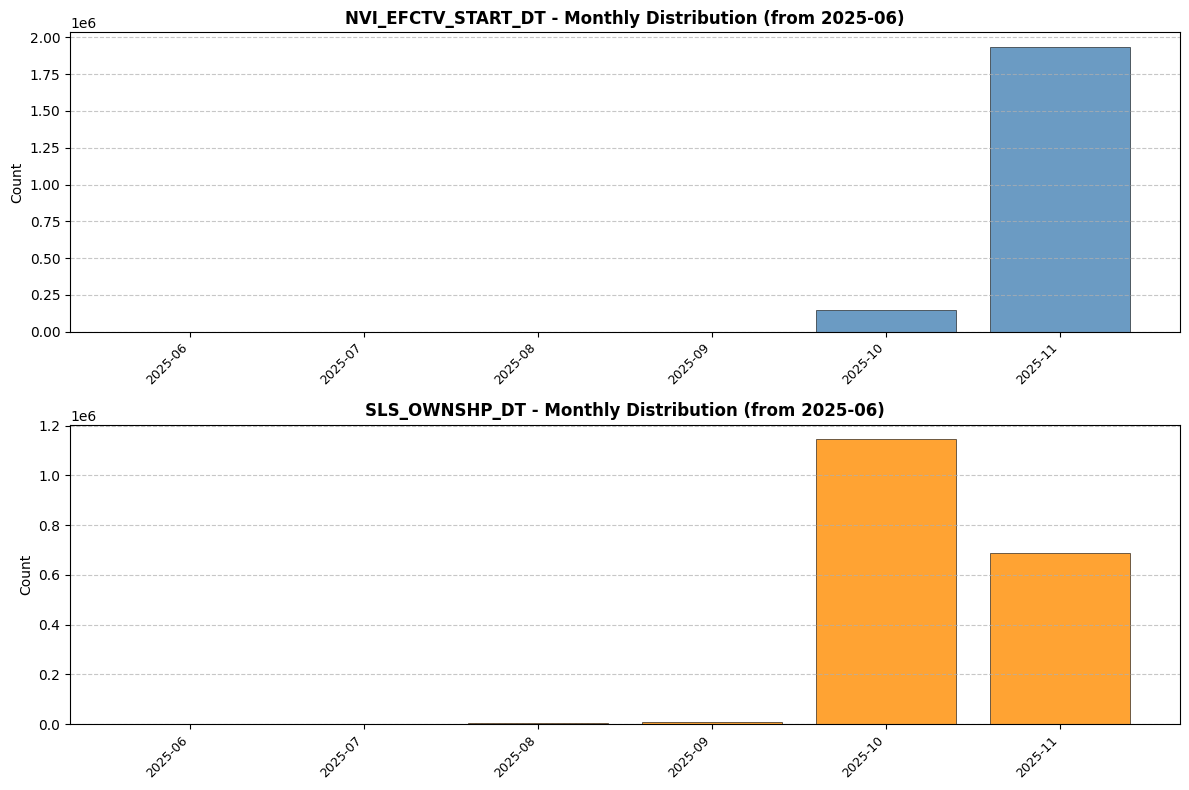

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Define date columns
date_cols = ['NVI_EFCTV_START_DT', 'SLS_OWNSHP_DT']

# Cutoff date
cutoff_date = pd.Timestamp('2025-06-01')

# Get valid dates and monthly counts for each column (only months > 0, >= 2025-06)
monthly_data = {}
for col in date_cols:
    dates = pd.to_datetime(full_df_live[col], errors='coerce')
    valid_dates = dates[(dates.notna()) & (dates.dt.year >= 1950) & (dates >= cutoff_date)]
    counts = valid_dates.dt.to_period('M').value_counts().sort_index()
    # Filter only months with count > 0
    counts = counts[counts > 0]
    monthly_data[col] = counts

# Find the union of all months with data > 0
all_months = monthly_data[date_cols[0]].index.union(monthly_data[date_cols[1]].index)
all_months = all_months.sort_values()

# Reindex both to the common month range (fill missing with 0)
for col in date_cols:
    monthly_data[col] = monthly_data[col].reindex(all_months, fill_value=0)

# Convert month labels to strings for categorical axis
month_labels = [m.strftime('%Y-%m') for m in all_months.to_timestamp()]

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
colors = ['steelblue', 'darkorange']

for i, col in enumerate(date_cols):
    counts = monthly_data[col]
    
    # Use categorical x-axis (evenly spaced bars)
    x_positions = range(len(month_labels))
    axes[i].bar(x_positions, counts.values, color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Set x-ticks with month labels
    axes[i].set_xticks(x_positions)
    axes[i].set_xticklabels(month_labels, rotation=45, ha='right', fontsize=9)
    
    axes[i].set_title(f'{col} - Monthly Distribution (from 2025-06)', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('')
    
    # Add grid for readability
    axes[i].yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
# Display all columns in full_df_live
print("="*100)
print(" " * 35 + "ALL COLUMNS IN full_df_live")
print("="*100)

print(f"\nTotal columns: {len(full_df_live.columns)}")
print(f"Total rows: {len(full_df_live):,}")

print("\nColumn list:")
print("-" * 100)

for i, col in enumerate(full_df_live.columns, 1):
    dtype = full_df_live[col].dtype
    null_count = full_df_live[col].isna().sum()
    null_pct = 100 * null_count / len(full_df_live)
    print(f"{i:3d}. {col:<40} Type: {str(dtype):<15} Nulls: {null_count:>10,} ({null_pct:>5.1f}%)")

print("\n" + "="*100)
print("✓ Column list complete!")
print("="*100)

                                   ALL COLUMNS IN full_df_live

Total columns: 40
Total rows: 2,237,310

Column list:
----------------------------------------------------------------------------------------------------
  1. NVI_VIN_COUNT                            Type: float64         Nulls:          0 (  0.0%)
  2. SEGMENT_DESC                             Type: object          Nulls:          0 (  0.0%)
  3. MAKE_DESC                                Type: object          Nulls:          0 (  0.0%)
  4. MODEL_DESC                               Type: object          Nulls:          0 (  0.0%)
  5. SERIES_TEXT                              Type: object          Nulls:          0 (  0.0%)
  6. TRIM_DESCRIPTION                         Type: object          Nulls:          0 (  0.0%)
  7. VEH_MDL_YR                               Type: object          Nulls:          0 (  0.0%)
  8. ADVNC_VEH_TYPE_DESC                      Type: object          Nulls:          0 (  0.0%)
  9. MODEL_KEY_SHORT 

In [6]:
# Quick diagnostic on INV_STATE_ABBRV values
print("INV_STATE_ABBRV Value Check:")
print("=" * 80)
print(f"Total rows: {len(full_df_live):,}")
print(f"Null values: {full_df_live['INV_STATE_ABBRV'].isna().sum():,}")
print(f"Empty string values: {(full_df_live['INV_STATE_ABBRV'] == '').sum():,}")
print(f"Non-null and non-empty: {((full_df_live['INV_STATE_ABBRV'].notna()) & (full_df_live['INV_STATE_ABBRV'] != '')).sum():,}")
print("\nTop 10 most common values:")
print(full_df_live['INV_STATE_ABBRV'].value_counts().head(10))

INV_STATE_ABBRV Value Check:
Total rows: 2,237,310
Null values: 0
Empty string values: 371,148
Non-null and non-empty: 1,866,162

Top 10 most common values:
INV_STATE_ABBRV
      371148
CA    206257
TX    188901
FL    175207
NY     97461
PA     73852
OH     73156
MI     69021
IL     60343
NC     60237
Name: count, dtype: int64


Preparing Sales Coverage Analysis...


KeyError: 'SALES_DT'

In [7]:
# Analyze SLS_EFCTV_START_DT and SLS_OWNSHP_DT columns
print("="*100)
print(" " * 25 + "DATE COLUMNS ANALYSIS - AFTER YEAR 1950")
print("="*100)

# Define the cutoff date
cutoff_date = pd.Timestamp('1950-01-01')

columns_to_check = ['SLS_EFCTV_START_DT', 'SLS_OWNSHP_DT']

print(f"\nCutoff date: January 1, 1950")
print(f"Total rows in dataset: {len(full_df_live):,}\n")

for col in columns_to_check:
    print("="*100)
    print(f"COLUMN: {col}")
    print("="*100)
    
    # Convert to datetime
    full_df_live[col] = pd.to_datetime(full_df_live[col], errors='coerce')
    
    # Calculate statistics
    total_rows = len(full_df_live)
    null_count = full_df_live[col].isna().sum()
    non_null_count = full_df_live[col].notna().sum()
    
    # Count values after 1950
    after_1950 = (full_df_live[col] >= cutoff_date).sum()
    before_1950 = ((full_df_live[col] < cutoff_date) & (full_df_live[col].notna())).sum()
    
    # Calculate percentages
    null_pct = 100 * null_count / total_rows
    non_null_pct = 100 * non_null_count / total_rows
    after_1950_pct = 100 * after_1950 / total_rows
    after_1950_of_non_null_pct = 100 * after_1950 / non_null_count if non_null_count > 0 else 0
    before_1950_pct = 100 * before_1950 / total_rows
    
    print(f"\n📊 Summary:")
    print(f"  Total rows:              {total_rows:>12,}")
    print(f"  Null values:             {null_count:>12,} ({null_pct:>6.2f}%)")
    print(f"  Non-null values:         {non_null_count:>12,} ({non_null_pct:>6.2f}%)")
    print(f"\n  After 1950-01-01:        {after_1950:>12,} ({after_1950_pct:>6.2f}% of total, {after_1950_of_non_null_pct:>6.2f}% of non-null)")
    print(f"  Before 1950-01-01:       {before_1950:>12,} ({before_1950_pct:>6.2f}%)")
    
    # Show date range if there are non-null values
    if non_null_count > 0:
        min_date = full_df_live[col].min()
        max_date = full_df_live[col].max()
        print(f"\n📅 Date Range:")
        print(f"  Earliest date:           {min_date}")
        print(f"  Latest date:             {max_date}")
    
    # Show distribution by year for non-null values
    if non_null_count > 0:
        print(f"\n📈 Distribution by Year (top 20):")
        year_counts = full_df_live[col].dt.year.value_counts().sort_index(ascending=False)
        print(f"\n  {'Year':<10} {'Count':<15} {'Percentage':<15}")
        print(f"  {'-'*40}")
        for year, count in year_counts.head(20).items():
            year_pct = 100 * count / non_null_count
            marker = "✅" if year >= 1950 else "❌"
            print(f"  {year:<10} {count:<15,} {year_pct:<15.2f}% {marker}")
        
        if len(year_counts) > 20:
            print(f"  ... ({len(year_counts) - 20} more years)")
    
    print()

print("\n" + "="*100)
print("✓ Date analysis complete!")
print("="*100)

                         DATE COLUMNS ANALYSIS - AFTER YEAR 1950

Cutoff date: January 1, 1950
Total rows in dataset: 2,237,310

COLUMN: SLS_EFCTV_START_DT

📊 Summary:
  Total rows:                 2,237,310
  Null values:                        0 (  0.00%)
  Non-null values:            2,237,310 (100.00%)

  After 1950-01-01:           1,848,134 ( 82.61% of total,  82.61% of non-null)
  Before 1950-01-01:            389,176 ( 17.39%)

📅 Date Range:
  Earliest date:           1899-12-30 00:00:00
  Latest date:             2025-11-21 00:00:00

📈 Distribution by Year (top 20):

  Year       Count           Percentage     
  ----------------------------------------
  2025       1,848,134       82.61          % ✅
  1899       389,176         17.39          % ❌

COLUMN: SLS_OWNSHP_DT

📊 Summary:
  Total rows:                 2,237,310
  Null values:                        0 (  0.00%)
  Non-null values:            2,237,310 (100.00%)

  After 1950-01-01:           1,848,134 ( 82.61% of total

In [8]:
# Sales Coverage Analysis by Make and State (using INV_STATE_ABBRV)
print("Preparing Sales Coverage Analysis...")
print("=" * 80)

# Define valid sales date cutoff
cutoff_date = pd.Timestamp('1950-01-01')

# Convert SLS_EFCTV_START_DT to datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')

# Calculate skipped rows
total_rows = len(full_df_live)
null_state = full_df_live['INV_STATE_ABBRV'].isna().sum()
null_make = full_df_live['MAKE_DESC'].isna().sum()
empty_state = (full_df_live['INV_STATE_ABBRV'] == '').sum()
empty_make = (full_df_live['MAKE_DESC'] == '').sum()
both_null = (full_df_live['INV_STATE_ABBRV'].isna() & full_df_live['MAKE_DESC'].isna()).sum()

print(f"\nData Summary:")
print(f"  Total rows: {total_rows:,}")
print(f"  Rows with null INV_STATE_ABBRV: {null_state:,} ({100*null_state/total_rows:.2f}%)")
print(f"  Rows with empty string INV_STATE_ABBRV: {empty_state:,} ({100*empty_state/total_rows:.2f}%)")
print(f"  Rows with null MAKE_DESC: {null_make:,} ({100*null_make/total_rows:.2f}%)")
print(f"  Rows with empty string MAKE_DESC: {empty_make:,} ({100*empty_make/total_rows:.2f}%)")
print(f"  Rows with both null: {both_null:,} ({100*both_null/total_rows:.2f}%)")

# Filter to valid rows (both MAKE_DESC and INV_STATE_ABBRV are not null AND not empty strings)
valid_df = full_df_live[
    (full_df_live['MAKE_DESC'].notna()) & 
    (full_df_live['MAKE_DESC'] != '') &
    (full_df_live['INV_STATE_ABBRV'].notna()) & 
    (full_df_live['INV_STATE_ABBRV'] != '')
].copy()
valid_rows = len(valid_df)
skipped_rows = total_rows - valid_rows

print(f"  Rows used in analysis: {valid_rows:,} ({100*valid_rows/total_rows:.2f}%)")
print(f"  Rows skipped: {skipped_rows:,} ({100*skipped_rows/total_rows:.2f}%)")

# Create sales coverage flag using SLS_EFCTV_START_DT
valid_df['has_sales_coverage'] = (valid_df['SLS_EFCTV_START_DT'].notna() & 
                                   (valid_df['SLS_EFCTV_START_DT'] >= cutoff_date)).astype(int)

# Diagnostic: Check overall distribution
total_with_coverage = valid_df['has_sales_coverage'].sum()
print(f"\nOverall Coverage:")
print(f"  Rows with sales coverage: {total_with_coverage:,} ({100*total_with_coverage/valid_rows:.2f}%)")
print(f"  Rows without sales coverage: {valid_rows - total_with_coverage:,} ({100*(valid_rows - total_with_coverage)/valid_rows:.2f}%)")

# Check some sample coverage percentages by Make
print(f"\nSample coverage by Make (top 5):")
make_coverage = valid_df.groupby('MAKE_DESC')['has_sales_coverage'].agg(['count', 'sum', 'mean'])
make_coverage['percentage'] = make_coverage['mean'] * 100
print(make_coverage.nlargest(5, 'count')[['count', 'sum', 'percentage']])

print(f"\nCalculating coverage matrix...")

# Create pivot table for coverage analysis
# Group by MAKE_DESC and INV_STATE_ABBRV, calculate total rows and coverage rows
coverage_data = valid_df.groupby(['MAKE_DESC', 'INV_STATE_ABBRV']).agg(
    total_rows=('has_sales_coverage', 'count'),
    coverage_rows=('has_sales_coverage', 'sum')
).reset_index()

# Calculate percentage
coverage_data['coverage_percentage'] = (coverage_data['coverage_rows'] / coverage_data['total_rows']) * 100

# Analyze coverage percentage distribution
print(f"\nCoverage Percentage Distribution:")
print(f"=" * 80)
total_combinations = len(coverage_data)
count_0_pct = (coverage_data['coverage_percentage'] == 0).sum()
count_100_pct = (coverage_data['coverage_percentage'] == 100).sum()
count_between = ((coverage_data['coverage_percentage'] > 0) & (coverage_data['coverage_percentage'] < 100)).sum()

print(f"Total Make × State combinations: {total_combinations:,}")
print(f"  0% coverage: {count_0_pct:,} combinations ({100*count_0_pct/total_combinations:.2f}%)")
print(f"  100% coverage: {count_100_pct:,} combinations ({100*count_100_pct/total_combinations:.2f}%)")
print(f"  Between 0-100%: {count_between:,} combinations ({100*count_between/total_combinations:.2f}%)")

# Show some examples of partial coverage
if count_between > 0:
    print(f"\nExamples of partial coverage (0% < coverage < 100%):")
    partial_coverage = coverage_data[(coverage_data['coverage_percentage'] > 0) & 
                                     (coverage_data['coverage_percentage'] < 100)].copy()
    partial_coverage_sorted = partial_coverage.sort_values('total_rows', ascending=False).head(10)
    print(partial_coverage_sorted[['MAKE_DESC', 'INV_STATE_ABBRV', 'total_rows', 'coverage_rows', 'coverage_percentage']].to_string(index=False))

# Identify top 20 combinations by total occurrence
top_20_combinations = coverage_data.nlargest(20, 'total_rows')[['MAKE_DESC', 'INV_STATE_ABBRV']].copy()
top_20_set = set(zip(top_20_combinations['MAKE_DESC'], top_20_combinations['INV_STATE_ABBRV']))

# Identify top 20 highest coverage percentages (excluding 0% and only for combinations with data)
top_20_coverage = coverage_data[coverage_data['total_rows'] > 0].nlargest(20, 'coverage_percentage')[['MAKE_DESC', 'INV_STATE_ABBRV']].copy()
top_20_coverage_set = set(zip(top_20_coverage['MAKE_DESC'], top_20_coverage['INV_STATE_ABBRV']))

print(f"\nTop 20 Make × State combinations by occurrence:")
top_20_display = coverage_data.nlargest(20, 'total_rows')[['MAKE_DESC', 'INV_STATE_ABBRV', 'total_rows', 'coverage_rows', 'coverage_percentage']]
top_20_display['coverage_percentage'] = top_20_display['coverage_percentage'].round(1)
print(top_20_display.to_string(index=False))

print(f"\nTop 20 Make × State combinations by highest coverage percentage:")
top_20_coverage_display = coverage_data[coverage_data['total_rows'] > 0].nlargest(20, 'coverage_percentage')[['MAKE_DESC', 'INV_STATE_ABBRV', 'total_rows', 'coverage_rows', 'coverage_percentage']]
top_20_coverage_display['coverage_percentage'] = top_20_coverage_display['coverage_percentage'].round(1)
print(top_20_coverage_display.to_string(index=False))

# Create formatted string with count and percentage
coverage_data['cell_value'] = coverage_data.apply(
    lambda row: f"{row['coverage_percentage']:.1f}% ({int(row['coverage_rows'])}/{int(row['total_rows'])})", 
    axis=1
)

# Pivot to create matrix with formatted values
coverage_matrix_display = coverage_data.pivot(index='MAKE_DESC', 
                                               columns='INV_STATE_ABBRV', 
                                               values='cell_value')

# Also create numeric matrix for calculations
coverage_matrix_numeric = coverage_data.pivot(index='MAKE_DESC', 
                                               columns='INV_STATE_ABBRV', 
                                               values='coverage_percentage')

# Fill NaN with empty string (representing 0/0 cases - no data for that combination)
coverage_matrix_display = coverage_matrix_display.fillna('')
coverage_matrix_numeric = coverage_matrix_numeric.fillna(0)

# Calculate row totals (overall coverage per Make)
row_totals = valid_df.groupby('MAKE_DESC').agg(
    total_rows=('has_sales_coverage', 'count'),
    coverage_rows=('has_sales_coverage', 'sum')
)
row_totals['percentage'] = (row_totals['coverage_rows'] / row_totals['total_rows']) * 100
row_totals['formatted'] = row_totals.apply(
    lambda row: f"{row['percentage']:.1f}% ({int(row['coverage_rows'])}/{int(row['total_rows'])})", 
    axis=1
)

# Calculate % of total dataset for each Make
row_totals['pct_of_dataset'] = (row_totals['total_rows'] / valid_rows) * 100
row_totals['pct_formatted'] = row_totals['pct_of_dataset'].apply(lambda x: f"{x:.1f}%")

coverage_matrix_display['Row_Total'] = row_totals['formatted']
coverage_matrix_display['% of Dataset'] = row_totals['pct_formatted']
coverage_matrix_numeric['Row_Total_%'] = row_totals['percentage']

# Calculate column totals (overall coverage per State)
col_totals = valid_df.groupby('INV_STATE_ABBRV').agg(
    total_rows=('has_sales_coverage', 'count'),
    coverage_rows=('has_sales_coverage', 'sum')
)
col_totals['percentage'] = (col_totals['coverage_rows'] / col_totals['total_rows']) * 100

# Calculate % of total dataset for each State
col_totals['pct_of_dataset'] = (col_totals['total_rows'] / valid_rows) * 100

# Add column totals as a new row
col_totals_dict_display = {}
col_totals_dict_numeric = {}
for state in col_totals.index:
    col_totals_dict_display[state] = f"{col_totals.loc[state, 'percentage']:.1f}% ({int(col_totals.loc[state, 'coverage_rows'])}/{int(col_totals.loc[state, 'total_rows'])})"
    col_totals_dict_numeric[state] = col_totals.loc[state, 'percentage']

# Grand total
grand_total_cov = valid_df['has_sales_coverage'].sum()
grand_total_rows = len(valid_df)
grand_total_pct = (grand_total_cov / grand_total_rows) * 100
col_totals_dict_display['Row_Total'] = f"{grand_total_pct:.1f}% ({int(grand_total_cov)}/{int(grand_total_rows)})"
col_totals_dict_display['% of Dataset'] = "100.0%"
col_totals_dict_numeric['Row_Total_%'] = grand_total_pct

coverage_matrix_display.loc['Column_Total'] = col_totals_dict_display
coverage_matrix_numeric.loc['Column_Total_%'] = col_totals_dict_numeric

# Add % of Dataset row (showing what % of total dataset each state represents)
pct_of_dataset_dict = {}
for state in col_totals.index:
    pct_of_dataset_dict[state] = f"{col_totals.loc[state, 'pct_of_dataset']:.1f}%"
pct_of_dataset_dict['Row_Total'] = "100.0%"
pct_of_dataset_dict['% of Dataset'] = "-"

coverage_matrix_display.loc['% of Dataset'] = pct_of_dataset_dict

# Sort by Row_Total_% descending (excluding the totals rows)
sorted_makes = coverage_matrix_numeric.iloc[:-1].sort_values('Row_Total_%', ascending=False).index
coverage_matrix_display_sorted = coverage_matrix_display.loc[sorted_makes.tolist() + ['Column_Total', '% of Dataset']]

print(f"\n✓ Matrix created: {len(coverage_matrix_display_sorted)-2} Makes × {len(coverage_matrix_display_sorted.columns)-2} States")
print(f"  + Row showing % of dataset per State")
print(f"  + Column showing % of dataset per Make")

# Export to Excel with formatting
output_file = 'sales_coverage_by_make_and_state.xlsx'

from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils import get_column_letter

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Main coverage matrix with formatted values
    coverage_matrix_display_sorted.to_excel(writer, sheet_name='Coverage_Matrix', index=True)
    
    # Summary statistics
    summary_data = {
        'Metric': [
            'Total Rows in Dataset',
            'Rows Used in Analysis',
            'Rows Skipped (null/empty Make or State)',
            'Percentage of Rows Skipped',
            'Rows with null INV_STATE_ABBRV',
            'Rows with empty INV_STATE_ABBRV',
            'Rows with null MAKE_DESC',
            'Rows with empty MAKE_DESC',
            'Overall Sales Coverage %',
            'Number of Makes',
            'Number of States',
            'Total Make × State Combinations',
            'Combinations with 0% Coverage',
            'Combinations with 100% Coverage',
            'Combinations with Partial Coverage',
            'Highlighted - Gold Background',
            'Highlighted - Green Text',
            'Highlighted - Both',
        ],
        'Value': [
            f"{total_rows:,}",
            f"{valid_rows:,}",
            f"{skipped_rows:,}",
            f"{100*skipped_rows/total_rows:.2f}%",
            f"{null_state:,}",
            f"{empty_state:,}",
            f"{null_make:,}",
            f"{empty_make:,}",
            f"{grand_total_pct:.2f}%",
            len(coverage_matrix_display_sorted) - 2,  # Exclude both totals rows
            len(coverage_matrix_display_sorted.columns) - 2,  # Exclude both totals columns
            f"{total_combinations:,}",
            f"{count_0_pct:,} ({100*count_0_pct/total_combinations:.2f}%)",
            f"{count_100_pct:,} ({100*count_100_pct/total_combinations:.2f}%)",
            f"{count_between:,} ({100*count_between/total_combinations:.2f}%)",
            'Top 20 Make × State by occurrence',
            'Top 20 Make × State by highest coverage %',
            'Cells in both top 20 lists'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Format the Coverage_Matrix sheet
    worksheet = writer.sheets['Coverage_Matrix']
    
    # Set column widths
    worksheet.column_dimensions['A'].width = 20  # MAKE_DESC column
    for col in range(2, len(coverage_matrix_display_sorted.columns) + 2):
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 18  # State columns
    
    # Set row height for better readability
    for row in range(1, len(coverage_matrix_display_sorted) + 2):
        worksheet.row_dimensions[row].height = 20
    
    # Format header row
    header_font = Font(bold=True, size=11)
    header_fill = PatternFill(start_color='D3D3D3', end_color='D3D3D3', fill_type='solid')
    header_alignment = Alignment(horizontal='center', vertical='center')
    
    for cell in worksheet[1]:
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = header_alignment
    
    # Format MAKE_DESC column (first column)
    for row in range(2, len(coverage_matrix_display_sorted) + 2):
        cell = worksheet.cell(row=row, column=1)
        cell.font = Font(bold=True, size=10)
        cell.alignment = Alignment(horizontal='left', vertical='center')
    
    # Center align all data cells
    for row in range(2, len(coverage_matrix_display_sorted) + 2):
        for col in range(2, len(coverage_matrix_display_sorted.columns) + 2):
            cell = worksheet.cell(row=row, column=col)
            cell.alignment = Alignment(horizontal='center', vertical='center')
    
    # Highlight top 20 combinations by occurrence (gold background) and highest coverage % (green text)
    highlight_fill_gold = PatternFill(start_color='FFD700', end_color='FFD700', fill_type='solid')  # Gold background
    font_green = Font(bold=True, size=10, color='00CC00')  # Bright green text, bold for emphasis
    font_black = Font(bold=True, size=10, color='000000')  # Black text
    
    # Create mapping of column names to column indices
    state_columns = [col for col in coverage_matrix_display_sorted.columns if col not in ['Row_Total', '% of Dataset']]
    
    # Apply highlighting based on which top 20 list(s) each cell is in
    for make in coverage_matrix_display_sorted.index:
        if make in ['Column_Total', '% of Dataset']:
            continue  # Skip totals rows
            
        for state in state_columns:
            combination = (make, state)
            in_top_occurrence = combination in top_20_set
            in_top_coverage = combination in top_20_coverage_set
            
            if in_top_occurrence or in_top_coverage:
                # Find the row and column indices
                row_idx = list(coverage_matrix_display_sorted.index).index(make) + 2
                col_idx = state_columns.index(state) + 2
                cell = worksheet.cell(row=row_idx, column=col_idx)
                
                # Apply styling based on which list(s) the combination is in
                if in_top_occurrence and in_top_coverage:
                    # Both: Gold background + Green text
                    cell.fill = highlight_fill_gold
                    cell.font = font_green
                elif in_top_occurrence:
                    # Only top occurrence: Gold background + Black text
                    cell.fill = highlight_fill_gold
                    cell.font = font_black
                else:
                    # Only top coverage: Green text (no background fill)
                    cell.font = font_green
    
    # Format Column_Total row (second to last row)
    column_total_row = len(coverage_matrix_display_sorted)
    totals_fill = PatternFill(start_color='FFEB9C', end_color='FFEB9C', fill_type='solid')
    for col in range(1, len(coverage_matrix_display_sorted.columns) + 2):
        cell = worksheet.cell(row=column_total_row, column=col)
        cell.fill = totals_fill
        cell.font = Font(bold=True, size=10)
    
    # Format % of Dataset row (last row)
    pct_dataset_row = len(coverage_matrix_display_sorted) + 1
    pct_fill = PatternFill(start_color='CCE5FF', end_color='CCE5FF', fill_type='solid')  # Light blue
    for col in range(1, len(coverage_matrix_display_sorted.columns) + 2):
        cell = worksheet.cell(row=pct_dataset_row, column=col)
        cell.fill = pct_fill
        cell.font = Font(bold=True, size=10)
    
    # Format % of Dataset column (last column before the formatting)
    pct_dataset_col = len(coverage_matrix_display_sorted.columns) + 1
    for row in range(2, len(coverage_matrix_display_sorted) + 2):
        cell = worksheet.cell(row=row, column=pct_dataset_col)
        cell.fill = pct_fill
        cell.font = Font(bold=True, size=10)
    
    # Format Summary sheet
    summary_ws = writer.sheets['Summary']
    summary_ws.column_dimensions['A'].width = 40
    summary_ws.column_dimensions['B'].width = 25
    
    # Format header
    for cell in summary_ws[1]:
        cell.font = Font(bold=True, size=11)
        cell.fill = PatternFill(start_color='D3D3D3', end_color='D3D3D3', fill_type='solid')
        cell.alignment = Alignment(horizontal='center', vertical='center')

print(f"\n✓ Results exported to: {output_file}")
print(f"  - Sheet 1: Coverage_Matrix (percentage + counts, formatted)")
print(f"  - Sheet 2: Summary (statistics + coverage distribution)")
print("\nFormatting applied:")
print(f"  ✓ Column width: 20 for Makes, 18 for States")
print(f"  ✓ Row height: 20 for better readability")
print(f"  ✓ Headers: Bold with gray background")
print(f"  ✓ Column_Total row: Bold with yellow background")
print(f"  ✓ % of Dataset row/column: Bold with light blue background")
print(f"  ✓ Top 20 by occurrence: Gold background")
print(f"  ✓ Top 20 by highest coverage %: Green text")
print(f"  ✓ In both top 20 lists: Gold background + Green text")
print(f"  ✓ Center-aligned data cells")
print("\nAnalysis complete!")

Preparing Sales Coverage Analysis...

Data Summary:
  Total rows: 2,237,310
  Rows with null INV_STATE_ABBRV: 0 (0.00%)
  Rows with empty string INV_STATE_ABBRV: 371,148 (16.59%)
  Rows with null MAKE_DESC: 0 (0.00%)
  Rows with empty string MAKE_DESC: 0 (0.00%)
  Rows with both null: 0 (0.00%)
  Rows used in analysis: 1,866,162 (83.41%)
  Rows skipped: 371,148 (16.59%)

Overall Coverage:
  Rows with sales coverage: 1,608,434 (86.19%)
  Rows without sales coverage: 257,728 (13.81%)

Sample coverage by Make (top 5):
            count     sum  percentage
MAKE_DESC                            
TOYOTA     316801  290844   91.806528
FORD       237921  209109   87.890098
CHEVROLET  208678  191886   91.953153
HONDA      164724  149008   90.459192
KIA        100818   89689   88.961297

Calculating coverage matrix...

Coverage Percentage Distribution:
Total Make × State combinations: 1,663
  0% coverage: 246 combinations (14.79%)
  100% coverage: 63 combinations (3.79%)
  Between 0-100%: 1,354 c

PermissionError: [Errno 13] Permission denied: 'sales_coverage_by_make_and_state.xlsx'

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\2907238021.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_cov.index, y=state_cov.values, ax=ax1, palette="viridis")
C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\2907238021.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_cov.values, y=make_cov.index, ax=ax2, palette="magma")


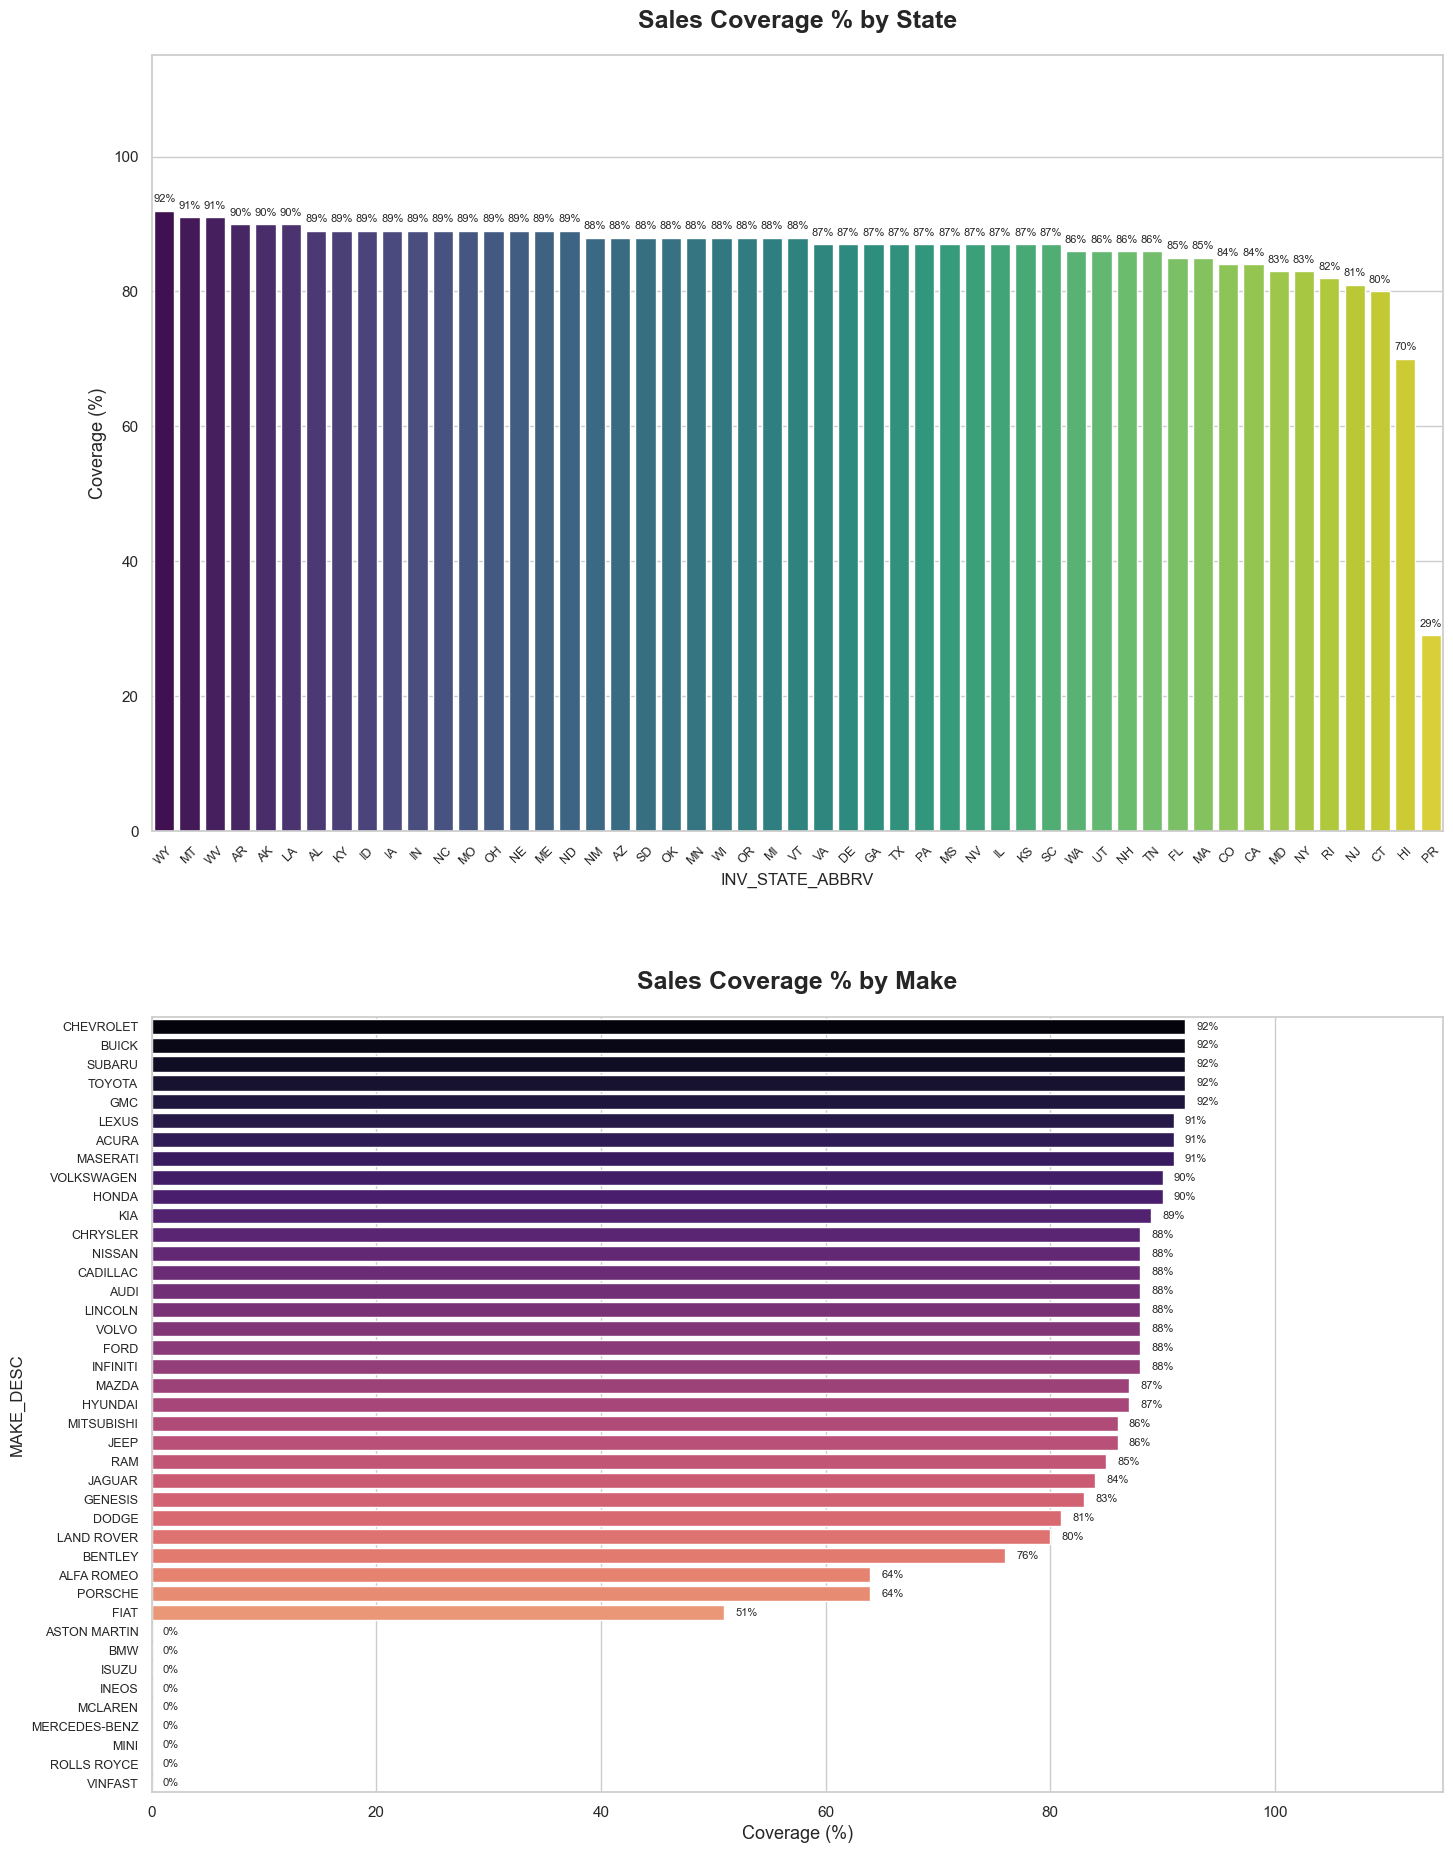

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional visual style
sns.set_theme(style="whitegrid")

# 1. Prepare the data (rounding to integers for cleaner labels)
state_cov = (valid_df.groupby('INV_STATE_ABBRV')['has_sales_coverage'].mean() * 100).round(0).astype(int).sort_values(ascending=False)
make_cov = (valid_df.groupby('MAKE_DESC')['has_sales_coverage'].mean() * 100).round(0).astype(int).sort_values(ascending=False)

# 2. Create the visualization layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# --- PLOT 1: SALES COVERAGE BY STATE ---
sns.barplot(x=state_cov.index, y=state_cov.values, ax=ax1, palette="viridis")
ax1.set_title('Sales Coverage % by State', fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel('Coverage (%)', fontsize=13)
ax1.set_ylim(0, 115)
ax1.tick_params(axis='x', rotation=45, labelsize=9) # Added rotation for State abbreviations

# Add integer labels on top of each state bar
for i, val in enumerate(state_cov.values):
    ax1.text(i, val + 1, f'{val}%', ha='center', va='bottom', fontsize=8)

# --- PLOT 2: SALES COVERAGE BY MAKE ---
sns.barplot(x=make_cov.values, y=make_cov.index, ax=ax2, palette="magma")
ax2.set_title('Sales Coverage % by Make', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Coverage (%)', fontsize=13)
ax2.set_xlim(0, 115)
ax2.tick_params(axis='y', labelsize=9)

# Add integer labels to the end of each brand bar
for i, val in enumerate(make_cov.values):
    ax2.text(val + 1, i, f'{val}%', va='center', fontsize=8)

plt.tight_layout(pad=5.0)
plt.show()

In [8]:
# Overall Sales Coverage Analysis
print("="*100)
print(" " * 30 + "OVERALL SALES COVERAGE ANALYSIS")
print("="*100)

# Define cutoff date
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure SLS_EFCTV_START_DT is datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')

# Calculate overall statistics
total_rows = len(full_df_live)
null_count = full_df_live['SLS_EFCTV_START_DT'].isna().sum()
non_null_count = full_df_live['SLS_EFCTV_START_DT'].notna().sum()

# Count valid sales dates (after 1950)
valid_sales = ((full_df_live['SLS_EFCTV_START_DT'].notna()) & 
               (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date)).sum()
invalid_sales = ((full_df_live['SLS_EFCTV_START_DT'].notna()) & 
                 (full_df_live['SLS_EFCTV_START_DT'] < cutoff_date)).sum()

# Calculate percentages
null_pct = 100 * null_count / total_rows
non_null_pct = 100 * non_null_count / total_rows
valid_sales_pct = 100 * valid_sales / total_rows
valid_of_non_null_pct = 100 * valid_sales / non_null_count if non_null_count > 0 else 0
invalid_sales_pct = 100 * invalid_sales / total_rows

print(f"\nDataset Summary:")
print(f"{'='*80}")
print(f"  Total rows:                    {total_rows:>15,}")
print(f"\nSLS_EFCTV_START_DT Column:")
print(f"  Null/Missing values:           {null_count:>15,} ({null_pct:>6.2f}%)")
print(f"  Non-null values:               {non_null_count:>15,} ({non_null_pct:>6.2f}%)")

print(f"\nSales Coverage (Cutoff: {cutoff_date.date()}):")
print(f"{'='*80}")
print(f"  Valid sales (≥ 1950-01-01):    {valid_sales:>15,} ({valid_sales_pct:>6.2f}% of total)")
print(f"  Invalid sales (< 1950-01-01):  {invalid_sales:>15,} ({invalid_sales_pct:>6.2f}% of total)")

print(f"\nCoverage Metrics:")
print(f"{'='*80}")
print(f"  Overall Coverage Rate:         {valid_sales_pct:>15.2f}% (of all rows)")
print(f"  Coverage Rate (non-null only): {valid_of_non_null_pct:>15.2f}% (of non-null dates)")

# Categorize rows
print(f"\nRow Categorization:")
print(f"{'='*80}")
categories = {
    'Has valid sales date (≥ 1950)': valid_sales,
    'Has invalid sales date (< 1950)': invalid_sales,
    'Missing sales date': null_count
}

for category, count in categories.items():
    pct = 100 * count / total_rows
    bar_length = int(pct / 2)
    bar = '█' * bar_length
    print(f"  {category:<35} {count:>12,} ({pct:>6.2f}%) {bar}")

# Visual summary
print(f"\n{'='*80}")
if valid_sales_pct >= 80:
    print(f"✅ EXCELLENT: {valid_sales_pct:.2f}% of rows have valid sales coverage")
elif valid_sales_pct >= 60:
    print(f"✅ GOOD: {valid_sales_pct:.2f}% of rows have valid sales coverage")
elif valid_sales_pct >= 40:
    print(f"⚠️  MODERATE: {valid_sales_pct:.2f}% of rows have valid sales coverage")
elif valid_sales_pct >= 20:
    print(f"⚠️  LOW: {valid_sales_pct:.2f}% of rows have valid sales coverage")
else:
    print(f"❌ VERY LOW: {valid_sales_pct:.2f}% of rows have valid sales coverage")

print(f"{'='*80}")

# Additional insights
if non_null_count > 0:
    print(f"\n📊 Additional Insights:")
    print(f"{'='*80}")
    
    # Date range
    min_date = full_df_live['SLS_EFCTV_START_DT'].min()
    max_date = full_df_live['SLS_EFCTV_START_DT'].max()
    print(f"  Date Range: {min_date} to {max_date}")
    
    # Year distribution
    year_counts = full_df_live['SLS_EFCTV_START_DT'].dt.year.value_counts().sort_index()
    print(f"\n  Years Represented: {year_counts.index.min()} - {year_counts.index.max()}")
    print(f"  Number of Different Years: {len(year_counts)}")
    
    # Most common years
    print(f"\n  Top 5 Most Common Years:")
    for year, count in year_counts.nlargest(5).items():
        year_pct = 100 * count / non_null_count
        marker = "✅" if year >= 1950 else "❌"
        print(f"    {year}: {count:>12,} records ({year_pct:>5.2f}%) {marker}")

print(f"\n{'='*100}")
print("✓ Overall coverage analysis complete!")
print(f"{'='*100}")

                              OVERALL SALES COVERAGE ANALYSIS

Dataset Summary:
  Total rows:                          2,237,310

SLS_EFCTV_START_DT Column:
  Null/Missing values:                         0 (  0.00%)
  Non-null values:                     2,237,310 (100.00%)

Sales Coverage (Cutoff: 1950-01-01):
  Valid sales (≥ 1950-01-01):          1,848,134 ( 82.61% of total)
  Invalid sales (< 1950-01-01):          389,176 ( 17.39% of total)

Coverage Metrics:
  Overall Coverage Rate:                   82.61% (of all rows)
  Coverage Rate (non-null only):           82.61% (of non-null dates)

Row Categorization:
  Has valid sales date (≥ 1950)          1,848,134 ( 82.61%) █████████████████████████████████████████
  Has invalid sales date (< 1950)          389,176 ( 17.39%) ████████
  Missing sales date                             0 (  0.00%) 

✅ EXCELLENT: 82.61% of rows have valid sales coverage

📊 Additional Insights:
  Date Range: 1899-12-30 00:00:00 to 2025-11-21 00:00:00

  Yea

                              SALES COVERAGE BY STATE - VISUALIZATION

Analyzing 1,866,162 rows with valid state information...

✓ Coverage calculated for 51 states

Top 10 states by coverage percentage:
  WY: 91.9% (2,606/2,837 rows)
  WV: 91.2% (9,438/10,350 rows)
  MT: 91.2% (4,775/5,237 rows)
  AK: 90.3% (2,990/3,310 rows)
  LA: 89.9% (23,993/26,692 rows)
  AR: 89.5% (15,498/17,312 rows)
  ID: 89.5% (10,519/11,755 rows)
  IN: 89.5% (26,935/30,104 rows)
  ND: 89.5% (4,736/5,294 rows)
  IA: 89.1% (14,842/16,651 rows)

✓ Chart saved: sales_coverage_by_state_charts.png


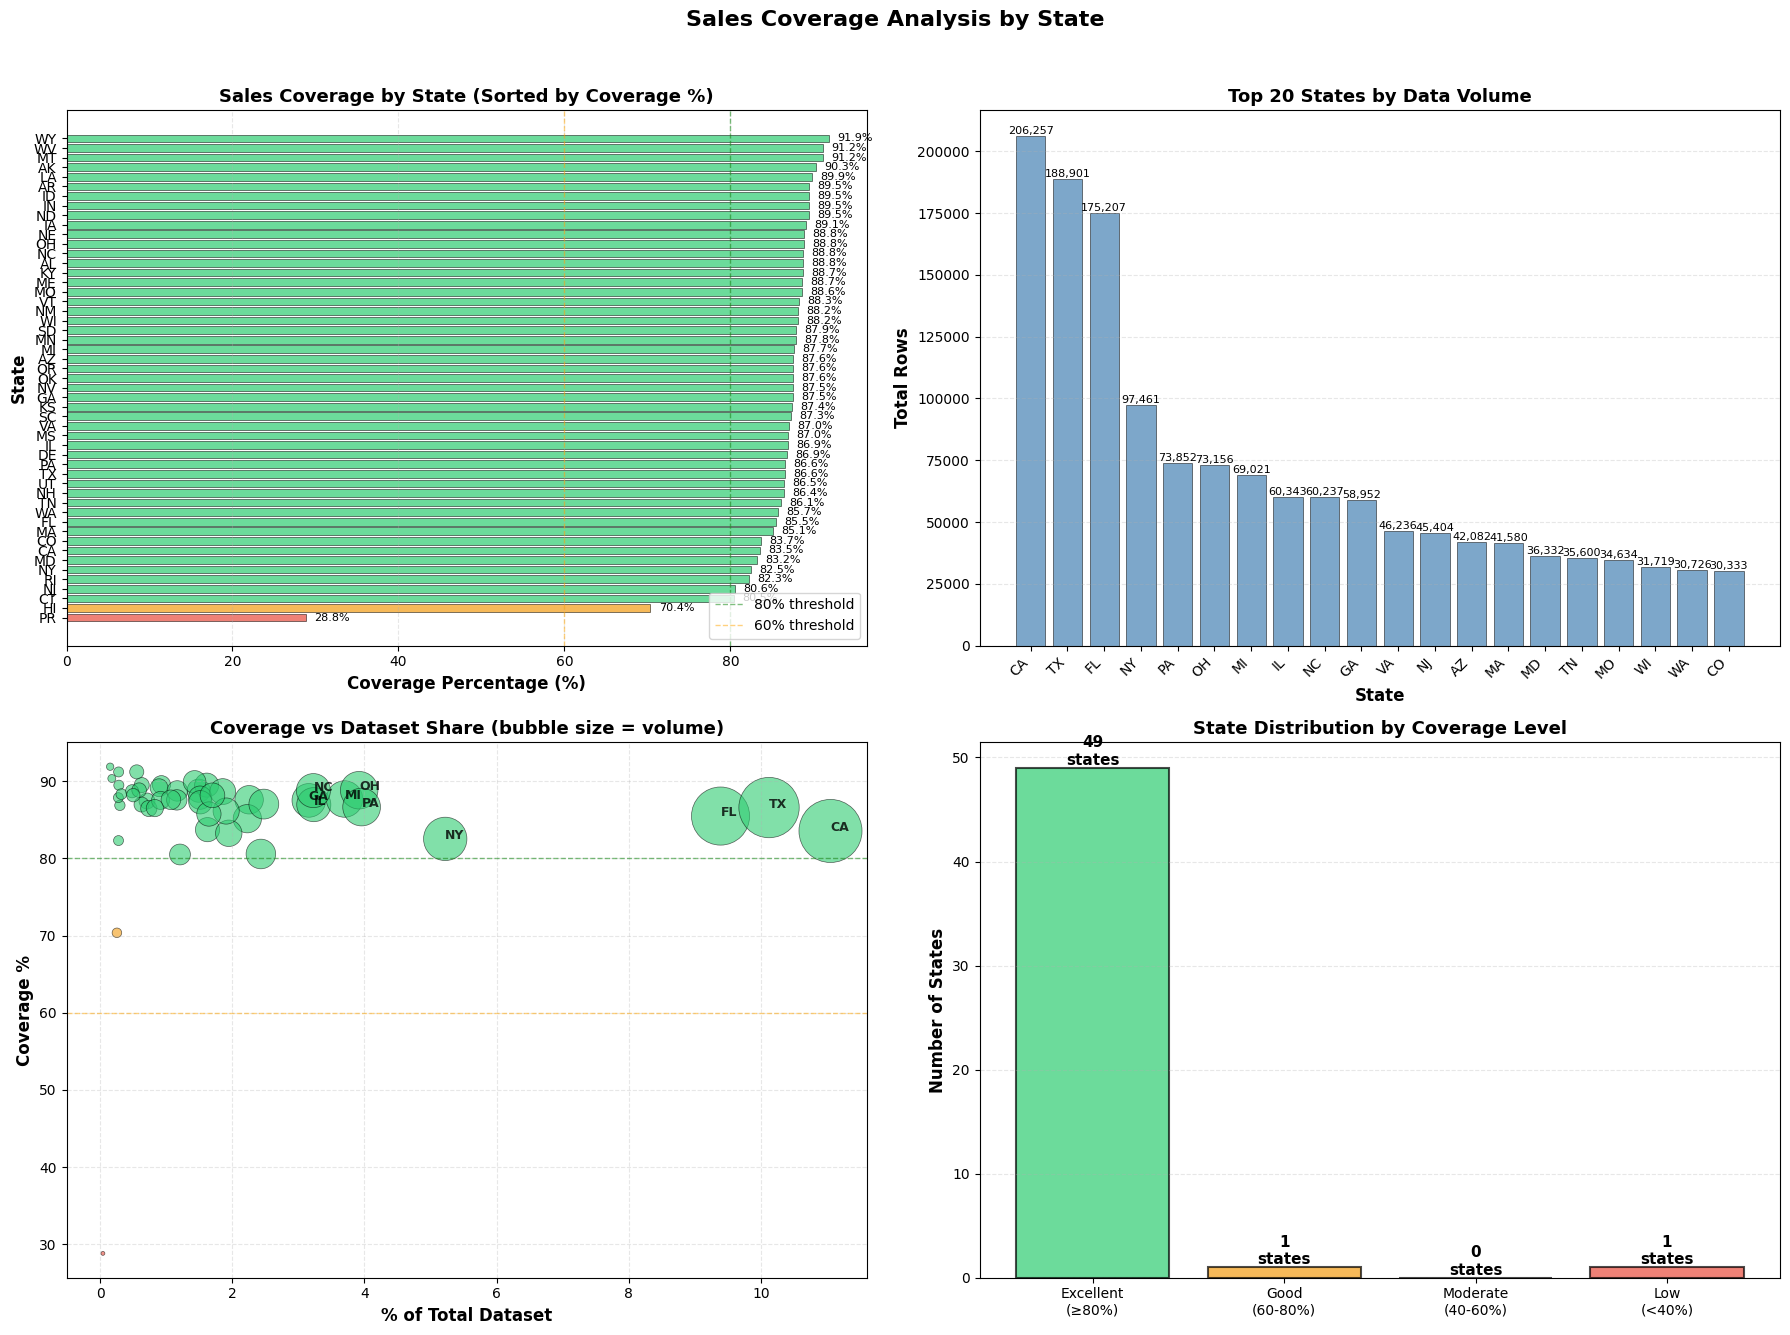


SUMMARY STATISTICS

Total states analyzed: 51

Coverage distribution:
  Excellent (≥80%):   49 states ( 96.1%)
  Good (60-80%):       1 states (  2.0%)
  Moderate (40-60%):   0 states (  0.0%)
  Low (<40%):          1 states (  2.0%)

Overall statistics:
  Average coverage across all states: 85.78%
  Median coverage:                    87.56%
  Best state:  WY (91.9%)
  Worst state: PR (28.8%)

✓ Visualization complete!


In [9]:
# Sales Coverage by State - Chart
print("="*100)
print(" " * 30 + "SALES COVERAGE BY STATE - VISUALIZATION")
print("="*100)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define cutoff date
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure SLS_EFCTV_START_DT is datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')

# Filter to valid rows (INV_STATE_ABBRV is not null and not empty)
valid_state_df = full_df_live[
    (full_df_live['INV_STATE_ABBRV'].notna()) & 
    (full_df_live['INV_STATE_ABBRV'] != '')
].copy()

print(f"\nAnalyzing {len(valid_state_df):,} rows with valid state information...")

# Create coverage flag
valid_state_df['has_coverage'] = (
    (valid_state_df['SLS_EFCTV_START_DT'].notna()) & 
    (valid_state_df['SLS_EFCTV_START_DT'] >= cutoff_date)
).astype(int)

# Calculate coverage by state
state_coverage = valid_state_df.groupby('INV_STATE_ABBRV').agg(
    total_rows=('has_coverage', 'count'),
    coverage_rows=('has_coverage', 'sum')
).reset_index()

state_coverage['coverage_pct'] = (state_coverage['coverage_rows'] / state_coverage['total_rows']) * 100
state_coverage['pct_of_dataset'] = (state_coverage['total_rows'] / len(valid_state_df)) * 100

# Sort by coverage percentage descending
state_coverage_sorted = state_coverage.sort_values('coverage_pct', ascending=True)

print(f"\n✓ Coverage calculated for {len(state_coverage)} states")
print(f"\nTop 10 states by coverage percentage:")
for idx, row in state_coverage.nlargest(10, 'coverage_pct').iterrows():
    print(f"  {row['INV_STATE_ABBRV']}: {row['coverage_pct']:.1f}% ({row['coverage_rows']:,}/{row['total_rows']:,} rows)")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Sales Coverage Analysis by State', fontsize=16, fontweight='bold')

# 1. Horizontal Bar Chart - Coverage Percentage by State
ax1 = axes[0, 0]
colors = ['#2ecc71' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' 
          for x in state_coverage_sorted['coverage_pct']]
bars = ax1.barh(state_coverage_sorted['INV_STATE_ABBRV'], 
                state_coverage_sorted['coverage_pct'], 
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Coverage Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('State', fontsize=12, fontweight='bold')
ax1.set_title('Sales Coverage by State (Sorted by Coverage %)', fontsize=13, fontweight='bold')
ax1.axvline(x=80, color='green', linestyle='--', linewidth=1, alpha=0.5, label='80% threshold')
ax1.axvline(x=60, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='60% threshold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.legend(loc='lower right')

# Add percentage labels
for i, (idx, row) in enumerate(state_coverage_sorted.iterrows()):
    ax1.text(row['coverage_pct'] + 1, i, f"{row['coverage_pct']:.1f}%", 
             va='center', fontsize=8)

# 2. Bar Chart - Total Rows by State (sorted by volume)
ax2 = axes[0, 1]
state_by_volume = state_coverage.sort_values('total_rows', ascending=False).head(20)
bars2 = ax2.bar(range(len(state_by_volume)), state_by_volume['total_rows'], 
                color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('State', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Rows', fontsize=12, fontweight='bold')
ax2.set_title('Top 20 States by Data Volume', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(state_by_volume)))
ax2.set_xticklabels(state_by_volume['INV_STATE_ABBRV'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(state_by_volume.iterrows()):
    ax2.text(i, row['total_rows'], f"{row['total_rows']:,}", 
             ha='center', va='bottom', fontsize=8, rotation=0)

# 3. Scatter Plot - Coverage % vs Dataset Size
ax3 = axes[1, 0]
scatter_colors = ['#2ecc71' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' 
                  for x in state_coverage['coverage_pct']]
scatter = ax3.scatter(state_coverage['pct_of_dataset'], 
                     state_coverage['coverage_pct'],
                     s=state_coverage['total_rows']/100,  # Size proportional to rows
                     c=scatter_colors, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('% of Total Dataset', fontsize=12, fontweight='bold')
ax3.set_ylabel('Coverage %', fontsize=12, fontweight='bold')
ax3.set_title('Coverage vs Dataset Share (bubble size = volume)', fontsize=13, fontweight='bold')
ax3.axhline(y=80, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax3.axhline(y=60, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax3.grid(alpha=0.3, linestyle='--')

# Add state labels for top states
top_states_by_volume = state_coverage.nlargest(10, 'total_rows')
for idx, row in top_states_by_volume.iterrows():
    ax3.annotate(row['INV_STATE_ABBRV'], 
                (row['pct_of_dataset'], row['coverage_pct']),
                fontsize=9, fontweight='bold', alpha=0.8)

# 4. Stacked Bar Chart - Coverage Distribution
ax4 = axes[1, 1]
# Categorize states
excellent = state_coverage[state_coverage['coverage_pct'] >= 80]
good = state_coverage[(state_coverage['coverage_pct'] >= 60) & (state_coverage['coverage_pct'] < 80)]
moderate = state_coverage[(state_coverage['coverage_pct'] >= 40) & (state_coverage['coverage_pct'] < 60)]
low = state_coverage[state_coverage['coverage_pct'] < 40]

categories = ['Excellent\n(≥80%)', 'Good\n(60-80%)', 'Moderate\n(40-60%)', 'Low\n(<40%)']
counts = [len(excellent), len(good), len(moderate), len(low)]
colors_cat = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

bars4 = ax4.bar(categories, counts, color=colors_cat, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of States', fontsize=12, fontweight='bold')
ax4.set_title('State Distribution by Coverage Level', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels
for i, (cat, count) in enumerate(zip(categories, counts)):
    ax4.text(i, count, f"{count}\nstates", ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
chart_filename = 'sales_coverage_by_state_charts.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Chart saved: {chart_filename}")

plt.show()

# Print summary statistics
print(f"\n{'='*100}")
print("SUMMARY STATISTICS")
print(f"{'='*100}")
print(f"\nTotal states analyzed: {len(state_coverage)}")
print(f"\nCoverage distribution:")
print(f"  Excellent (≥80%):  {len(excellent):>3} states ({100*len(excellent)/len(state_coverage):>5.1f}%)")
print(f"  Good (60-80%):     {len(good):>3} states ({100*len(good)/len(state_coverage):>5.1f}%)")
print(f"  Moderate (40-60%): {len(moderate):>3} states ({100*len(moderate)/len(state_coverage):>5.1f}%)")
print(f"  Low (<40%):        {len(low):>3} states ({100*len(low)/len(state_coverage):>5.1f}%)")

print(f"\nOverall statistics:")
print(f"  Average coverage across all states: {state_coverage['coverage_pct'].mean():.2f}%")
print(f"  Median coverage:                    {state_coverage['coverage_pct'].median():.2f}%")
print(f"  Best state:  {state_coverage.loc[state_coverage['coverage_pct'].idxmax(), 'INV_STATE_ABBRV']} ({state_coverage['coverage_pct'].max():.1f}%)")
print(f"  Worst state: {state_coverage.loc[state_coverage['coverage_pct'].idxmin(), 'INV_STATE_ABBRV']} ({state_coverage['coverage_pct'].min():.1f}%)")

print(f"\n{'='*100}")
print("✓ Visualization complete!")
print(f"{'='*100}")

In [10]:
# NVI Date Columns Coverage Analysis
print("="*100)
print(" " * 25 + "NVI DATE COLUMNS COVERAGE ANALYSIS")
print("="*100)

# Define cutoff date
cutoff_date = pd.Timestamp('1950-01-01')

columns_to_check = ['NVI_EFCTV_START_DT', 'NVI_OWNSHP_DT']

print(f"\nCutoff date: January 1, 1950")
print(f"Total rows in dataset: {len(full_df_live):,}\n")

for col in columns_to_check:
    print("="*100)
    print(f"COLUMN: {col}")
    print("="*100)
    
    # Convert to datetime
    full_df_live[col] = pd.to_datetime(full_df_live[col], errors='coerce')
    
    # Calculate statistics
    total_rows = len(full_df_live)
    null_count = full_df_live[col].isna().sum()
    non_null_count = full_df_live[col].notna().sum()
    
    # Count values after 1950
    after_1950 = (full_df_live[col] >= cutoff_date).sum()
    before_1950 = ((full_df_live[col] < cutoff_date) & (full_df_live[col].notna())).sum()
    
    # Calculate percentages
    null_pct = 100 * null_count / total_rows
    non_null_pct = 100 * non_null_count / total_rows
    after_1950_pct = 100 * after_1950 / total_rows
    after_1950_of_non_null_pct = 100 * after_1950 / non_null_count if non_null_count > 0 else 0
    before_1950_pct = 100 * before_1950 / total_rows
    
    print(f"\n📊 Summary:")
    print(f"  Total rows:              {total_rows:>12,}")
    print(f"  Null values:             {null_count:>12,} ({null_pct:>6.2f}%)")
    print(f"  Non-null values:         {non_null_count:>12,} ({non_null_pct:>6.2f}%)")
    print(f"\n  After 1950-01-01:        {after_1950:>12,} ({after_1950_pct:>6.2f}% of total, {after_1950_of_non_null_pct:>6.2f}% of non-null)")
    print(f"  Before 1950-01-01:       {before_1950:>12,} ({before_1950_pct:>6.2f}%)")
    
    # Coverage assessment
    print(f"\n📈 Coverage Assessment:")
    if after_1950_pct >= 80:
        print(f"  ✅ EXCELLENT: {after_1950_pct:.2f}% valid coverage")
    elif after_1950_pct >= 60:
        print(f"  ✅ GOOD: {after_1950_pct:.2f}% valid coverage")
    elif after_1950_pct >= 40:
        print(f"  ⚠️  MODERATE: {after_1950_pct:.2f}% valid coverage")
    elif after_1950_pct >= 20:
        print(f"  ⚠️  LOW: {after_1950_pct:.2f}% valid coverage")
    else:
        print(f"  ❌ VERY LOW: {after_1950_pct:.2f}% valid coverage")
    
    # Show date range if there are non-null values
    if non_null_count > 0:
        min_date = full_df_live[col].min()
        max_date = full_df_live[col].max()
        print(f"\n📅 Date Range:")
        print(f"  Earliest date:           {min_date}")
        print(f"  Latest date:             {max_date}")
        
        # Show distribution by year for non-null values
        print(f"\n📈 Distribution by Year (top 20):")
        year_counts = full_df_live[col].dt.year.value_counts().sort_index(ascending=False)
        print(f"\n  {'Year':<10} {'Count':<15} {'Percentage':<15}")
        print(f"  {'-'*40}")
        for year, count in year_counts.head(20).items():
            year_pct = 100 * count / non_null_count
            marker = "✅" if year >= 1950 else "❌"
            print(f"  {year:<10} {count:<15,} {year_pct:<15.2f}% {marker}")
        
        if len(year_counts) > 20:
            print(f"  ... ({len(year_counts) - 20} more years)")
    
    print()

# Compare both columns
print("\n" + "="*100)
print(" " * 30 + "COMPARISON SUMMARY")
print("="*100)

comparison_data = []
for col in columns_to_check:
    total = len(full_df_live)
    null_count = full_df_live[col].isna().sum()
    valid_coverage = (full_df_live[col] >= cutoff_date).sum()
    valid_pct = 100 * valid_coverage / total
    
    comparison_data.append({
        'Column': col,
        'Valid Coverage': f"{valid_coverage:,}",
        'Valid %': f"{valid_pct:.2f}%",
        'Null Count': f"{null_count:,}",
        'Null %': f"{100*null_count/total:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print(f"\n{comparison_df.to_string(index=False)}")

print("\n" + "="*100)
print("✓ NVI date columns analysis complete!")
print("="*100)

                         NVI DATE COLUMNS COVERAGE ANALYSIS

Cutoff date: January 1, 1950
Total rows in dataset: 2,237,310

COLUMN: NVI_EFCTV_START_DT

📊 Summary:
  Total rows:                 2,237,310
  Null values:                        0 (  0.00%)
  Non-null values:            2,237,310 (100.00%)

  After 1950-01-01:           2,084,095 ( 93.15% of total,  93.15% of non-null)
  Before 1950-01-01:            153,215 (  6.85%)

📈 Coverage Assessment:
  ✅ EXCELLENT: 93.15% valid coverage

📅 Date Range:
  Earliest date:           1899-12-30 00:00:00
  Latest date:             2025-11-25 10:52:51

📈 Distribution by Year (top 20):

  Year       Count           Percentage     
  ----------------------------------------
  2025       2,084,095       93.15          % ✅
  1899       153,215         6.85           % ❌

COLUMN: NVI_OWNSHP_DT

📊 Summary:
  Total rows:                 2,237,310
  Null values:                        0 (  0.00%)
  Non-null values:            2,237,310 (100.00%)

 

                         TIME DELTA ANALYSIS: NVI_EFCTV_START_DT vs NVI_OWNSHP_DT

📊 Data Availability:
  Total rows:                              2,237,310
  Both dates available:                    2,237,310 (100.00%)
  Both dates null:                                 0 (  0.00%)
  Only NVI_EFCTV_START_DT null:                    0 (  0.00%)
  Only NVI_OWNSHP_DT null:                         0 (  0.00%)

📈 Delta Statistics (for 2,237,310 rows with both dates):
  Mean:                                       -16.36 days
  Median:                                     -14.00 days
  Std Dev:                                     12.15 days
  Min:                                           -59 days
  Max:                                             0 days

📊 Percentiles:
    1th percentile:                           -47.00 days
    5th percentile:                           -37.00 days
   10th percentile:                           -34.00 days
   25th percentile:                           -26.00 

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_24864\442842180.py:134: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([delta_series], vert=True, patch_artist=True,


✓ Chart saved: nvi_delta_distribution.png


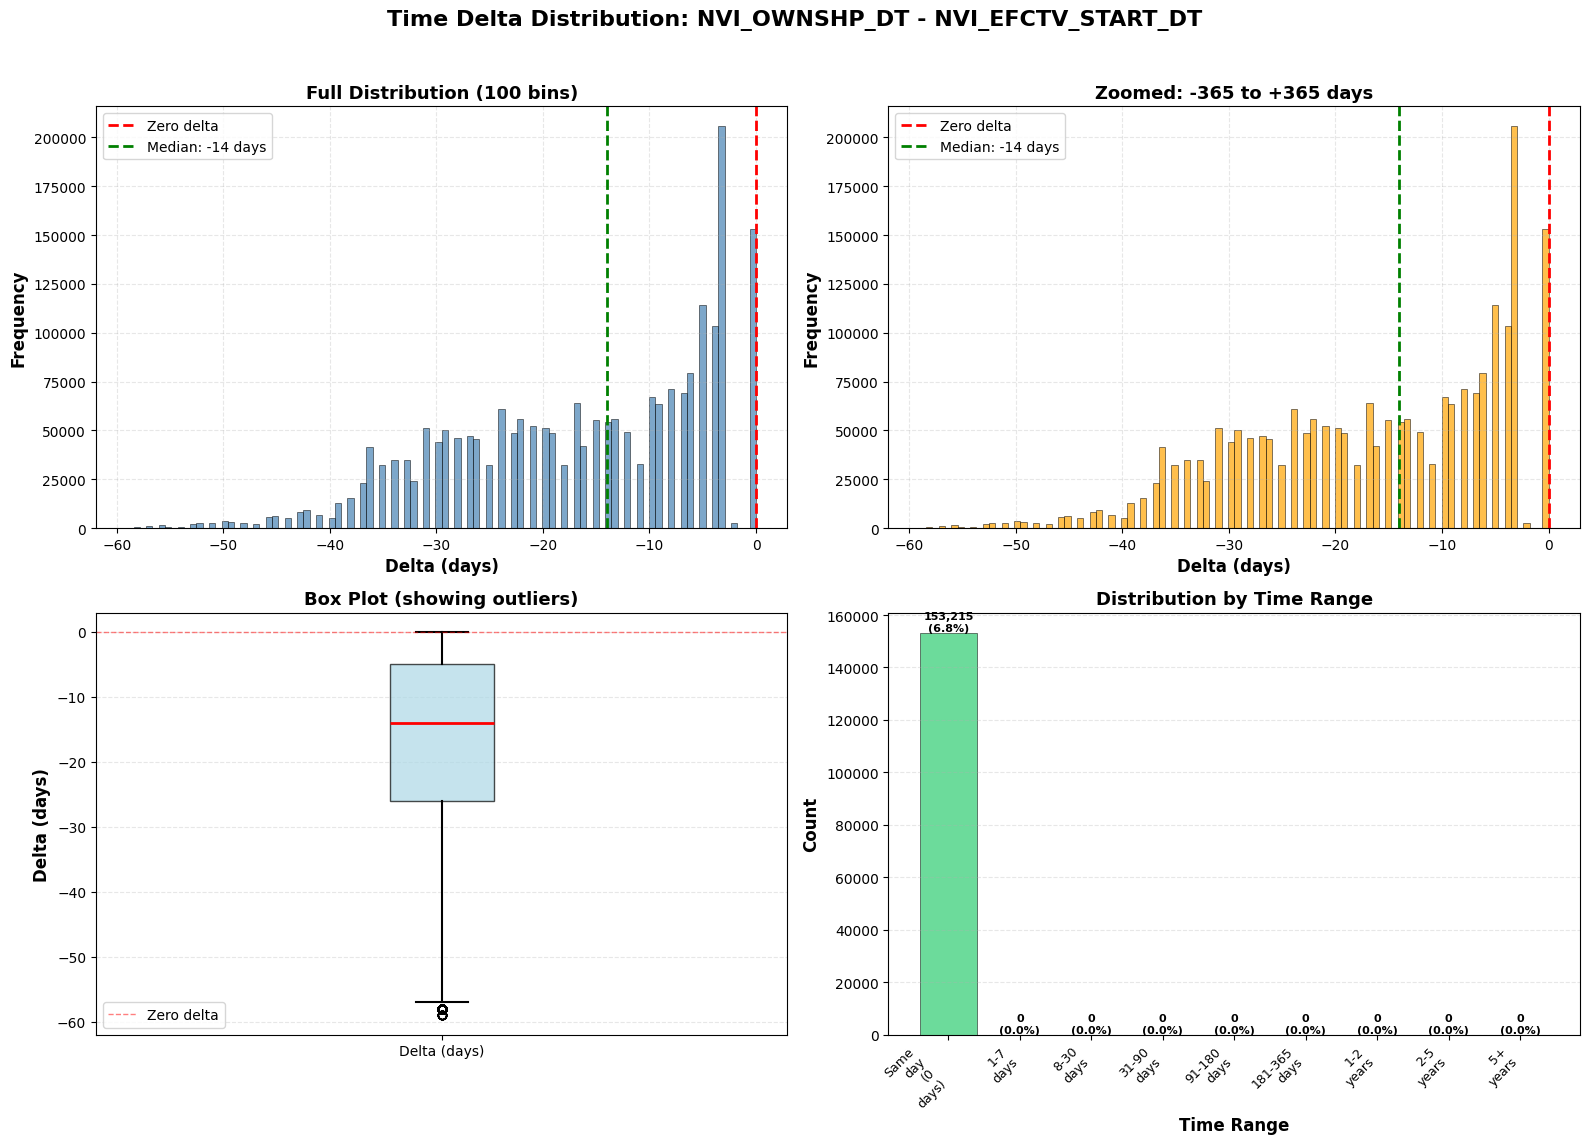


✓ Delta analysis complete!


In [11]:
# Delta Analysis between NVI_EFCTV_START_DT and NVI_OWNSHP_DT
print("="*100)
print(" " * 25 + "TIME DELTA ANALYSIS: NVI_EFCTV_START_DT vs NVI_OWNSHP_DT")
print("="*100)

# Ensure both columns are datetime
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_OWNSHP_DT'] = pd.to_datetime(full_df_live['NVI_OWNSHP_DT'], errors='coerce')

# Calculate delta in days (NVI_OWNSHP_DT - NVI_EFCTV_START_DT)
full_df_live['nvi_delta_days'] = (full_df_live['NVI_OWNSHP_DT'] - full_df_live['NVI_EFCTV_START_DT']).dt.days

# Get statistics
total_rows = len(full_df_live)
both_non_null = ((full_df_live['NVI_EFCTV_START_DT'].notna()) & 
                 (full_df_live['NVI_OWNSHP_DT'].notna())).sum()
both_null = ((full_df_live['NVI_EFCTV_START_DT'].isna()) & 
             (full_df_live['NVI_OWNSHP_DT'].isna())).sum()
only_start_null = ((full_df_live['NVI_EFCTV_START_DT'].isna()) & 
                   (full_df_live['NVI_OWNSHP_DT'].notna())).sum()
only_ownshp_null = ((full_df_live['NVI_EFCTV_START_DT'].notna()) & 
                    (full_df_live['NVI_OWNSHP_DT'].isna())).sum()

print(f"\n📊 Data Availability:")
print(f"  Total rows:                           {total_rows:>12,}")
print(f"  Both dates available:                 {both_non_null:>12,} ({100*both_non_null/total_rows:>6.2f}%)")
print(f"  Both dates null:                      {both_null:>12,} ({100*both_null/total_rows:>6.2f}%)")
print(f"  Only NVI_EFCTV_START_DT null:         {only_start_null:>12,} ({100*only_start_null/total_rows:>6.2f}%)")
print(f"  Only NVI_OWNSHP_DT null:              {only_ownshp_null:>12,} ({100*only_ownshp_null/total_rows:>6.2f}%)")

if both_non_null > 0:
    # Get delta statistics for rows where both dates are available
    delta_series = full_df_live['nvi_delta_days'].dropna()
    
    print(f"\n📈 Delta Statistics (for {len(delta_series):,} rows with both dates):")
    print(f"  Mean:                                 {delta_series.mean():>12.2f} days")
    print(f"  Median:                               {delta_series.median():>12.2f} days")
    print(f"  Std Dev:                              {delta_series.std():>12.2f} days")
    print(f"  Min:                                  {delta_series.min():>12.0f} days")
    print(f"  Max:                                  {delta_series.max():>12.0f} days")
    
    # Percentiles
    print(f"\n📊 Percentiles:")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        val = delta_series.quantile(p/100)
        print(f"  {p:>3}th percentile:                     {val:>12.2f} days")
    
    # Count negative, zero, and positive deltas
    negative = (delta_series < 0).sum()
    zero = (delta_series == 0).sum()
    positive = (delta_series > 0).sum()
    
    print(f"\n📉 Delta Sign Distribution:")
    print(f"  Negative (OWNSHP before START):       {negative:>12,} ({100*negative/len(delta_series):>6.2f}%)")
    print(f"  Zero (same date):                     {zero:>12,} ({100*zero/len(delta_series):>6.2f}%)")
    print(f"  Positive (OWNSHP after START):        {positive:>12,} ({100*positive/len(delta_series):>6.2f}%)")
    
    # Distribution by ranges
    print(f"\n📊 Delta Range Distribution:")
    ranges = [
        ('Same day (0 days)', 0, 0),
        ('1-7 days', 1, 7),
        ('8-30 days', 8, 30),
        ('31-90 days', 31, 90),
        ('91-180 days', 91, 180),
        ('181-365 days', 181, 365),
        ('1-2 years', 366, 730),
        ('2-5 years', 731, 1825),
        ('5+ years', 1826, float('inf'))
    ]
    
    for label, min_days, max_days in ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / len(delta_series)
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%) {bar}")
    
    # Also show negative ranges
    print(f"\nNegative Delta Ranges (OWNSHP before START):")
    neg_ranges = [
        ('0 to -7 days', -7, -1),
        ('-8 to -30 days', -30, -8),
        ('-31 to -90 days', -90, -31),
        ('-91 to -365 days', -365, -91),
        ('< -365 days', float('-inf'), -366)
    ]
    
    for label, min_days, max_days in neg_ranges:
        if min_days == float('-inf'):
            count = ((delta_series <= max_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / len(delta_series)
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%)")
    
    # Create histogram
    print(f"\n📊 Creating visualization...")
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Delta Distribution: NVI_OWNSHP_DT - NVI_EFCTV_START_DT', 
                 fontsize=16, fontweight='bold')
    
    # 1. Full distribution histogram
    ax1 = axes[0, 0]
    ax1.hist(delta_series, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero delta')
    ax1.axvline(x=delta_series.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delta_series.median():.0f} days')
    ax1.set_xlabel('Delta (days)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Full Distribution (100 bins)', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3, linestyle='--')
    
    # 2. Zoomed in: -365 to +365 days
    ax2 = axes[0, 1]
    delta_zoom = delta_series[(delta_series >= -365) & (delta_series <= 365)]
    ax2.hist(delta_zoom, bins=100, color='orange', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero delta')
    ax2.axvline(x=delta_zoom.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delta_zoom.median():.0f} days')
    ax2.set_xlabel('Delta (days)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Zoomed: -365 to +365 days', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, linestyle='--')
    
    # 3. Box plot
    ax3 = axes[1, 0]
    bp = ax3.boxplot([delta_series], vert=True, patch_artist=True, 
                      labels=['Delta (days)'],
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5))
    ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero delta')
    ax3.set_ylabel('Delta (days)', fontsize=12, fontweight='bold')
    ax3.set_title('Box Plot (showing outliers)', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.legend()
    
    # 4. Range distribution bar chart
    ax4 = axes[1, 1]
    range_labels = []
    range_counts = []
    range_colors = []
    
    for label, min_days, max_days in ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        range_labels.append(label.replace(' ', '\n'))
        range_counts.append(count)
        # Color based on range
        if min_days == 0 and max_days == 0:
            range_colors.append('#2ecc71')  # Green for same day
        elif max_days <= 30:
            range_colors.append('#3498db')  # Blue for short term
        elif max_days <= 365:
            range_colors.append('#f39c12')  # Orange for medium term
        else:
            range_colors.append('#e74c3c')  # Red for long term
    
    bars = ax4.bar(range(len(range_labels)), range_counts, color=range_colors, 
                   alpha=0.7, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Time Range', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax4.set_title('Distribution by Time Range', fontsize=13, fontweight='bold')
    ax4.set_xticks(range(len(range_labels)))
    ax4.set_xticklabels(range_labels, rotation=45, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count labels on bars
    for i, (count, bar) in enumerate(zip(range_counts, bars)):
        pct = 100 * count / len(delta_series)
        ax4.text(i, count, f"{count:,}\n({pct:.1f}%)", 
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save figure
    chart_filename = 'nvi_delta_distribution.png'
    plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
    print(f"✓ Chart saved: {chart_filename}")
    
    plt.show()

else:
    print("\n⚠️  No rows with both dates available for delta calculation")

print("\n" + "="*100)
print("✓ Delta analysis complete!")
print("="*100)

                         TIME DELTA ANALYSIS: SLS_EFCTV_START_DT vs NVI_EFCTV_START_DT

📊 Data Availability:
  Total rows:                              2,237,310
  Both dates available:                    2,237,310 (100.00%)
  Both dates null:                                 0 (  0.00%)
  Only SLS_EFCTV_START_DT null:                    0 (  0.00%)
  Only NVI_EFCTV_START_DT null:                    0 (  0.00%)

📈 Delta Statistics (for 2,237,310 rows with both dates):
  Mean:                                      4859.80 days
  Median:                                      17.00 days
  Std Dev:                                  22101.64 days
  Min:                                        -45982 days
  Max:                                         45986 days

📊 Percentiles:
    1th percentile:                        -45974.00 days
    5th percentile:                        -45944.00 days
   10th percentile:                             3.00 days
   25th percentile:                             

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_24864\2134674272.py:134: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([delta_series], vert=True, patch_artist=True,


✓ Chart saved: sls_nvi_delta_distribution.png


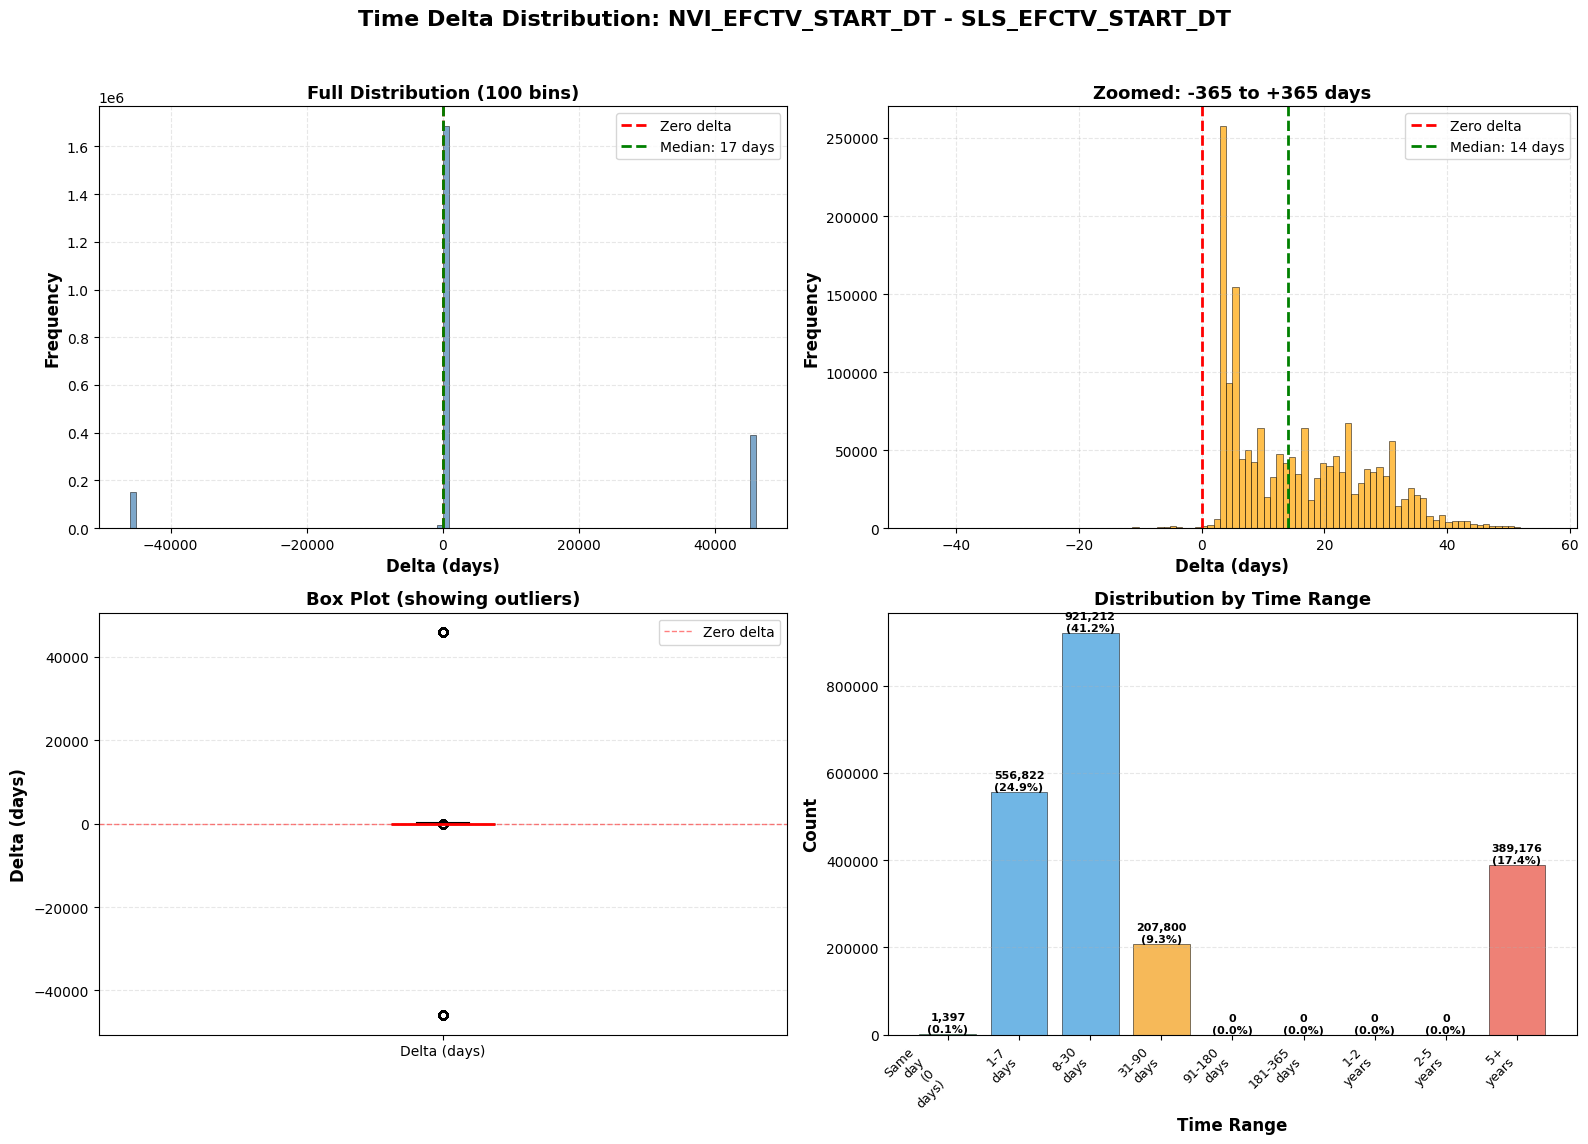


✓ Delta analysis complete!


In [12]:
# Delta Analysis between SLS_EFCTV_START_DT and NVI_EFCTV_START_DT
print("="*100)
print(" " * 25 + "TIME DELTA ANALYSIS: SLS_EFCTV_START_DT vs NVI_EFCTV_START_DT")
print("="*100)

# Ensure both columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# Calculate delta in days (NVI_EFCTV_START_DT - SLS_EFCTV_START_DT)
full_df_live['sls_nvi_delta_days'] = (full_df_live['NVI_EFCTV_START_DT'] - full_df_live['SLS_EFCTV_START_DT']).dt.days

# Get statistics
total_rows = len(full_df_live)
both_non_null = ((full_df_live['SLS_EFCTV_START_DT'].notna()) & 
                 (full_df_live['NVI_EFCTV_START_DT'].notna())).sum()
both_null = ((full_df_live['SLS_EFCTV_START_DT'].isna()) & 
             (full_df_live['NVI_EFCTV_START_DT'].isna())).sum()
only_sls_null = ((full_df_live['SLS_EFCTV_START_DT'].isna()) & 
                 (full_df_live['NVI_EFCTV_START_DT'].notna())).sum()
only_nvi_null = ((full_df_live['SLS_EFCTV_START_DT'].notna()) & 
                 (full_df_live['NVI_EFCTV_START_DT'].isna())).sum()

print(f"\n📊 Data Availability:")
print(f"  Total rows:                           {total_rows:>12,}")
print(f"  Both dates available:                 {both_non_null:>12,} ({100*both_non_null/total_rows:>6.2f}%)")
print(f"  Both dates null:                      {both_null:>12,} ({100*both_null/total_rows:>6.2f}%)")
print(f"  Only SLS_EFCTV_START_DT null:         {only_sls_null:>12,} ({100*only_sls_null/total_rows:>6.2f}%)")
print(f"  Only NVI_EFCTV_START_DT null:         {only_nvi_null:>12,} ({100*only_nvi_null/total_rows:>6.2f}%)")

if both_non_null > 0:
    # Get delta statistics for rows where both dates are available
    delta_series = full_df_live['sls_nvi_delta_days'].dropna()
    
    print(f"\n📈 Delta Statistics (for {len(delta_series):,} rows with both dates):")
    print(f"  Mean:                                 {delta_series.mean():>12.2f} days")
    print(f"  Median:                               {delta_series.median():>12.2f} days")
    print(f"  Std Dev:                              {delta_series.std():>12.2f} days")
    print(f"  Min:                                  {delta_series.min():>12.0f} days")
    print(f"  Max:                                  {delta_series.max():>12.0f} days")
    
    # Percentiles
    print(f"\n📊 Percentiles:")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        val = delta_series.quantile(p/100)
        print(f"  {p:>3}th percentile:                     {val:>12.2f} days")
    
    # Count negative, zero, and positive deltas
    negative = (delta_series < 0).sum()
    zero = (delta_series == 0).sum()
    positive = (delta_series > 0).sum()
    
    print(f"\n📉 Delta Sign Distribution:")
    print(f"  Negative (NVI before SLS):            {negative:>12,} ({100*negative/len(delta_series):>6.2f}%)")
    print(f"  Zero (same date):                     {zero:>12,} ({100*zero/len(delta_series):>6.2f}%)")
    print(f"  Positive (NVI after SLS):             {positive:>12,} ({100*positive/len(delta_series):>6.2f}%)")
    
    # Distribution by ranges
    print(f"\n📊 Delta Range Distribution:")
    ranges = [
        ('Same day (0 days)', 0, 0),
        ('1-7 days', 1, 7),
        ('8-30 days', 8, 30),
        ('31-90 days', 31, 90),
        ('91-180 days', 91, 180),
        ('181-365 days', 181, 365),
        ('1-2 years', 366, 730),
        ('2-5 years', 731, 1825),
        ('5+ years', 1826, float('inf'))
    ]
    
    for label, min_days, max_days in ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / len(delta_series)
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%) {bar}")
    
    # Also show negative ranges
    print(f"\nNegative Delta Ranges (NVI before SLS):")
    neg_ranges = [
        ('0 to -7 days', -7, -1),
        ('-8 to -30 days', -30, -8),
        ('-31 to -90 days', -90, -31),
        ('-91 to -365 days', -365, -91),
        ('< -365 days', float('-inf'), -366)
    ]
    
    for label, min_days, max_days in neg_ranges:
        if min_days == float('-inf'):
            count = ((delta_series <= max_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / len(delta_series)
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%)")
    
    # Create histogram
    print(f"\n📊 Creating visualization...")
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Delta Distribution: NVI_EFCTV_START_DT - SLS_EFCTV_START_DT', 
                 fontsize=16, fontweight='bold')
    
    # 1. Full distribution histogram
    ax1 = axes[0, 0]
    ax1.hist(delta_series, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero delta')
    ax1.axvline(x=delta_series.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delta_series.median():.0f} days')
    ax1.set_xlabel('Delta (days)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Full Distribution (100 bins)', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3, linestyle='--')
    
    # 2. Zoomed in: -365 to +365 days
    ax2 = axes[0, 1]
    delta_zoom = delta_series[(delta_series >= -365) & (delta_series <= 365)]
    ax2.hist(delta_zoom, bins=100, color='orange', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero delta')
    ax2.axvline(x=delta_zoom.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delta_zoom.median():.0f} days')
    ax2.set_xlabel('Delta (days)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Zoomed: -365 to +365 days', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, linestyle='--')
    
    # 3. Box plot
    ax3 = axes[1, 0]
    bp = ax3.boxplot([delta_series], vert=True, patch_artist=True, 
                      labels=['Delta (days)'],
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5))
    ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero delta')
    ax3.set_ylabel('Delta (days)', fontsize=12, fontweight='bold')
    ax3.set_title('Box Plot (showing outliers)', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.legend()
    
    # 4. Range distribution bar chart
    ax4 = axes[1, 1]
    range_labels = []
    range_counts = []
    range_colors = []
    
    for label, min_days, max_days in ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        range_labels.append(label.replace(' ', '\n'))
        range_counts.append(count)
        # Color based on range
        if min_days == 0 and max_days == 0:
            range_colors.append('#2ecc71')  # Green for same day
        elif max_days <= 30:
            range_colors.append('#3498db')  # Blue for short term
        elif max_days <= 365:
            range_colors.append('#f39c12')  # Orange for medium term
        else:
            range_colors.append('#e74c3c')  # Red for long term
    
    bars = ax4.bar(range(len(range_labels)), range_counts, color=range_colors, 
                   alpha=0.7, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Time Range', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax4.set_title('Distribution by Time Range', fontsize=13, fontweight='bold')
    ax4.set_xticks(range(len(range_labels)))
    ax4.set_xticklabels(range_labels, rotation=45, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count labels on bars
    for i, (count, bar) in enumerate(zip(range_counts, bars)):
        pct = 100 * count / len(delta_series)
        ax4.text(i, count, f"{count:,}\n({pct:.1f}%)", 
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save figure
    chart_filename = 'sls_nvi_delta_distribution.png'
    plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
    print(f"✓ Chart saved: {chart_filename}")
    
    plt.show()

else:
    print("\n⚠️  No rows with both dates available for delta calculation")

print("\n" + "="*100)
print("✓ Delta analysis complete!")
print("="*100)

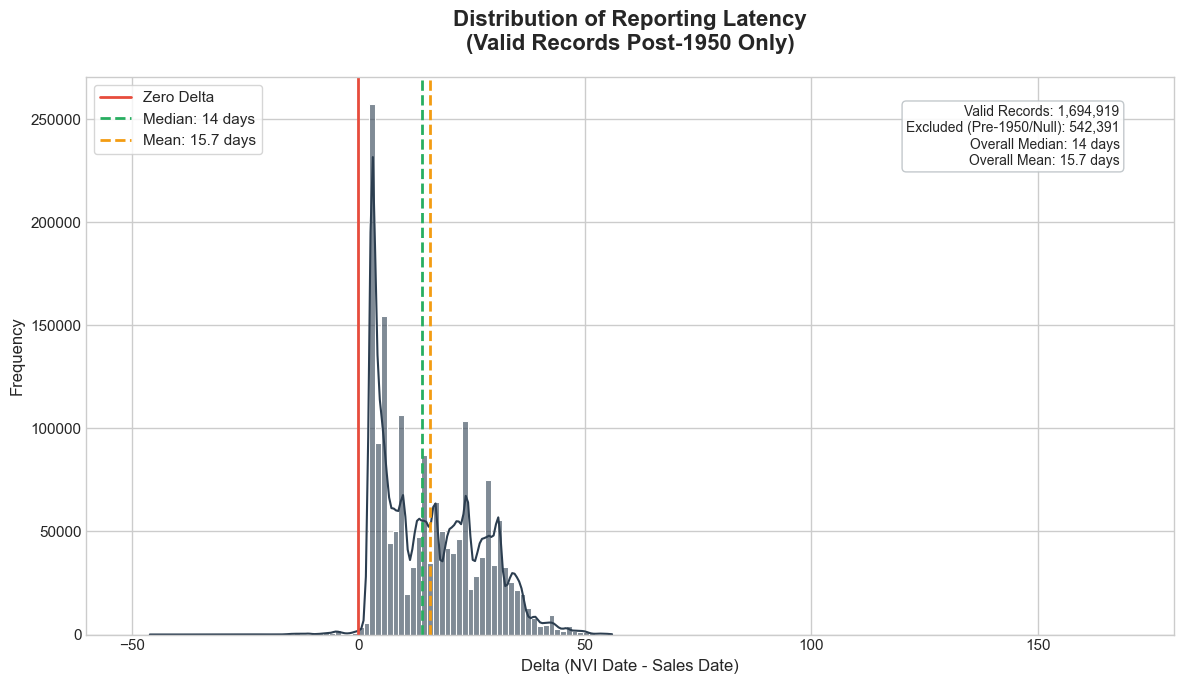

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# 2. APPLY GUARDRAIL: Define cutoff and filter out invalid years
cutoff_date = pd.Timestamp('1950-01-01')

# We only want rows where BOTH dates are after 1950 and neither is Null
mask = (
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
)

# Create a temporary plotting dataframe so we don't mess up your main data
plot_df = full_df_live[mask].copy()

# 3. Calculate Delta on valid records only
plot_df['sls_nvi_delta_days'] = (plot_df['NVI_EFCTV_START_DT'] - plot_df['SLS_EFCTV_START_DT']).dt.days

# 4. Filter for visual range (-60 to 180 days)
plot_min, plot_max = -60, 180
data_to_plot = plot_df['sls_nvi_delta_days']
filtered_data = data_to_plot[(data_to_plot >= plot_min) & (data_to_plot <= plot_max)]

# Stats for the label
median_val = data_to_plot.median()
mean_val = data_to_plot.mean()
n_count = len(data_to_plot)
skipped_count = len(full_df_live) - n_count

# 5. Create Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.histplot(filtered_data, bins=80, kde=True, color='#2c3e50', alpha=0.6, ax=ax, edgecolor='white')

# Reference lines
ax.axvline(0, color='#e74c3c', linestyle='-', linewidth=2, label='Zero Delta')
ax.axvline(median_val, color='#27ae60', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f} days')
ax.axvline(mean_val, color='#f39c12', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} days')

# Titles and Formatting
ax.set_title('Distribution of Reporting Latency\n(Valid Records Post-1950 Only)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Delta (NVI Date - Sales Date)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlim(plot_min, plot_max)

# Info Box (Updated to show records excluded by the 1950 filter)
stats_text = (
    f"Valid Records: {n_count:,}\n"
    f"Excluded (Pre-1950/Null): {skipped_count:,}\n"
    f"Overall Median: {median_val:.0f} days\n"
    f"Overall Mean: {mean_val:.1f} days"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#bdc3c7')
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

ax.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\3992927381.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_avg_delta.index, y=state_avg_delta.values, palette="coolwarm")


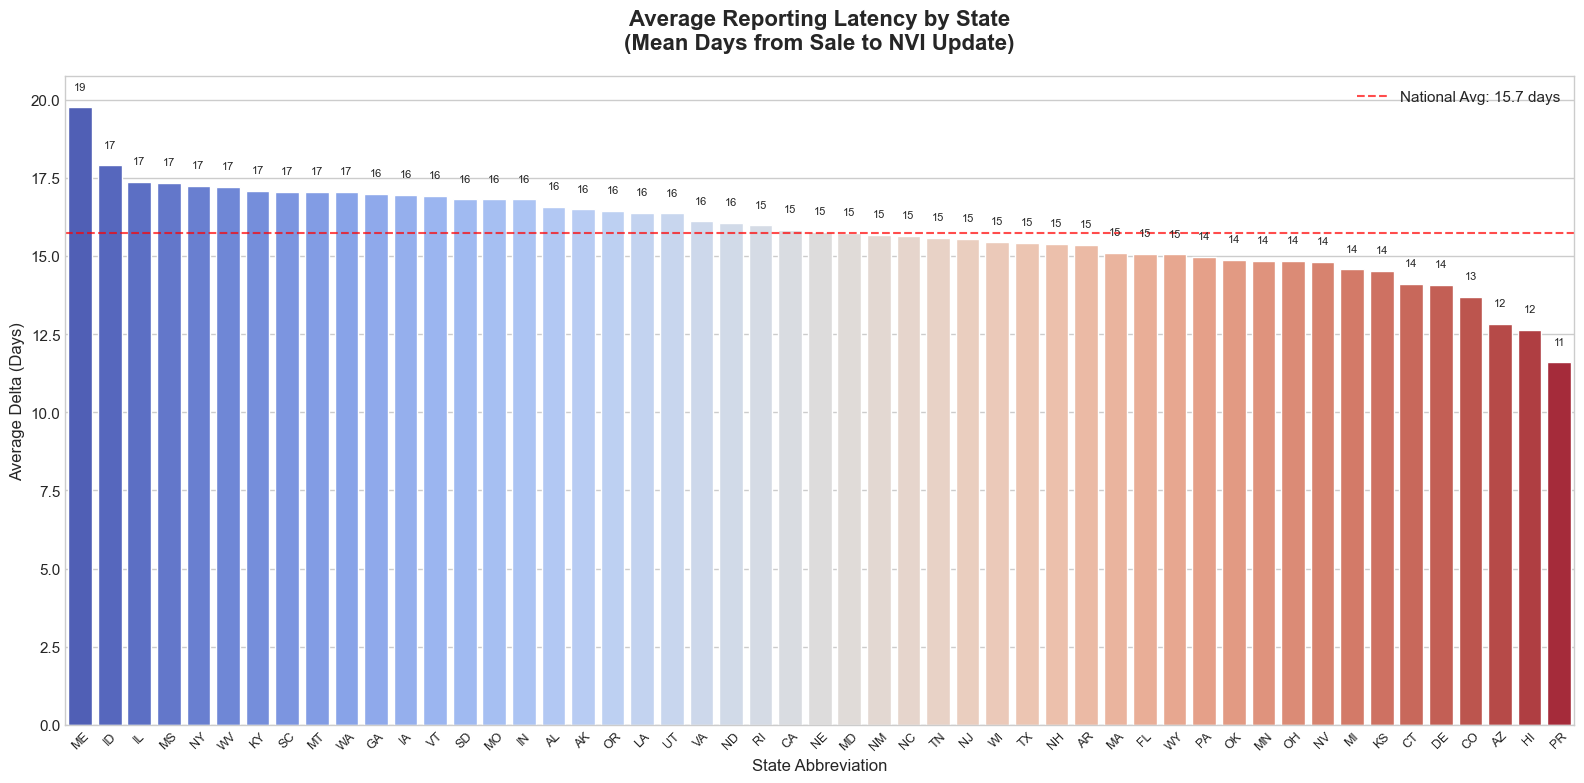

Top 10 States with Highest Latency (Slowest):
INV_STATE_ABBRV
ME    19.756439
ID    17.892407
IL    17.365855
MS    17.343760
NY    17.241346
WV    17.214270
KY    17.077395
SC    17.057490
MT    17.049454
WA    17.042881

Top 10 States with Lowest Latency (Fastest):
INV_STATE_ABBRV
OH    14.843655
NV    14.814610
MI    14.572309
KS    14.519536
CT    14.099797
DE    14.079023
CO    13.694513
AZ    12.836156
HI    12.633926
PR    11.591743


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# 2. Filter for valid records (Post-1950 and non-null)
cutoff_date = pd.Timestamp('1950-01-01')
mask = (
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['INV_STATE_ABBRV'].notna()) &
    (full_df_live['INV_STATE_ABBRV'] != '')
)
valid_df = full_df_live[mask].copy()

# 3. Calculate Delta
valid_df['sls_nvi_delta_days'] = (valid_df['NVI_EFCTV_START_DT'] - valid_df['SLS_EFCTV_START_DT']).dt.days

# 4. Group by State and Calculate Mean
# We use mean() here, but median is also useful if you suspect outliers within states
state_avg_delta = valid_df.groupby('INV_STATE_ABBRV')['sls_nvi_delta_days'].mean().sort_values(ascending=False)

# 5. Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(x=state_avg_delta.index, y=state_avg_delta.values, palette="coolwarm")

# Labels and Titles
plt.title('Average Reporting Latency by State\n(Mean Days from Sale to NVI Update)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Delta (Days)', fontsize=12)
plt.xlabel('State Abbreviation', fontsize=12)
plt.xticks(rotation=45, fontsize=9)

# Add value labels on top of bars
for i, val in enumerate(state_avg_delta.values):
    plt.text(i, val + 0.5, f'{int(val)}', ha='center', va='bottom', fontsize=8)

# Add a horizontal line for the national average
national_avg = valid_df['sls_nvi_delta_days'].mean()
plt.axhline(national_avg, color='red', linestyle='--', alpha=0.7, label=f'National Avg: {national_avg:.1f} days')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Display Summary Table
print("Top 10 States with Highest Latency (Slowest):")
print(state_avg_delta.head(10).to_string())
print("\nTop 10 States with Lowest Latency (Fastest):")
print(state_avg_delta.tail(10).to_string())

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\815929181.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_avg_delta.values, y=make_avg_delta.index, palette="magma")


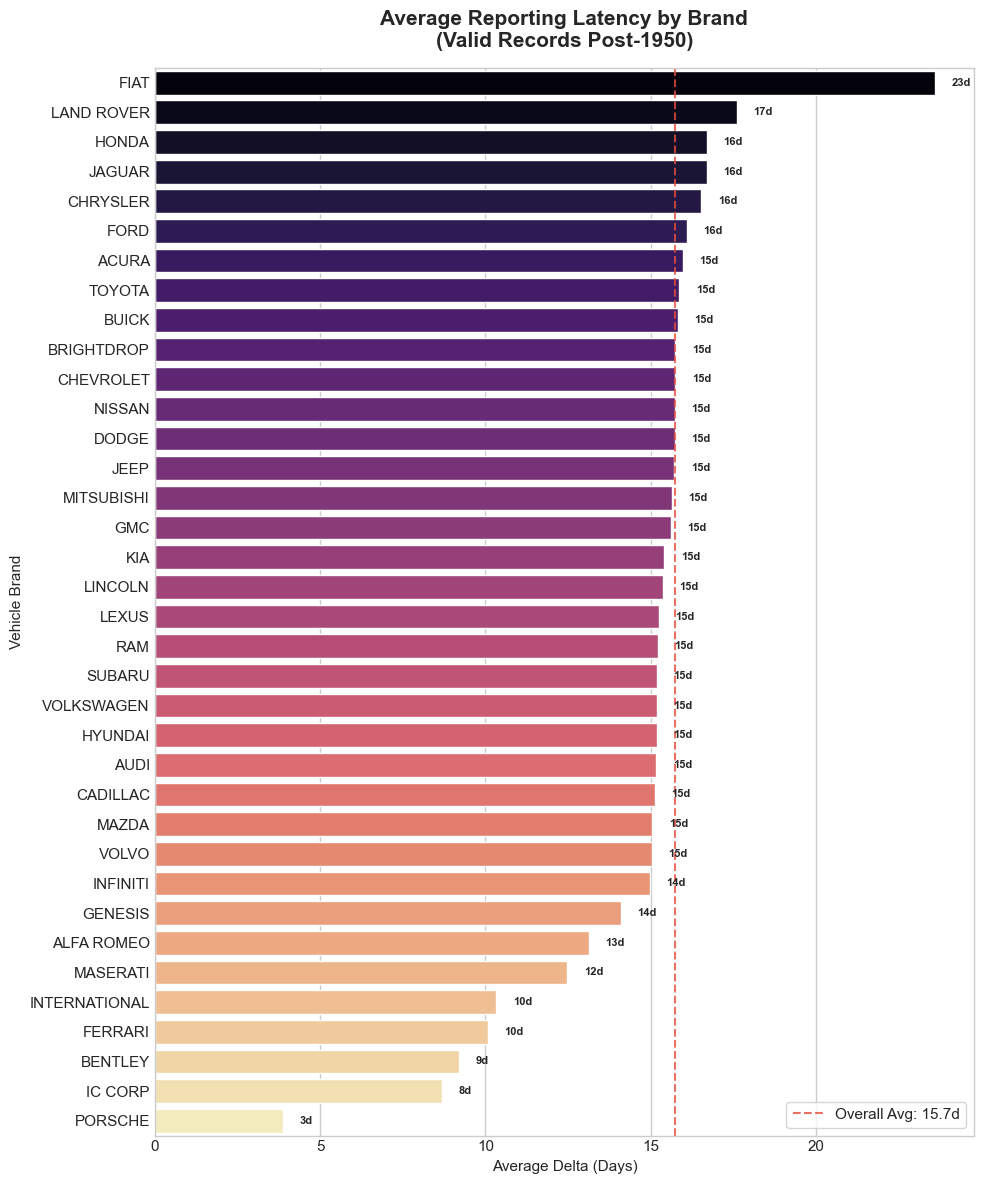

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Filter for valid records (Post-1950) and handle empty strings/nulls
cutoff_date = pd.Timestamp('1950-01-01')
mask = (
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['MAKE_DESC'].notna()) &
    (full_df_live['MAKE_DESC'] != '')
)

# 2. Prepare data
make_df = full_df_live[mask].copy()
make_df['sls_nvi_delta_days'] = (make_df['NVI_EFCTV_START_DT'] - make_df['SLS_EFCTV_START_DT']).dt.days
make_avg_delta = make_df.groupby('MAKE_DESC')['sls_nvi_delta_days'].mean().sort_values(ascending=False)

# 3. Create a slightly smaller visualization (10x12)
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 12))

# Create horizontal bar plot
sns.barplot(x=make_avg_delta.values, y=make_avg_delta.index, palette="magma")

# Add a vertical line for the national average benchmark
national_avg = make_df['sls_nvi_delta_days'].mean()
plt.axvline(national_avg, color='#e74c3c', linestyle='--', alpha=0.8, label=f'Overall Avg: {national_avg:.1f}d')

# Labels and Titles
plt.title('Average Reporting Latency by Brand\n(Valid Records Post-1950)', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Average Delta (Days)', fontsize=11)
plt.ylabel('Vehicle Brand', fontsize=11)

# Add compact integer labels to the end of each bar
for i, val in enumerate(make_avg_delta.values):
    plt.text(val + 0.5, i, f'{int(val)}d', va='center', fontsize=8, fontweight='bold')

plt.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.show()

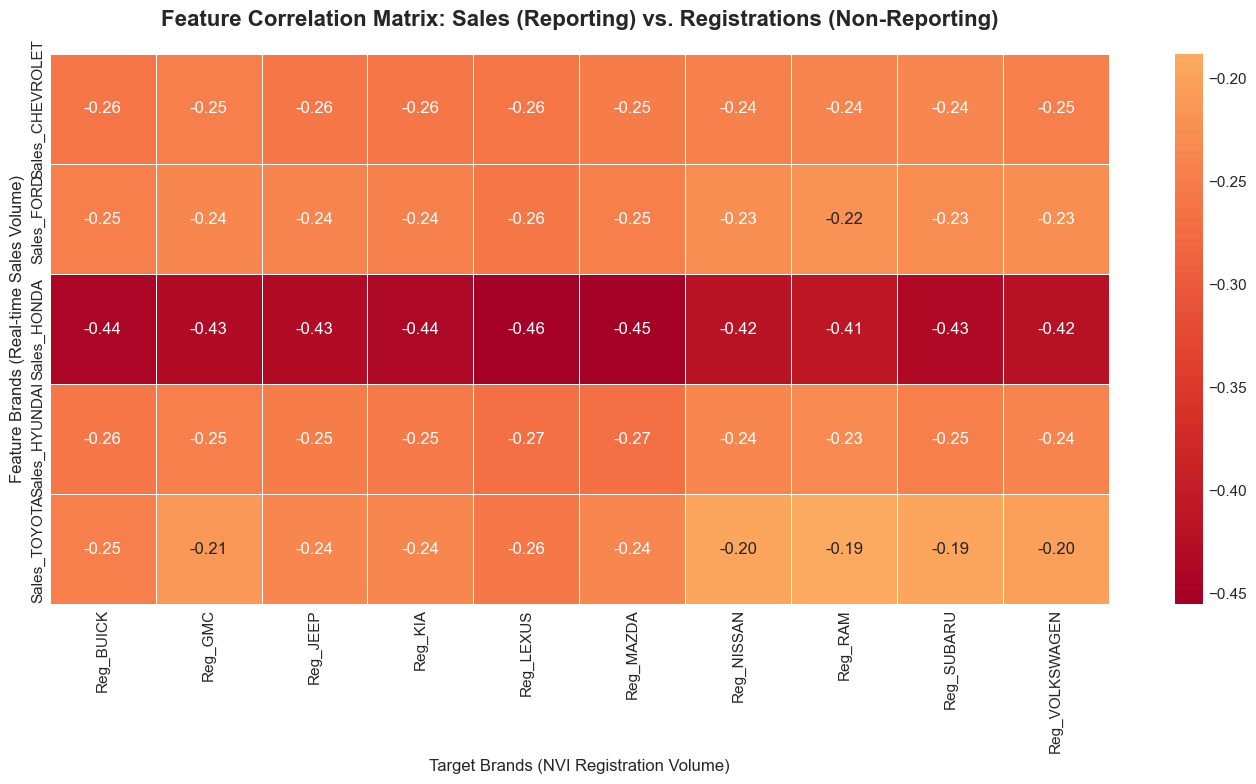

Reporting Brands (Features): TOYOTA, FORD, CHEVROLET, HONDA, HYUNDAI
Non-Reporting Brands (Targets): NISSAN, KIA, GMC, SUBARU, JEEP, RAM, LEXUS, MAZDA, VOLKSWAGEN, BUICK


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. CLEANING & PREPARATION
# Use the post-1950 guardrail established earlier
cutoff_date = pd.Timestamp('1950-01-01')
valid_mask = (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) & \
             (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
analysis_df = full_df_live[valid_mask].copy()

# 2. DEFINE GROUPS
# We define "Reporting Brands" as the Top 5 by Sales Volume
top_reporting = analysis_df.groupby('MAKE_DESC')['SLS_COUNT'].sum().nlargest(5).index.tolist()
# We treat the remaining top brands as "Non-Reporting" targets for this analysis
targets = analysis_df.groupby('MAKE_DESC')['NVI_VIN_COUNT'].sum().nlargest(15).index.tolist()
targets = [t for t in targets if t not in top_reporting][:10]

# 3. AGGREGATE TO WEEKLY TIME SERIES
# Feature: Sales Volume of Reporting Brands
features_ts = analysis_df[analysis_df['MAKE_DESC'].isin(top_reporting)].copy()
features_ts['WEEK'] = features_ts['SLS_EFCTV_START_DT'].dt.to_period('W').dt.start_time
features_pivot = features_ts.pivot_table(index='WEEK', columns='MAKE_DESC', values='SLS_COUNT', aggfunc='sum').fillna(0)
features_pivot.columns = [f"Sales_{c}" for c in features_pivot.columns]

# Target: NVI Volume of Non-Reporting Brands
targets_ts = analysis_df[analysis_df['MAKE_DESC'].isin(targets)].copy()
targets_ts['WEEK'] = targets_ts['NVI_EFCTV_START_DT'].dt.to_period('W').dt.start_time
targets_pivot = targets_ts.pivot_table(index='WEEK', columns='MAKE_DESC', values='NVI_VIN_COUNT', aggfunc='sum').fillna(0)
targets_pivot.columns = [f"Reg_{c}" for c in targets_pivot.columns]

# 4. CORRELATION ANALYSIS
# Combine both into one dataframe
combined_df = pd.concat([features_pivot, targets_pivot], axis=1).dropna()
corr_matrix = combined_df.corr()

# Filter matrix to show only Sales (Features) vs. Registrations (Targets)
feature_cols = [c for c in combined_df.columns if c.startswith('Sales_')]
target_cols = [c for c in combined_df.columns if c.startswith('Reg_')]
cross_corr = corr_matrix.loc[feature_cols, target_cols]

# 5. VISUALIZATION
plt.figure(figsize=(14, 8))
sns.heatmap(cross_corr, annot=True, cmap='RdYlGn', center=0, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix: Sales (Reporting) vs. Registrations (Non-Reporting)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Target Brands (NVI Registration Volume)', fontsize=12)
plt.ylabel('Feature Brands (Real-time Sales Volume)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Reporting Brands (Features): {', '.join(top_reporting)}")
print(f"Non-Reporting Brands (Targets): {', '.join(targets)}")

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\1425966274.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_std.index, y=state_std.values, ax=ax1, palette="flare")
C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_2780\1425966274.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_std.values, y=make_std.index, ax=ax2, palette="crest")


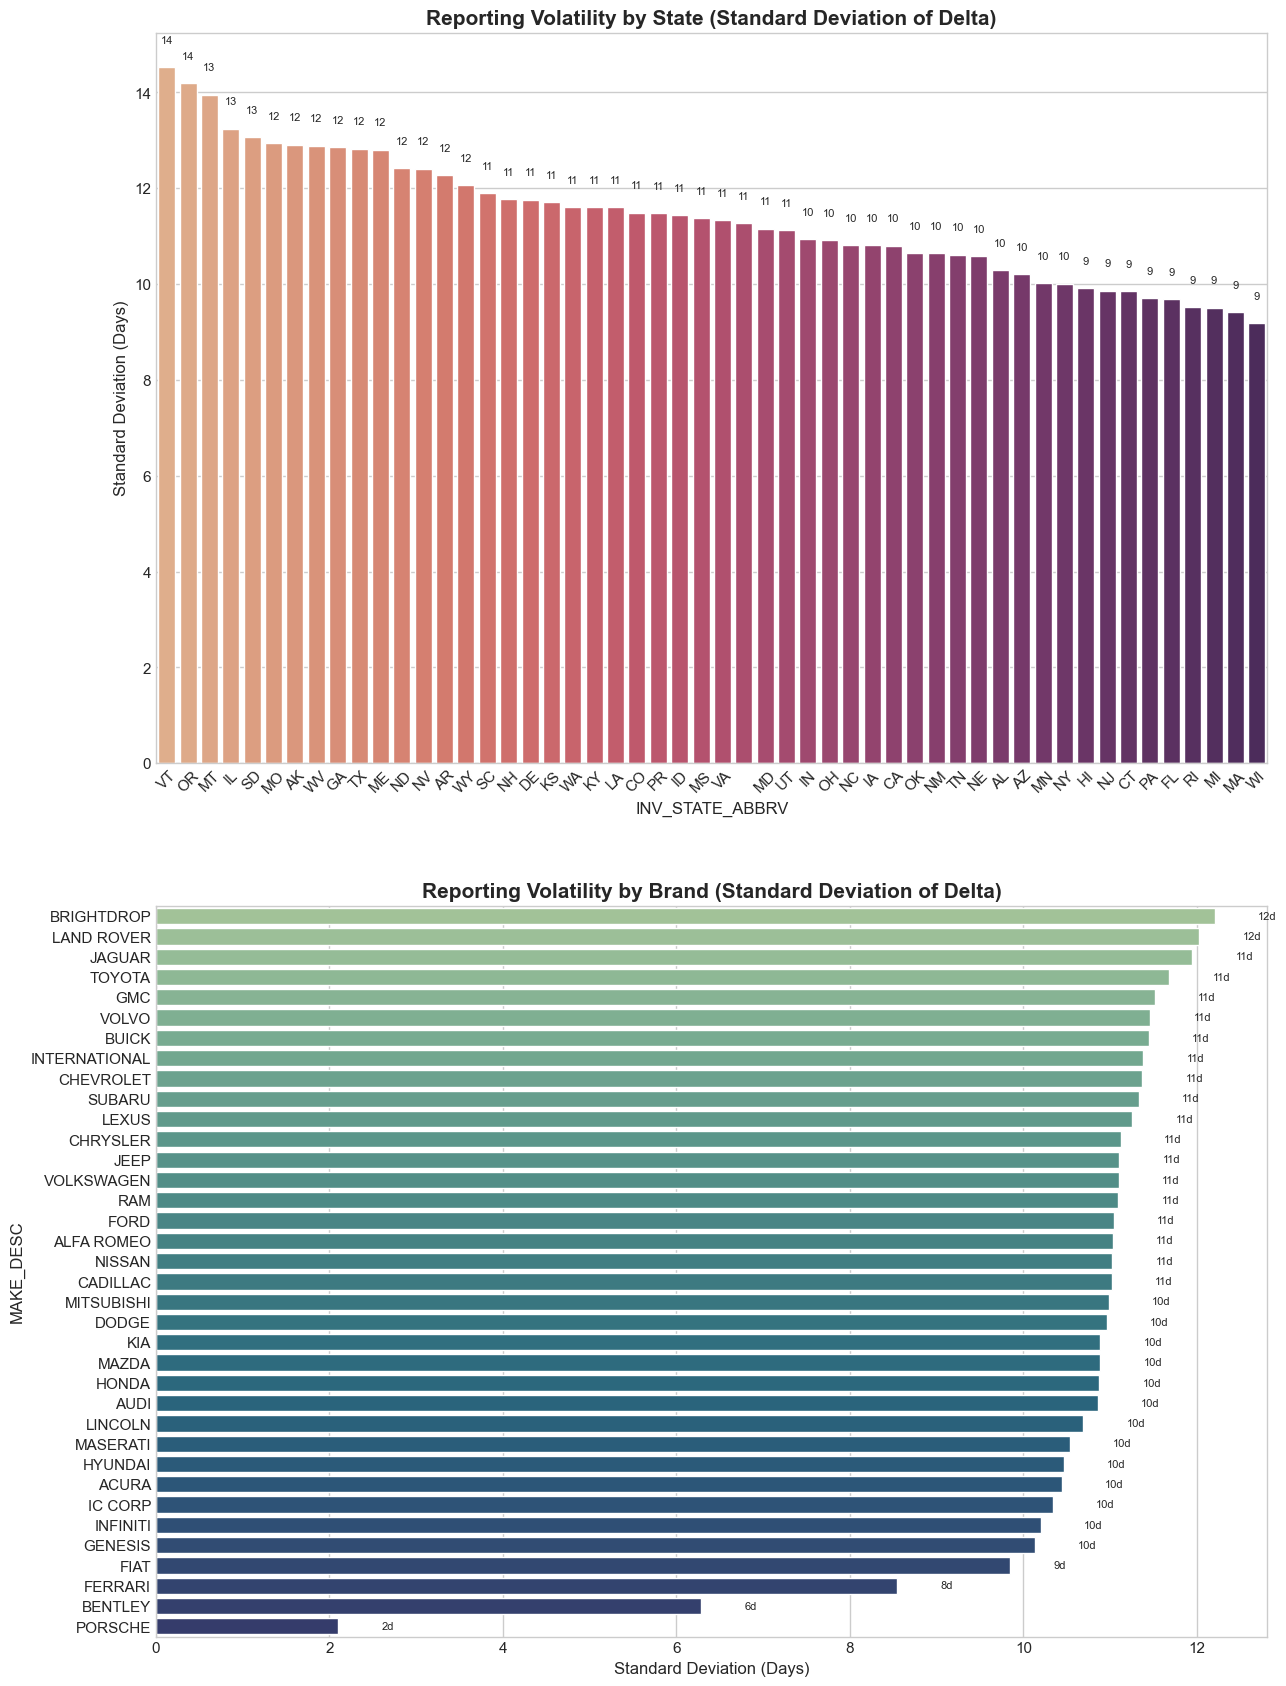

--- VOLATILITY SUMMARY ---
Most Unpredictable Brand: BRIGHTDROP (Std Dev: 12.2 days)
Most Consistent Brand:    PORSCHE (Std Dev: 2.1 days)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure columns are datetime and calculate delta with 1950 guardrail
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

cutoff_date = pd.Timestamp('1950-01-01')
mask = (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) & (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
temp_df = full_df_live[mask].copy()
temp_df['sls_nvi_delta_days'] = (temp_df['NVI_EFCTV_START_DT'] - temp_df['SLS_EFCTV_START_DT']).dt.days

# 2. Calculate Standard Deviations
state_std = temp_df.groupby('INV_STATE_ABBRV')['sls_nvi_delta_days'].std().sort_values(ascending=False)
make_std = temp_df.groupby('MAKE_DESC')['sls_nvi_delta_days'].std().sort_values(ascending=False)

# 3. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 18))
plt.style.use('seaborn-v0_8-whitegrid')

# Chart 1: Volatility by State
sns.barplot(x=state_std.index, y=state_std.values, ax=ax1, palette="flare")
ax1.set_title('Reporting Volatility by State (Standard Deviation of Delta)', fontsize=15, fontweight='bold')
ax1.set_ylabel('Standard Deviation (Days)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
# Add labels
for i, val in enumerate(state_std.values):
    if not pd.isna(val): ax1.text(i, val + 0.5, f'{int(val)}', ha='center', fontsize=8)

# Chart 2: Volatility by Make
sns.barplot(x=make_std.values, y=make_std.index, ax=ax2, palette="crest")
ax2.set_title('Reporting Volatility by Brand (Standard Deviation of Delta)', fontsize=15, fontweight='bold')
ax2.set_xlabel('Standard Deviation (Days)', fontsize=12)
# Add labels
for i, val in enumerate(make_std.values):
    if not pd.isna(val): ax2.text(val + 0.5, i, f'{int(val)}d', va='center', fontsize=8)

plt.tight_layout(pad=4.0)
plt.show()

# 4. Summary Output
print("--- VOLATILITY SUMMARY ---")
print(f"Most Unpredictable Brand: {make_std.index[0]} (Std Dev: {make_std.values[0]:.1f} days)")
print(f"Most Consistent Brand:    {make_std.index[-1]} (Std Dev: {make_std.values[-1]:.1f} days)")

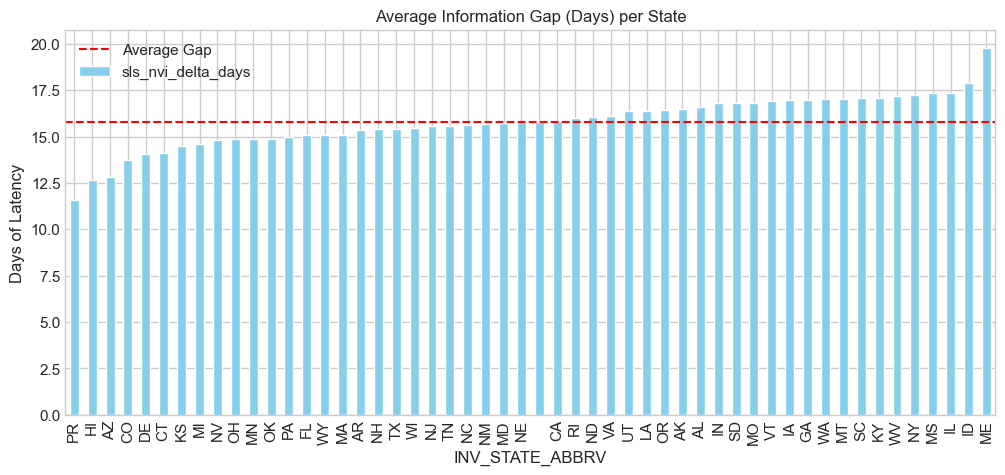

In [20]:
# Focus only on valid records for the meeting slide
valid_records = full_df_live[full_df_live['sls_nvi_delta_days'].between(-30, 180)]
state_gap = valid_records.groupby('INV_STATE_ABBRV')['sls_nvi_delta_days'].mean().sort_values()

plt.figure(figsize=(12, 5))
state_gap.plot(kind='bar', color='skyblue')
plt.title('Average Information Gap (Days) per State')
plt.ylabel('Days of Latency')
plt.axhline(state_gap.mean(), color='red', linestyle='--', label='Average Gap')
plt.legend()
plt.show()

                    NVI DATE AFTER SALES DATE ANALYSIS (VALID DATES ONLY)

📊 Data Validation Summary:
  Total rows in dataset:                   2,237,310
  Rows with all 4 dates valid:             1,694,919 ( 75.76%)
  Rows excluded from analysis:               542,391 ( 24.24%)

ANALYZING TEMPORAL RELATIONSHIPS (NVI vs SALES)

🎯 PRIMARY RESULT:
  Rows where ANY NVI date > ANY Sales date:
    Count:         1,687,613
    Percentage:        99.57%

  Rows where NO NVI date > ANY Sales date:
    Count:             7,306
    Percentage:         0.43%

📋 DETAILED BREAKDOWN (All 4 Combinations):

  NVI_EFCTV_START_DT > SLS_EFCTV_START_DT      
    TRUE:     1,687,231 ( 99.55%) █████████████████████████████████████████████████
    FALSE:        7,688 (  0.45%)

  NVI_EFCTV_START_DT > SLS_OWNSHP_DT           
    TRUE:     1,686,345 ( 99.49%) █████████████████████████████████████████████████
    FALSE:        8,574 (  0.51%)

  NVI_OWNSHP_DT > SLS_EFCTV_START_DT           
    TRUE:     1,35

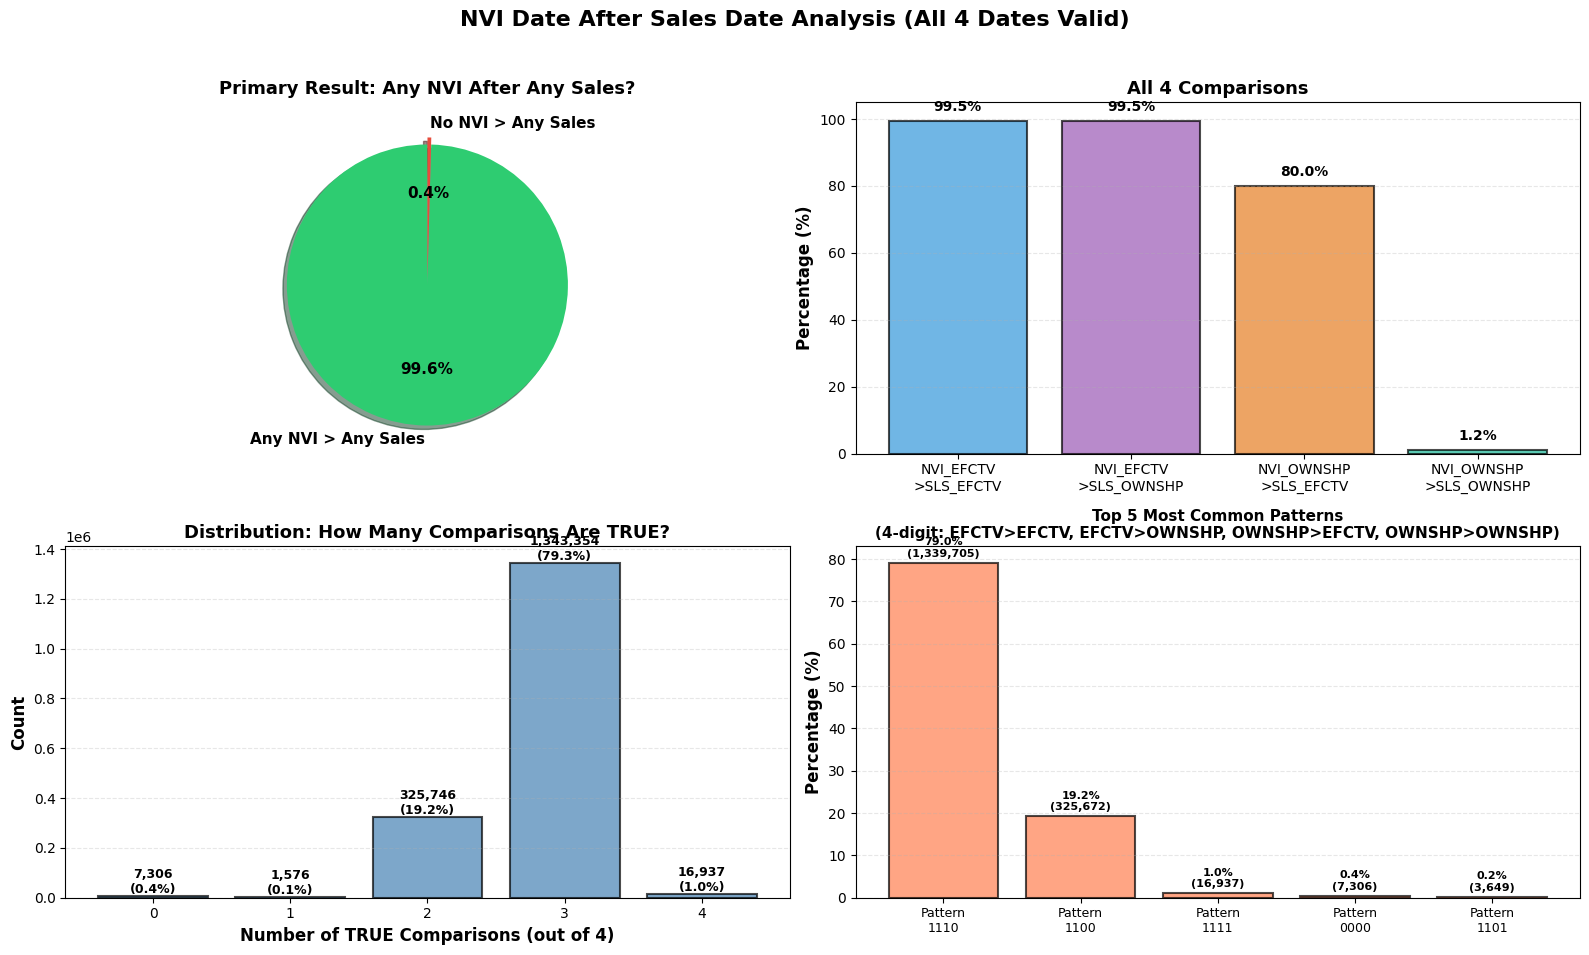


✓ Analysis complete!


In [13]:
# Analysis: NVI Date AFTER Sales Date (All 4 Dates Valid)
print("="*100)
print(" " * 20 + "NVI DATE AFTER SALES DATE ANALYSIS (VALID DATES ONLY)")
print("="*100)

# Define cutoff date for valid dates
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure all columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['SLS_OWNSHP_DT'] = pd.to_datetime(full_df_live['SLS_OWNSHP_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_OWNSHP_DT'] = pd.to_datetime(full_df_live['NVI_OWNSHP_DT'], errors='coerce')

# Identify rows where all 4 dates are valid (non-null AND >= 1950)
all_valid_mask = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['SLS_OWNSHP_DT'].notna()) & 
    (full_df_live['SLS_OWNSHP_DT'] >= cutoff_date) &
    (full_df_live['NVI_EFCTV_START_DT'].notna()) & 
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['NVI_OWNSHP_DT'].notna()) & 
    (full_df_live['NVI_OWNSHP_DT'] >= cutoff_date)
)

total_rows = len(full_df_live)
all_valid_count = all_valid_mask.sum()

print(f"\n📊 Data Validation Summary:")
print(f"  Total rows in dataset:                {total_rows:>12,}")
print(f"  Rows with all 4 dates valid:          {all_valid_count:>12,} ({100*all_valid_count/total_rows:>6.2f}%)")
print(f"  Rows excluded from analysis:          {total_rows - all_valid_count:>12,} ({100*(total_rows - all_valid_count)/total_rows:>6.2f}%)")

if all_valid_count > 0:
    # Filter to only valid rows
    valid_df = full_df_live[all_valid_mask].copy()
    
    print(f"\n{'='*100}")
    print("ANALYZING TEMPORAL RELATIONSHIPS (NVI vs SALES)")
    print(f"{'='*100}")
    
    # Create comparison flags for each combination
    # NVI_EFCTV_START_DT compared to both sales dates
    valid_df['nvi_efctv_after_sls_efctv'] = (valid_df['NVI_EFCTV_START_DT'] > valid_df['SLS_EFCTV_START_DT'])
    valid_df['nvi_efctv_after_sls_ownshp'] = (valid_df['NVI_EFCTV_START_DT'] > valid_df['SLS_OWNSHP_DT'])
    
    # NVI_OWNSHP_DT compared to both sales dates
    valid_df['nvi_ownshp_after_sls_efctv'] = (valid_df['NVI_OWNSHP_DT'] > valid_df['SLS_EFCTV_START_DT'])
    valid_df['nvi_ownshp_after_sls_ownshp'] = (valid_df['NVI_OWNSHP_DT'] > valid_df['SLS_OWNSHP_DT'])
    
    # Main question: At least one NVI date after at least one sales date
    valid_df['any_nvi_after_any_sls'] = (
        valid_df['nvi_efctv_after_sls_efctv'] | 
        valid_df['nvi_efctv_after_sls_ownshp'] | 
        valid_df['nvi_ownshp_after_sls_efctv'] | 
        valid_df['nvi_ownshp_after_sls_ownshp']
    )
    
    # Calculate statistics
    any_nvi_after_sls_count = valid_df['any_nvi_after_any_sls'].sum()
    any_nvi_after_sls_pct = 100 * any_nvi_after_sls_count / all_valid_count
    
    print(f"\n🎯 PRIMARY RESULT:")
    print(f"{'='*100}")
    print(f"  Rows where ANY NVI date > ANY Sales date:")
    print(f"    Count:      {any_nvi_after_sls_count:>12,}")
    print(f"    Percentage: {any_nvi_after_sls_pct:>12.2f}%")
    print(f"\n  Rows where NO NVI date > ANY Sales date:")
    print(f"    Count:      {all_valid_count - any_nvi_after_sls_count:>12,}")
    print(f"    Percentage: {100 - any_nvi_after_sls_pct:>12.2f}%")
    
    # Detailed breakdown
    print(f"\n📋 DETAILED BREAKDOWN (All 4 Combinations):")
    print(f"{'='*100}")
    
    comparisons = [
        ('NVI_EFCTV_START_DT > SLS_EFCTV_START_DT', 'nvi_efctv_after_sls_efctv'),
        ('NVI_EFCTV_START_DT > SLS_OWNSHP_DT', 'nvi_efctv_after_sls_ownshp'),
        ('NVI_OWNSHP_DT > SLS_EFCTV_START_DT', 'nvi_ownshp_after_sls_efctv'),
        ('NVI_OWNSHP_DT > SLS_OWNSHP_DT', 'nvi_ownshp_after_sls_ownshp')
    ]
    
    for label, col in comparisons:
        count = valid_df[col].sum()
        pct = 100 * count / all_valid_count
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"\n  {label:<45}")
        print(f"    TRUE:  {count:>12,} ({pct:>6.2f}%) {bar}")
        print(f"    FALSE: {all_valid_count - count:>12,} ({100-pct:>6.2f}%)")
    
    # Pattern analysis
    print(f"\n📊 PATTERN ANALYSIS:")
    print(f"{'='*100}")
    
    # Count how many comparisons are TRUE for each row
    valid_df['num_nvi_after_sls'] = (
        valid_df['nvi_efctv_after_sls_efctv'].astype(int) +
        valid_df['nvi_efctv_after_sls_ownshp'].astype(int) +
        valid_df['nvi_ownshp_after_sls_efctv'].astype(int) +
        valid_df['nvi_ownshp_after_sls_ownshp'].astype(int)
    )
    
    print(f"\nNumber of TRUE comparisons per row:")
    for i in range(5):
        count = (valid_df['num_nvi_after_sls'] == i).sum()
        pct = 100 * count / all_valid_count
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"  {i} of 4 comparisons TRUE: {count:>12,} ({pct:>6.2f}%) {bar}")
    
    # Specific pattern combinations
    print(f"\n🔍 SPECIFIC PATTERNS (Most Common):")
    print(f"{'='*100}")
    
    pattern_df = valid_df.groupby([
        'nvi_efctv_after_sls_efctv',
        'nvi_efctv_after_sls_ownshp',
        'nvi_ownshp_after_sls_efctv',
        'nvi_ownshp_after_sls_ownshp'
    ]).size().reset_index(name='count')
    pattern_df['percentage'] = 100 * pattern_df['count'] / all_valid_count
    pattern_df = pattern_df.sort_values('count', ascending=False)
    
    print(f"\nTop 10 most common patterns:")
    print(f"  {'NVI_EFCTV':<12} {'NVI_EFCTV':<12} {'NVI_OWNSHP':<12} {'NVI_OWNSHP':<12} {'Count':<15} {'Percentage':<12}")
    print(f"  {'>SLS_EFCTV':<12} {'>SLS_OWNSHP':<12} {'>SLS_EFCTV':<12} {'>SLS_OWNSHP':<12} {'':<15} {'':<12}")
    print(f"  {'-'*85}")
    
    for idx, row in pattern_df.head(10).iterrows():
        print(f"  {str(row['nvi_efctv_after_sls_efctv']):<12} "
              f"{str(row['nvi_efctv_after_sls_ownshp']):<12} "
              f"{str(row['nvi_ownshp_after_sls_efctv']):<12} "
              f"{str(row['nvi_ownshp_after_sls_ownshp']):<12} "
              f"{row['count']:>12,}   "
              f"{row['percentage']:>6.2f}%")
    
    # Visual summary
    print(f"\n{'='*100}")
    print("📈 VISUALIZATION")
    print(f"{'='*100}")
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('NVI Date After Sales Date Analysis (All 4 Dates Valid)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Primary result - pie chart
    ax1 = axes[0, 0]
    labels = ['Any NVI > Any Sales', 'No NVI > Any Sales']
    sizes = [any_nvi_after_sls_count, all_valid_count - any_nvi_after_sls_count]
    colors = ['#2ecc71', '#e74c3c']
    explode = (0.05, 0)
    
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax1.set_title('Primary Result: Any NVI After Any Sales?', fontsize=13, fontweight='bold')
    
    # 2. Bar chart - all 4 comparisons
    ax2 = axes[0, 1]
    comparison_labels = ['NVI_EFCTV\n>SLS_EFCTV', 'NVI_EFCTV\n>SLS_OWNSHP', 
                        'NVI_OWNSHP\n>SLS_EFCTV', 'NVI_OWNSHP\n>SLS_OWNSHP']
    comparison_counts = [valid_df[col].sum() for label, col in comparisons]
    comparison_pcts = [100 * c / all_valid_count for c in comparison_counts]
    
    bars = ax2.bar(range(4), comparison_pcts, color=['#3498db', '#9b59b6', '#e67e22', '#1abc9c'],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_title('All 4 Comparisons', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(4))
    ax2.set_xticklabels(comparison_labels, fontsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_ylim(0, 105)
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, comparison_pcts)):
        ax2.text(i, pct + 2, f"{pct:.1f}%", ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # 3. Pattern distribution
    ax3 = axes[1, 0]
    pattern_counts = [(valid_df['num_nvi_after_sls'] == i).sum() for i in range(5)]
    pattern_pcts = [100 * c / all_valid_count for c in pattern_counts]
    
    bars3 = ax3.bar(range(5), pattern_counts, color='steelblue', alpha=0.7, 
                    edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Number of TRUE Comparisons (out of 4)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax3.set_title('Distribution: How Many Comparisons Are TRUE?', fontsize=13, fontweight='bold')
    ax3.set_xticks(range(5))
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count and percentage labels
    for i, (count, pct) in enumerate(zip(pattern_counts, pattern_pcts)):
        ax3.text(i, count, f"{count:,}\n({pct:.1f}%)", ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # 4. Top 5 patterns
    ax4 = axes[1, 1]
    top5_patterns = pattern_df.head(5)
    pattern_names = []
    for idx, row in top5_patterns.iterrows():
        name = f"{int(row['nvi_efctv_after_sls_efctv'])}{int(row['nvi_efctv_after_sls_ownshp'])}" \
               f"{int(row['nvi_ownshp_after_sls_efctv'])}{int(row['nvi_ownshp_after_sls_ownshp'])}"
        pattern_names.append(f"Pattern\n{name}")
    
    bars4 = ax4.bar(range(len(top5_patterns)), top5_patterns['percentage'], 
                    color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Top 5 Most Common Patterns\n(4-digit: EFCTV>EFCTV, EFCTV>OWNSHP, OWNSHP>EFCTV, OWNSHP>OWNSHP)', 
                  fontsize=11, fontweight='bold')
    ax4.set_xticks(range(len(top5_patterns)))
    ax4.set_xticklabels(pattern_names, fontsize=9)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add percentage labels
    for i, (idx, row) in enumerate(top5_patterns.iterrows()):
        ax4.text(i, row['percentage'] + 1, f"{row['percentage']:.1f}%\n({row['count']:,})", 
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save figure
    chart_filename = 'nvi_after_sales_analysis.png'
    plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
    print(f"\n✓ Chart saved: {chart_filename}")
    
    plt.show()
    
else:
    print("\n⚠️  No rows found with all 4 dates valid for analysis")

print("\n" + "="*100)
print("✓ Analysis complete!")
print("="*100)

                    NVI_EFCTV_START_DT vs SLS_EFCTV_START_DT COMPARISON

📊 Data Validation Summary:
  Total rows in dataset:                   2,237,310
  Rows with both dates valid:              1,694,919 ( 75.76%)
  Rows excluded from analysis:               542,391 ( 24.24%)

🎯 PRIMARY RESULTS

  NVI_EFCTV_START_DT BEFORE SLS_EFCTV_START_DT:
    Count:             7,688
    Percentage:         0.45%
    

  NVI_EFCTV_START_DT SAME AS SLS_EFCTV_START_DT:
    Count:                 0
    Percentage:         0.00%
    

  NVI_EFCTV_START_DT AFTER SLS_EFCTV_START_DT:
    Count:         1,687,231
    Percentage:        99.55%
    █████████████████████████████████████████████████

📈 DELTA STATISTICS (NVI - SLS)

  Mean:                                        15.73 days
  Median:                                      14.00 days
  Std Dev:                                     11.20 days
  Min:                                           -46 days
  Max:                                           

C:\Users\LouisHaehle\AppData\Local\Temp\ipykernel_24864\1290793593.py:180: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([delta_series], vert=True, patch_artist=True,



✓ Chart saved: efctv_comparison_nvi_vs_sls.png


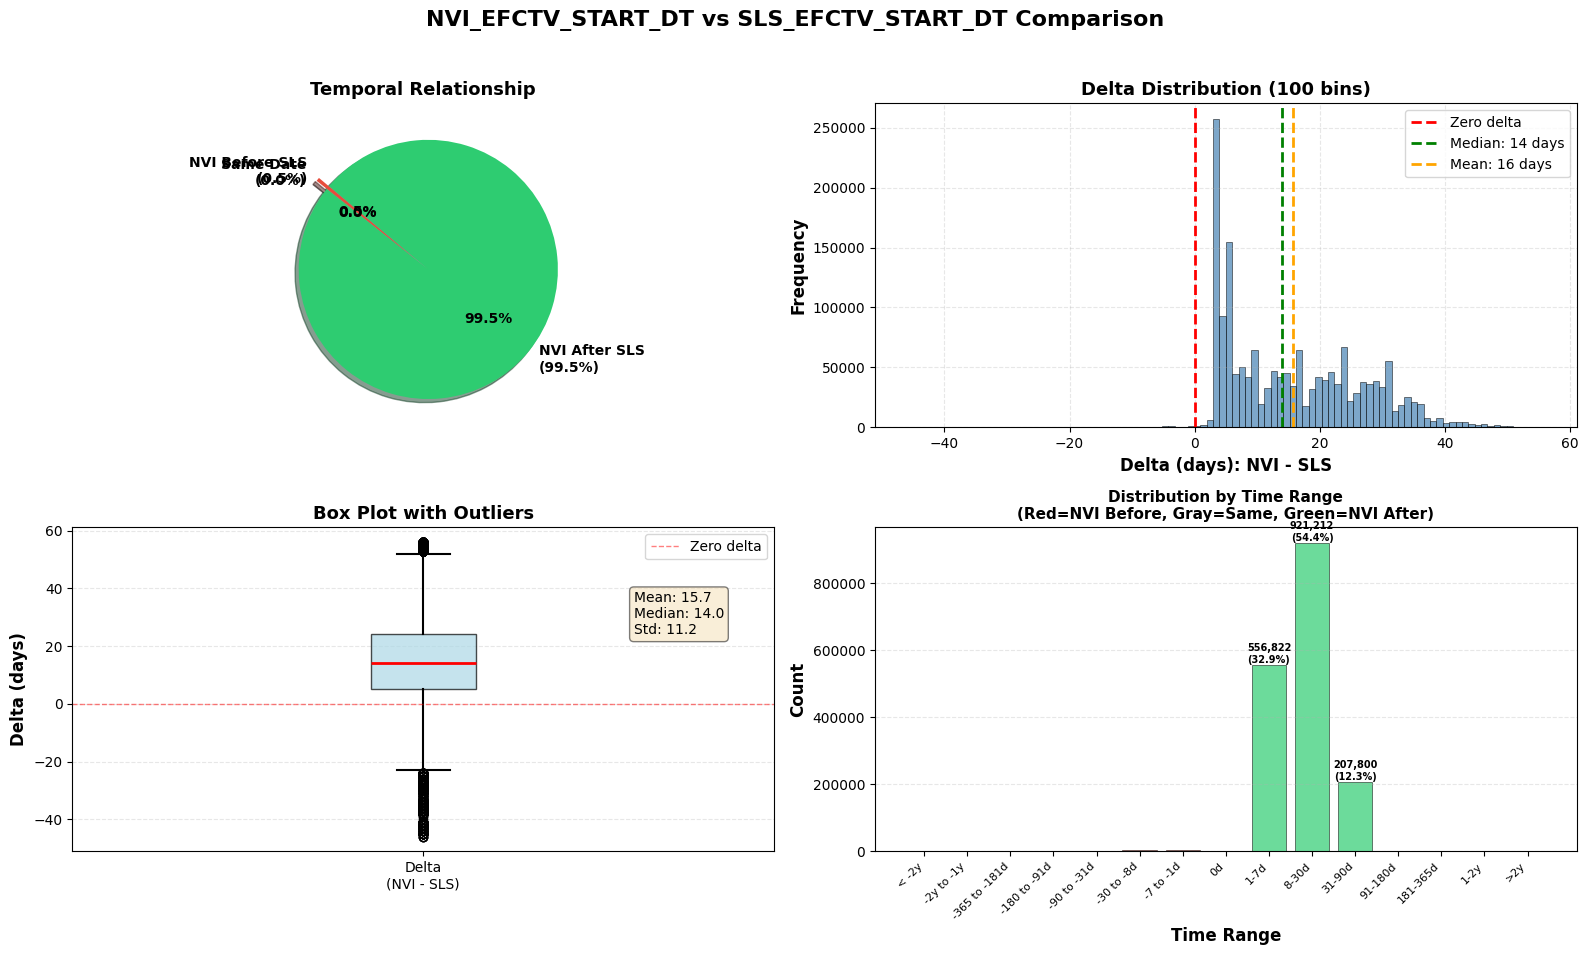


💡 KEY INSIGHTS

  ✓ Majority (99.5%) have NVI_EFCTV_START_DT AFTER SLS_EFCTV_START_DT
  ✓ Median delta is moderate (14 days)

✓ Analysis complete!


In [14]:
# Focused Analysis: NVI_EFCTV_START_DT vs SLS_EFCTV_START_DT
print("="*100)
print(" " * 20 + "NVI_EFCTV_START_DT vs SLS_EFCTV_START_DT COMPARISON")
print("="*100)

# Define cutoff date for valid dates
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure both columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# Identify rows where both dates are valid (non-null AND >= 1950)
both_valid_mask = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date) &
    (full_df_live['NVI_EFCTV_START_DT'].notna()) & 
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
)

total_rows = len(full_df_live)
both_valid_count = both_valid_mask.sum()

print(f"\n📊 Data Validation Summary:")
print(f"  Total rows in dataset:                {total_rows:>12,}")
print(f"  Rows with both dates valid:           {both_valid_count:>12,} ({100*both_valid_count/total_rows:>6.2f}%)")
print(f"  Rows excluded from analysis:          {total_rows - both_valid_count:>12,} ({100*(total_rows - both_valid_count)/total_rows:>6.2f}%)")

if both_valid_count > 0:
    # Filter to only valid rows
    valid_df = full_df_live[both_valid_mask].copy()
    
    # Calculate delta
    valid_df['efctv_delta_days'] = (valid_df['NVI_EFCTV_START_DT'] - valid_df['SLS_EFCTV_START_DT']).dt.days
    
    # Create comparison flags
    valid_df['nvi_before_sls'] = (valid_df['NVI_EFCTV_START_DT'] < valid_df['SLS_EFCTV_START_DT'])
    valid_df['nvi_same_as_sls'] = (valid_df['NVI_EFCTV_START_DT'] == valid_df['SLS_EFCTV_START_DT'])
    valid_df['nvi_after_sls'] = (valid_df['NVI_EFCTV_START_DT'] > valid_df['SLS_EFCTV_START_DT'])
    
    # Count each category
    nvi_before = valid_df['nvi_before_sls'].sum()
    nvi_same = valid_df['nvi_same_as_sls'].sum()
    nvi_after = valid_df['nvi_after_sls'].sum()
    
    nvi_before_pct = 100 * nvi_before / both_valid_count
    nvi_same_pct = 100 * nvi_same / both_valid_count
    nvi_after_pct = 100 * nvi_after / both_valid_count
    
    print(f"\n{'='*100}")
    print("🎯 PRIMARY RESULTS")
    print(f"{'='*100}")
    
    print(f"\n  NVI_EFCTV_START_DT BEFORE SLS_EFCTV_START_DT:")
    print(f"    Count:      {nvi_before:>12,}")
    print(f"    Percentage: {nvi_before_pct:>12.2f}%")
    bar_length = int(nvi_before_pct / 2)
    print(f"    {'█' * bar_length}")
    
    print(f"\n  NVI_EFCTV_START_DT SAME AS SLS_EFCTV_START_DT:")
    print(f"    Count:      {nvi_same:>12,}")
    print(f"    Percentage: {nvi_same_pct:>12.2f}%")
    bar_length = int(nvi_same_pct / 2)
    print(f"    {'█' * bar_length}")
    
    print(f"\n  NVI_EFCTV_START_DT AFTER SLS_EFCTV_START_DT:")
    print(f"    Count:      {nvi_after:>12,}")
    print(f"    Percentage: {nvi_after_pct:>12.2f}%")
    bar_length = int(nvi_after_pct / 2)
    print(f"    {'█' * bar_length}")
    
    # Delta statistics
    print(f"\n{'='*100}")
    print("📈 DELTA STATISTICS (NVI - SLS)")
    print(f"{'='*100}")
    
    delta_series = valid_df['efctv_delta_days']
    
    print(f"\n  Mean:                                 {delta_series.mean():>12.2f} days")
    print(f"  Median:                               {delta_series.median():>12.2f} days")
    print(f"  Std Dev:                              {delta_series.std():>12.2f} days")
    print(f"  Min:                                  {delta_series.min():>12.0f} days")
    print(f"  Max:                                  {delta_series.max():>12.0f} days")
    
    # Percentiles
    print(f"\n  Key Percentiles:")
    key_percentiles = [5, 25, 50, 75, 95]
    for p in key_percentiles:
        val = delta_series.quantile(p/100)
        print(f"    {p:>3}th percentile: {val:>12.2f} days")
    
    # Range distribution
    print(f"\n{'='*100}")
    print("📊 DELTA RANGE DISTRIBUTION")
    print(f"{'='*100}")
    
    ranges = [
        ('Same day (0 days)', 0, 0),
        ('1-7 days', 1, 7),
        ('8-30 days', 8, 30),
        ('31-90 days', 31, 90),
        ('91-180 days', 91, 180),
        ('181-365 days', 181, 365),
        ('1-2 years', 366, 730),
        ('2+ years', 731, float('inf'))
    ]
    
    print(f"\nPositive Delta (NVI after SLS):")
    for label, min_days, max_days in ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / both_valid_count
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%) {bar}")
    
    print(f"\nNegative Delta (NVI before SLS):")
    neg_ranges = [
        ('0 to -7 days', -7, -1),
        ('-8 to -30 days', -30, -8),
        ('-31 to -90 days', -90, -31),
        ('-91 to -180 days', -180, -91),
        ('-181 to -365 days', -365, -181),
        ('-1 to -2 years', -730, -366),
        ('< -2 years', float('-inf'), -731)
    ]
    
    for label, min_days, max_days in neg_ranges:
        if min_days == float('-inf'):
            count = ((delta_series <= max_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        pct = 100 * count / both_valid_count
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        print(f"  {label:<25} {count:>12,} ({pct:>6.2f}%) {bar}")
    
    # Visualization
    print(f"\n{'='*100}")
    print("📈 CREATING VISUALIZATIONS")
    print(f"{'='*100}")
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('NVI_EFCTV_START_DT vs SLS_EFCTV_START_DT Comparison', 
                 fontsize=16, fontweight='bold')
    
    # 1. Pie chart - temporal relationship
    ax1 = axes[0, 0]
    labels = [f'NVI Before SLS\n({nvi_before_pct:.1f}%)', 
              f'Same Date\n({nvi_same_pct:.1f}%)', 
              f'NVI After SLS\n({nvi_after_pct:.1f}%)']
    sizes = [nvi_before, nvi_same, nvi_after]
    colors = ['#e74c3c', '#95a5a6', '#2ecc71']
    explode = (0.05, 0.05, 0.05)
    
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140, textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax1.set_title('Temporal Relationship', fontsize=13, fontweight='bold')
    
    # 2. Histogram - delta distribution
    ax2 = axes[0, 1]
    ax2.hist(delta_series, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero delta')
    ax2.axvline(x=delta_series.median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {delta_series.median():.0f} days')
    ax2.axvline(x=delta_series.mean(), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {delta_series.mean():.0f} days')
    ax2.set_xlabel('Delta (days): NVI - SLS', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Delta Distribution (100 bins)', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, linestyle='--')
    
    # 3. Box plot
    ax3 = axes[1, 0]
    bp = ax3.boxplot([delta_series], vert=True, patch_artist=True, 
                      labels=['Delta\n(NVI - SLS)'],
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5))
    ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero delta')
    ax3.set_ylabel('Delta (days)', fontsize=12, fontweight='bold')
    ax3.set_title('Box Plot with Outliers', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.legend()
    
    # Add statistics text
    stats_text = f"Mean: {delta_series.mean():.1f}\nMedian: {delta_series.median():.1f}\nStd: {delta_series.std():.1f}"
    ax3.text(1.3, delta_series.quantile(0.75), stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 4. Range distribution bar chart
    ax4 = axes[1, 1]
    
    # Combine positive and negative ranges
    all_ranges = [
        ('< -2y', float('-inf'), -731),
        ('-2y to -1y', -730, -366),
        ('-365 to -181d', -365, -181),
        ('-180 to -91d', -180, -91),
        ('-90 to -31d', -90, -31),
        ('-30 to -8d', -30, -8),
        ('-7 to -1d', -7, -1),
        ('0d', 0, 0),
        ('1-7d', 1, 7),
        ('8-30d', 8, 30),
        ('31-90d', 31, 90),
        ('91-180d', 91, 180),
        ('181-365d', 181, 365),
        ('1-2y', 366, 730),
        ('>2y', 731, float('inf'))
    ]
    
    range_labels = []
    range_counts = []
    range_colors = []
    
    for label, min_days, max_days in all_ranges:
        if max_days == float('inf'):
            count = ((delta_series >= min_days)).sum()
        elif min_days == float('-inf'):
            count = ((delta_series <= max_days)).sum()
        else:
            count = ((delta_series >= min_days) & (delta_series <= max_days)).sum()
        range_labels.append(label)
        range_counts.append(count)
        
        # Color based on range
        if min_days < 0 and max_days < 0:
            range_colors.append('#e74c3c')  # Red for NVI before SLS
        elif min_days == 0 and max_days == 0:
            range_colors.append('#95a5a6')  # Gray for same day
        else:
            range_colors.append('#2ecc71')  # Green for NVI after SLS
    
    bars = ax4.bar(range(len(range_labels)), range_counts, color=range_colors, 
                   alpha=0.7, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Time Range', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax4.set_title('Distribution by Time Range\n(Red=NVI Before, Gray=Same, Green=NVI After)', 
                  fontsize=11, fontweight='bold')
    ax4.set_xticks(range(len(range_labels)))
    ax4.set_xticklabels(range_labels, rotation=45, ha='right', fontsize=8)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count labels for significant bars
    for i, count in enumerate(range_counts):
        if count > both_valid_count * 0.02:  # Only label if > 2% of total
            pct = 100 * count / both_valid_count
            ax4.text(i, count, f"{count:,}\n({pct:.1f}%)", 
                    ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save figure
    chart_filename = 'efctv_comparison_nvi_vs_sls.png'
    plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
    print(f"\n✓ Chart saved: {chart_filename}")
    
    plt.show()
    
    # Summary insights
    print(f"\n{'='*100}")
    print("💡 KEY INSIGHTS")
    print(f"{'='*100}")
    
    if nvi_after_pct > 50:
        print(f"\n  ✓ Majority ({nvi_after_pct:.1f}%) have NVI_EFCTV_START_DT AFTER SLS_EFCTV_START_DT")
    elif nvi_before_pct > 50:
        print(f"\n  ✓ Majority ({nvi_before_pct:.1f}%) have NVI_EFCTV_START_DT BEFORE SLS_EFCTV_START_DT")
    else:
        print(f"\n  ✓ No clear majority - dates are relatively balanced")
    
    if abs(delta_series.median()) <= 7:
        print(f"  ✓ Median delta is small ({delta_series.median():.0f} days) - dates are typically close")
    elif abs(delta_series.median()) <= 30:
        print(f"  ✓ Median delta is moderate ({delta_series.median():.0f} days)")
    else:
        print(f"  ✓ Median delta is large ({delta_series.median():.0f} days) - significant time difference")
    
    if nvi_same_pct > 10:
        print(f"  ✓ Notable portion ({nvi_same_pct:.1f}%) have identical dates")
    
else:
    print("\n⚠️  No rows found with both dates valid for analysis")

print("\n" + "="*100)
print("✓ Analysis complete!")
print("="*100)

                    COVERAGE COMBINATION ANALYSIS
               Sales | Registration | Inventory

📋 Coverage Definitions:
  Sales (SLS):         SLS_EFCTV_START_DT is not null AND >= 1950-01-01
  Registration (REG):  NVI_EFCTV_START_DT is not null AND >= 1950-01-01
  Inventory (INV):     INV_CENSUS_TRACT is not null AND not empty string

📊 COVERAGE COMBINATIONS TABLE

Total rows in dataset: 2,237,310

  #   Sales   Reg     Inv     Coverage Types                 Count           Percentage   Visual              
  --------------------------------------------------------------------------------------------------------------
  1   ✓       ✓       ✓       Sales + Registration + Inventory    1,615,015    72.19%     ████████████████████████████████████
  2   ✗       ✓       ✓       Registration + Inventory            282,472    12.63%     ██████
  3   ✓       ✗       ✓       Sales + Inventory                   124,825     5.58%     ██
  4   ✗       ✓       ✗       Registration               

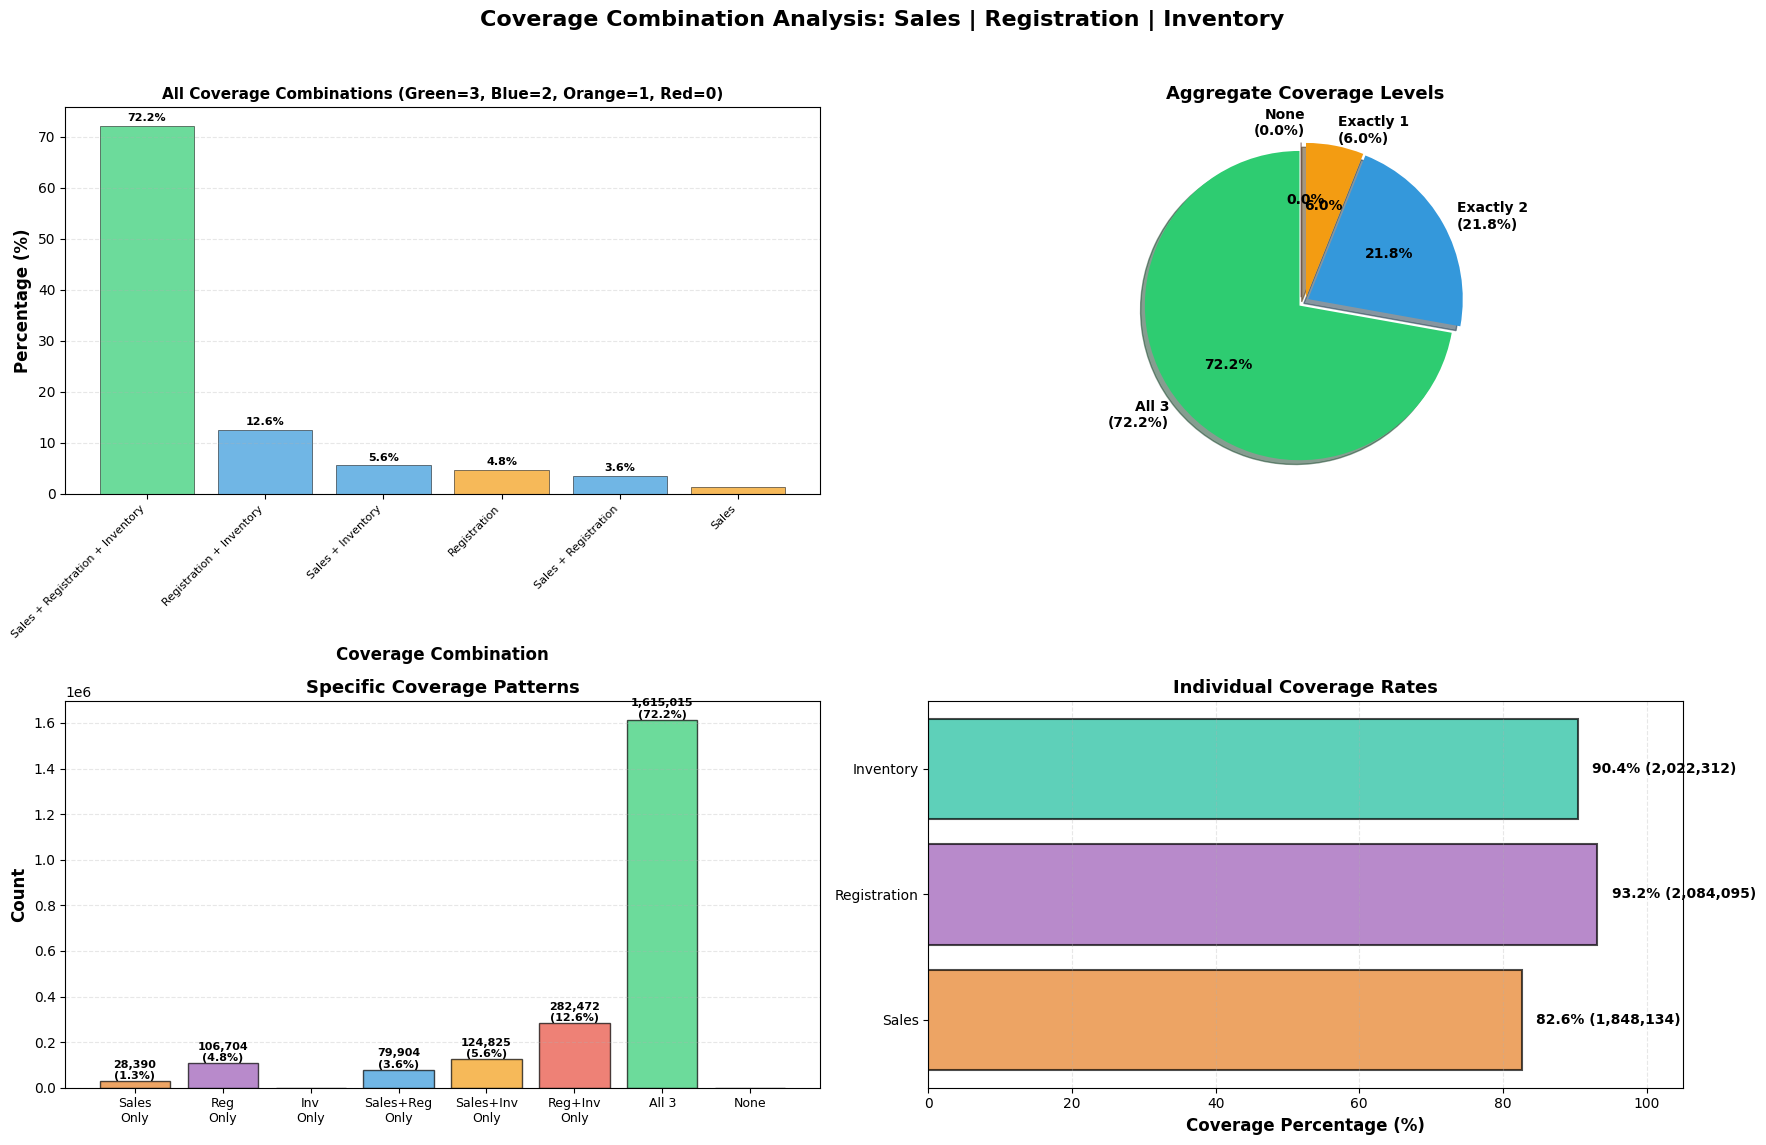


✓ Coverage combination analysis complete!


In [16]:
# Coverage Combination Analysis: Sales, Registration, and Inventory
print("="*100)
print(" " * 20 + "COVERAGE COMBINATION ANALYSIS")
print(" " * 15 + "Sales | Registration | Inventory")
print("="*100)

# Define cutoff date for valid dates
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure date columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# Define coverage flags
print("\n📋 Coverage Definitions:")
print("  Sales (SLS):         SLS_EFCTV_START_DT is not null AND >= 1950-01-01")
print("  Registration (REG):  NVI_EFCTV_START_DT is not null AND >= 1950-01-01")
print("  Inventory (INV):     INV_CENSUS_TRACT is not null AND not empty string")

# Create coverage flags
full_df_live['has_sales_coverage'] = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date)
)

full_df_live['has_registration_coverage'] = (
    (full_df_live['NVI_EFCTV_START_DT'].notna()) & 
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
)

full_df_live['has_inventory_coverage'] = (
    (full_df_live['INV_CENSUS_TRACT'].notna()) & 
    (full_df_live['INV_CENSUS_TRACT'] != '')
)

# Calculate total rows
total_rows = len(full_df_live)

# Group by all three coverage flags
coverage_combinations = full_df_live.groupby([
    'has_sales_coverage',
    'has_registration_coverage',
    'has_inventory_coverage'
]).size().reset_index(name='count')

coverage_combinations['percentage'] = (coverage_combinations['count'] / total_rows) * 100

# Sort by count descending
coverage_combinations = coverage_combinations.sort_values('count', ascending=False)

# Create readable labels
def create_label(row):
    parts = []
    if row['has_sales_coverage']:
        parts.append('Sales')
    if row['has_registration_coverage']:
        parts.append('Registration')
    if row['has_inventory_coverage']:
        parts.append('Inventory')
    
    if len(parts) == 0:
        return 'None'
    return ' + '.join(parts)

coverage_combinations['coverage_label'] = coverage_combinations.apply(create_label, axis=1)

# Create binary representation for easy reading
def create_binary(row):
    s = '✓' if row['has_sales_coverage'] else '✗'
    r = '✓' if row['has_registration_coverage'] else '✗'
    i = '✓' if row['has_inventory_coverage'] else '✗'
    return f"{s} | {r} | {i}"

coverage_combinations['binary'] = coverage_combinations.apply(create_binary, axis=1)

print(f"\n{'='*100}")
print("📊 COVERAGE COMBINATIONS TABLE")
print(f"{'='*100}")

print(f"\nTotal rows in dataset: {total_rows:,}\n")

print(f"  {'#':<3} {'Sales':<7} {'Reg':<7} {'Inv':<7} {'Coverage Types':<30} {'Count':<15} {'Percentage':<12} {'Visual':<20}")
print(f"  {'-'*110}")

for idx, row in coverage_combinations.iterrows():
    visual_pct = row['percentage']
    bar_length = int(visual_pct / 2)
    bar = '█' * bar_length
    
    num = coverage_combinations.index.get_loc(idx) + 1
    s_mark = '✓' if row['has_sales_coverage'] else '✗'
    r_mark = '✓' if row['has_registration_coverage'] else '✗'
    i_mark = '✓' if row['has_inventory_coverage'] else '✗'
    
    print(f"  {num:<3} {s_mark:<7} {r_mark:<7} {i_mark:<7} {row['coverage_label']:<30} "
          f"{row['count']:>12,}   {row['percentage']:>6.2f}%     {bar}")

# Summary statistics
print(f"\n{'='*100}")
print("📈 SUMMARY STATISTICS")
print(f"{'='*100}")

# Calculate key combinations
all_three = coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

at_least_two = coverage_combinations[
    ((coverage_combinations['has_sales_coverage'].astype(int) +
      coverage_combinations['has_registration_coverage'].astype(int) +
      coverage_combinations['has_inventory_coverage'].astype(int)) >= 2)
]['count'].sum()

at_least_one = coverage_combinations[
    ((coverage_combinations['has_sales_coverage']) |
     (coverage_combinations['has_registration_coverage']) |
     (coverage_combinations['has_inventory_coverage']))
]['count'].sum()

none = coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

print(f"\nAggregate Coverage:")
print(f"  All 3 types covered:              {all_three:>12,} ({100*all_three/total_rows:>6.2f}%)")
print(f"  At least 2 types covered:         {at_least_two:>12,} ({100*at_least_two/total_rows:>6.2f}%)")
print(f"  At least 1 type covered:          {at_least_one:>12,} ({100*at_least_one/total_rows:>6.2f}%)")
print(f"  No coverage (none):               {none:>12,} ({100*none/total_rows:>6.2f}%)")

# Individual coverage rates
sales_total = full_df_live['has_sales_coverage'].sum()
reg_total = full_df_live['has_registration_coverage'].sum()
inv_total = full_df_live['has_inventory_coverage'].sum()

print(f"\nIndividual Coverage Rates:")
print(f"  Sales coverage:                   {sales_total:>12,} ({100*sales_total/total_rows:>6.2f}%)")
print(f"  Registration coverage:            {reg_total:>12,} ({100*reg_total/total_rows:>6.2f}%)")
print(f"  Inventory coverage:               {inv_total:>12,} ({100*inv_total/total_rows:>6.2f}%)")

# Visualization
print(f"\n{'='*100}")
print("📊 CREATING VISUALIZATIONS")
print(f"{'='*100}")

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Coverage Combination Analysis: Sales | Registration | Inventory', 
             fontsize=16, fontweight='bold')

# 1. Bar chart - all combinations
ax1 = axes[0, 0]
x_pos = range(len(coverage_combinations))
colors_map = []
for idx, row in coverage_combinations.iterrows():
    count = sum([row['has_sales_coverage'], row['has_registration_coverage'], row['has_inventory_coverage']])
    if count == 3:
        colors_map.append('#2ecc71')  # Green - all three
    elif count == 2:
        colors_map.append('#3498db')  # Blue - two
    elif count == 1:
        colors_map.append('#f39c12')  # Orange - one
    else:
        colors_map.append('#e74c3c')  # Red - none

bars1 = ax1.bar(x_pos, coverage_combinations['percentage'], color=colors_map, 
                alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Coverage Combination', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('All Coverage Combinations (Green=3, Blue=2, Orange=1, Red=0)', 
              fontsize=11, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(coverage_combinations['coverage_label'], rotation=45, ha='right', fontsize=8)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels for significant bars
for i, (idx, row) in enumerate(coverage_combinations.iterrows()):
    if row['percentage'] > 2:  # Only label if > 2%
        ax1.text(i, row['percentage'] + 0.5, f"{row['percentage']:.1f}%", 
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Pie chart - aggregate summary
ax2 = axes[0, 1]
aggregate_labels = [
    f'All 3\n({100*all_three/total_rows:.1f}%)',
    f'Exactly 2\n({100*(at_least_two-all_three)/total_rows:.1f}%)',
    f'Exactly 1\n({100*(at_least_one-at_least_two)/total_rows:.1f}%)',
    f'None\n({100*none/total_rows:.1f}%)'
]
aggregate_sizes = [all_three, at_least_two-all_three, at_least_one-at_least_two, none]
aggregate_colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
explode = (0.05, 0.02, 0.02, 0.05)

ax2.pie(aggregate_sizes, explode=explode, labels=aggregate_labels, colors=aggregate_colors,
        autopct='%1.1f%%', shadow=True, startangle=90, 
        textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Aggregate Coverage Levels', fontsize=13, fontweight='bold')

# 3. Venn-style stacked bar
ax3 = axes[1, 0]
coverage_types = ['Sales\nOnly', 'Reg\nOnly', 'Inv\nOnly', 
                  'Sales+Reg\nOnly', 'Sales+Inv\nOnly', 'Reg+Inv\nOnly', 
                  'All 3', 'None']
coverage_counts = []

# Sales only
sales_only = coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

# Reg only
reg_only = coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

# Inv only
inv_only = coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

# Sales + Reg only
sales_reg_only = coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (~coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

# Sales + Inv only
sales_inv_only = coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (coverage_combinations['has_sales_coverage']) &
    (~coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

# Reg + Inv only
reg_inv_only = coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]['count'].sum() if len(coverage_combinations[
    (~coverage_combinations['has_sales_coverage']) &
    (coverage_combinations['has_registration_coverage']) &
    (coverage_combinations['has_inventory_coverage'])
]) > 0 else 0

coverage_counts = [sales_only, reg_only, inv_only, sales_reg_only, 
                   sales_inv_only, reg_inv_only, all_three, none]
coverage_pcts = [100 * c / total_rows for c in coverage_counts]

colors3 = ['#e67e22', '#9b59b6', '#1abc9c', '#3498db', '#f39c12', '#e74c3c', '#2ecc71', '#95a5a6']
bars3 = ax3.bar(range(len(coverage_types)), coverage_counts, color=colors3, 
                alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Specific Coverage Patterns', fontsize=13, fontweight='bold')
ax3.set_xticks(range(len(coverage_types)))
ax3.set_xticklabels(coverage_types, fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels
for i, (count, pct) in enumerate(zip(coverage_counts, coverage_pcts)):
    if count > 0:
        ax3.text(i, count, f"{count:,}\n({pct:.1f}%)", ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

# 4. Individual coverage rates comparison
ax4 = axes[1, 1]
individual_labels = ['Sales', 'Registration', 'Inventory']
individual_counts = [sales_total, reg_total, inv_total]
individual_pcts = [100*sales_total/total_rows, 100*reg_total/total_rows, 100*inv_total/total_rows]

bars4 = ax4.barh(individual_labels, individual_pcts, color=['#e67e22', '#9b59b6', '#1abc9c'],
                 alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Coverage Percentage (%)', fontsize=12, fontweight='bold')
ax4.set_title('Individual Coverage Rates', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3, linestyle='--')
ax4.set_xlim(0, 105)

# Add percentage and count labels
for i, (pct, count) in enumerate(zip(individual_pcts, individual_counts)):
    ax4.text(pct + 2, i, f"{pct:.1f}% ({count:,})", va='center', 
            fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
chart_filename = 'coverage_combinations_analysis.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Chart saved: {chart_filename}")

plt.show()

print("\n" + "="*100)
print("✓ Coverage combination analysis complete!")
print("="*100)

                                   SLS_DEALER_FLAG ANALYSIS

Column Information:
  Data type: object
  Total rows: 2,237,310

  Null values:                0 (  0.00%)
  Non-null values:    2,237,310 (100.00%)

VALUE DISTRIBUTION

Unique values and their frequencies:
  Value                Count           Percentage      Visual                        
  --------------------------------------------------------------------------------
  N                       1,749,412    78.19%        ███████████████████████████████████████
                            389,176    17.39%        ████████
  Y                          98,722     4.41%        ██

FLAG INTERPRETATION

Unique non-null values: ['', 'N', 'Y']

  Flag SET (True/1/Y/Yes):           98,722 (  4.41%)
  Flag NOT SET:                   2,138,588 ( 95.59%)
  Flag NULL/Missing:                      0 (  0.00%)

CREATING VISUALIZATION

✓ Chart saved: sls_dealer_flag_distribution.png


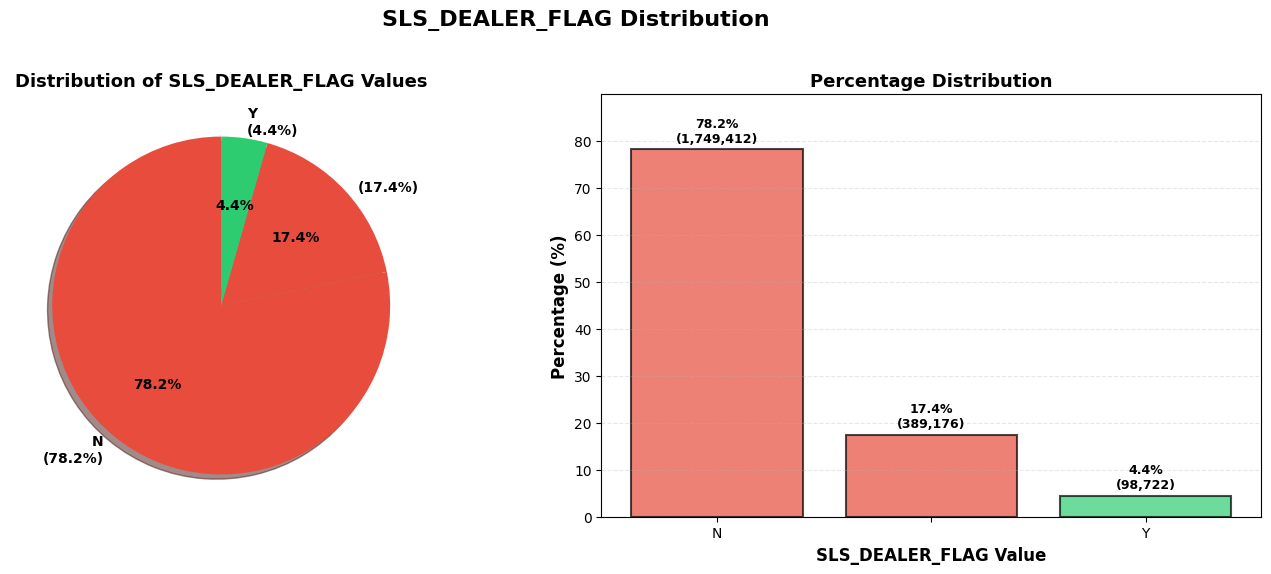


✓ SLS_DEALER_FLAG analysis complete!


In [4]:
# SLS_DEALER_FLAG Analysis
print("="*100)
print(" " * 35 + "SLS_DEALER_FLAG ANALYSIS")
print("="*100)

total_rows = len(full_df_live)

# Check data type and values
print(f"\nColumn Information:")
print(f"  Data type: {full_df_live['SLS_DEALER_FLAG'].dtype}")
print(f"  Total rows: {total_rows:,}")

# Check for nulls
null_count = full_df_live['SLS_DEALER_FLAG'].isna().sum()
non_null_count = full_df_live['SLS_DEALER_FLAG'].notna().sum()
null_pct = 100 * null_count / total_rows
non_null_pct = 100 * non_null_count / total_rows

print(f"\n  Null values:     {null_count:>12,} ({null_pct:>6.2f}%)")
print(f"  Non-null values: {non_null_count:>12,} ({non_null_pct:>6.2f}%)")

# Value counts
print(f"\n{'='*100}")
print("VALUE DISTRIBUTION")
print(f"{'='*100}")

value_counts = full_df_live['SLS_DEALER_FLAG'].value_counts(dropna=False)
print(f"\nUnique values and their frequencies:")
print(f"  {'Value':<20} {'Count':<15} {'Percentage':<15} {'Visual':<30}")
print(f"  {'-'*80}")

for value, count in value_counts.items():
    pct = 100 * count / total_rows
    bar_length = int(pct / 2)
    bar = '█' * bar_length
    value_str = str(value) if pd.notna(value) else 'NULL'
    print(f"  {value_str:<20} {count:>12,}   {pct:>6.2f}%        {bar}")

# If it's a boolean or binary flag
if full_df_live['SLS_DEALER_FLAG'].dtype in ['bool', 'object', 'int64']:
    print(f"\n{'='*100}")
    print("FLAG INTERPRETATION")
    print(f"{'='*100}")
    
    # Check for True/False, 1/0, Y/N, etc.
    unique_values = full_df_live['SLS_DEALER_FLAG'].dropna().unique()
    print(f"\nUnique non-null values: {sorted([str(v) for v in unique_values])}")
    
    # Try to interpret as flag set/not set
    # Common flag values: True, 1, 'Y', 'Yes', etc.
    flag_set_values = [True, 1, '1', 'Y', 'y', 'Yes', 'YES', 'yes', 'T', 't', 'True', 'TRUE', 'true']
    flag_set = full_df_live['SLS_DEALER_FLAG'].isin(flag_set_values).sum()
    flag_set_pct = 100 * flag_set / total_rows
    
    flag_not_set = total_rows - flag_set - null_count
    flag_not_set_pct = 100 * flag_not_set / total_rows
    
    if flag_set > 0:
        print(f"\n  Flag SET (True/1/Y/Yes):     {flag_set:>12,} ({flag_set_pct:>6.2f}%)")
        print(f"  Flag NOT SET:                {flag_not_set:>12,} ({flag_not_set_pct:>6.2f}%)")
        print(f"  Flag NULL/Missing:           {null_count:>12,} ({null_pct:>6.2f}%)")

# Visualization
print(f"\n{'='*100}")
print("CREATING VISUALIZATION")
print(f"{'='*100}")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('SLS_DEALER_FLAG Distribution', fontsize=16, fontweight='bold')

# 1. Pie chart
ax1 = axes[0]
pie_labels = []
pie_sizes = []
pie_colors = []

for value, count in value_counts.items():
    value_str = str(value) if pd.notna(value) else 'NULL'
    pct = 100 * count / total_rows
    pie_labels.append(f'{value_str}\n({pct:.1f}%)')
    pie_sizes.append(count)
    
    # Color coding
    if pd.isna(value):
        pie_colors.append('#95a5a6')  # Gray for NULL
    elif value in [True, 1, '1', 'Y', 'Yes', 'YES']:
        pie_colors.append('#2ecc71')  # Green for set
    else:
        pie_colors.append('#e74c3c')  # Red for not set

ax1.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('Distribution of SLS_DEALER_FLAG Values', fontsize=13, fontweight='bold')

# 2. Bar chart
ax2 = axes[1]
x_pos = range(len(value_counts))
bar_labels = [str(v) if pd.notna(v) else 'NULL' for v in value_counts.index]
bar_counts = value_counts.values
bar_pcts = [100 * c / total_rows for c in bar_counts]

bars = ax2.bar(x_pos, bar_pcts, color=pie_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('SLS_DEALER_FLAG Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage Distribution', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(bar_labels, rotation=0 if len(bar_labels) <= 3 else 45, ha='right' if len(bar_labels) > 3 else 'center')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(bar_pcts) * 1.15)

# Add percentage and count labels
for i, (pct, count) in enumerate(zip(bar_pcts, bar_counts)):
    ax2.text(i, pct + 1, f"{pct:.1f}%\n({count:,})", ha='center', va='bottom', 
            fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
chart_filename = 'sls_dealer_flag_distribution.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Chart saved: {chart_filename}")

plt.show()

print("\n" + "="*100)
print("✓ SLS_DEALER_FLAG analysis complete!")
print("="*100)

                                   SLS_CENSUS_TRACT ANALYSIS

Column Information:
  Data type: object
  Total rows: 2,237,310

  Null values:                0 (  0.00%)
  Non-null values:    2,237,310 (100.00%)
  Empty strings:        389,176 ( 17.39%)
  Valid values:       1,848,134 ( 82.61%)

VALUE DISTRIBUTION SUMMARY

  Total unique values (including null): 53,567
  Unique non-null values:                53,567

  Top 20 most common values:
  Value                Count           Percentage     
  -------------------------------------------------------
                            389,176    17.39%
  29189002165                16,671     0.75%
  26125009815                 6,580     0.29%
  34005007029                 3,206     0.14%
  29189002156                 3,008     0.13%
  29189002150                 2,846     0.13%
  17031008059                 2,696     0.12%
  12011001103                 2,533     0.11%
  12071000503                 2,427     0.11%
  12086000090           

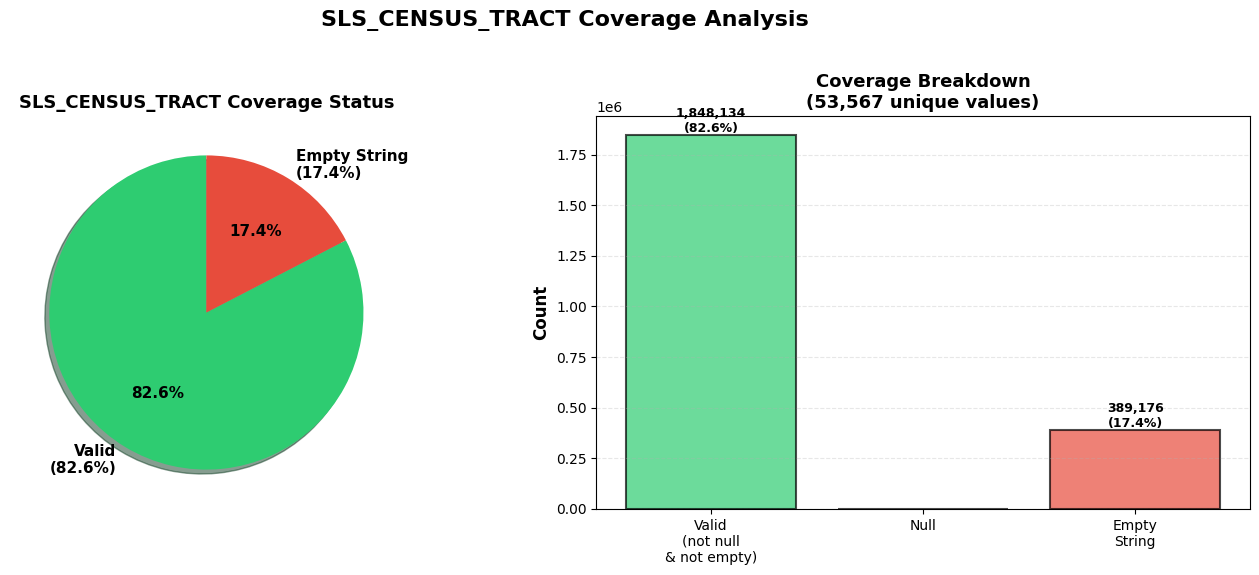


✓ SLS_CENSUS_TRACT analysis complete!


In [5]:
# SLS_CENSUS_TRACT Analysis
print("="*100)
print(" " * 35 + "SLS_CENSUS_TRACT ANALYSIS")
print("="*100)

total_rows = len(full_df_live)

# Check data type and values
print(f"\nColumn Information:")
print(f"  Data type: {full_df_live['SLS_CENSUS_TRACT'].dtype}")
print(f"  Total rows: {total_rows:,}")

# Check for nulls
null_count = full_df_live['SLS_CENSUS_TRACT'].isna().sum()
non_null_count = full_df_live['SLS_CENSUS_TRACT'].notna().sum()
null_pct = 100 * null_count / total_rows
non_null_pct = 100 * non_null_count / total_rows

print(f"\n  Null values:     {null_count:>12,} ({null_pct:>6.2f}%)")
print(f"  Non-null values: {non_null_count:>12,} ({non_null_pct:>6.2f}%)")

# Check for empty strings
empty_count = (full_df_live['SLS_CENSUS_TRACT'] == '').sum()
empty_pct = 100 * empty_count / total_rows

print(f"  Empty strings:   {empty_count:>12,} ({empty_pct:>6.2f}%)")

# Valid (non-null and non-empty)
valid_count = ((full_df_live['SLS_CENSUS_TRACT'].notna()) & 
               (full_df_live['SLS_CENSUS_TRACT'] != '')).sum()
valid_pct = 100 * valid_count / total_rows

print(f"  Valid values:    {valid_count:>12,} ({valid_pct:>6.2f}%)")

# Value distribution summary
print(f"\n{'='*100}")
print("VALUE DISTRIBUTION SUMMARY")
print(f"{'='*100}")

unique_count = full_df_live['SLS_CENSUS_TRACT'].nunique(dropna=False)
unique_non_null = full_df_live['SLS_CENSUS_TRACT'].nunique(dropna=True)

print(f"\n  Total unique values (including null): {unique_count:,}")
print(f"  Unique non-null values:                {unique_non_null:,}")

# Show top values if there are many unique values
if unique_non_null > 20:
    print(f"\n  Top 20 most common values:")
    print(f"  {'Value':<20} {'Count':<15} {'Percentage':<15}")
    print(f"  {'-'*55}")
    
    top_values = full_df_live['SLS_CENSUS_TRACT'].value_counts().head(20)
    for value, count in top_values.items():
        pct = 100 * count / total_rows
        value_str = str(value)[:18] if pd.notna(value) else 'NULL'
        print(f"  {value_str:<20} {count:>12,}   {pct:>6.2f}%")
    
    print(f"\n  ... and {unique_non_null - 20:,} more unique values")
else:
    print(f"\n  All unique values:")
    print(f"  {'Value':<30} {'Count':<15} {'Percentage':<15} {'Visual':<30}")
    print(f"  {'-'*90}")
    
    value_counts = full_df_live['SLS_CENSUS_TRACT'].value_counts(dropna=False)
    for value, count in value_counts.items():
        pct = 100 * count / total_rows
        bar_length = int(pct / 2)
        bar = '█' * bar_length
        value_str = str(value) if pd.notna(value) else 'NULL'
        print(f"  {value_str:<30} {count:>12,}   {pct:>6.2f}%        {bar}")

# Coverage analysis
print(f"\n{'='*100}")
print("COVERAGE ANALYSIS")
print(f"{'='*100}")

print(f"\n  Rows with valid SLS_CENSUS_TRACT:")
print(f"    (not null AND not empty)")
print(f"    Count:      {valid_count:>12,}")
print(f"    Percentage: {valid_pct:>12.2f}%")
bar_length = int(valid_pct / 2)
print(f"    {'█' * bar_length}")

print(f"\n  Rows with missing SLS_CENSUS_TRACT:")
print(f"    (null OR empty)")
missing_count = total_rows - valid_count
missing_pct = 100 * missing_count / total_rows
print(f"    Count:      {missing_count:>12,}")
print(f"    Percentage: {missing_pct:>12.2f}%")
bar_length = int(missing_pct / 2)
print(f"    {'█' * bar_length}")

# Visualization
print(f"\n{'='*100}")
print("CREATING VISUALIZATION")
print(f"{'='*100}")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('SLS_CENSUS_TRACT Coverage Analysis', fontsize=16, fontweight='bold')

# 1. Pie chart - Coverage status
ax1 = axes[0]
coverage_labels = [f'Valid\n({valid_pct:.1f}%)', 
                   f'Null\n({null_pct:.1f}%)', 
                   f'Empty String\n({empty_pct:.1f}%)']
coverage_sizes = [valid_count, null_count, empty_count]
coverage_colors = ['#2ecc71', '#95a5a6', '#e74c3c']

# Remove zero values for cleaner chart
filtered_labels = []
filtered_sizes = []
filtered_colors = []
for label, size, color in zip(coverage_labels, coverage_sizes, coverage_colors):
    if size > 0:
        filtered_labels.append(label)
        filtered_sizes.append(size)
        filtered_colors.append(color)

ax1.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('SLS_CENSUS_TRACT Coverage Status', fontsize=13, fontweight='bold')

# 2. Bar chart - Top values or coverage breakdown
ax2 = axes[1]

if unique_non_null > 10:
    # Show coverage breakdown if many unique values
    categories = ['Valid\n(not null\n& not empty)', 'Null', 'Empty\nString']
    counts = [valid_count, null_count, empty_count]
    colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    
    bars = ax2.bar(range(len(categories)), counts, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax2.set_title(f'Coverage Breakdown\n({unique_non_null:,} unique values)', 
                  fontsize=13, fontweight='bold')
    ax2.set_xticks(range(len(categories)))
    ax2.set_xticklabels(categories)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count and percentage labels
    for i, count in enumerate(counts):
        if count > 0:
            pct = 100 * count / total_rows
            ax2.text(i, count, f"{count:,}\n({pct:.1f}%)", ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
else:
    # Show top values if few unique values
    top_n = min(10, len(value_counts))
    top_values = value_counts.head(top_n)
    bar_labels = [str(v)[:15] if pd.notna(v) else 'NULL' for v in top_values.index]
    bar_counts = top_values.values
    bar_pcts = [100 * c / total_rows for c in bar_counts]
    
    bars = ax2.bar(range(len(bar_labels)), bar_pcts, color='steelblue', alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Value', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'Top {top_n} Values Distribution', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(len(bar_labels)))
    ax2.set_xticklabels(bar_labels, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add percentage labels
    for i, (pct, count) in enumerate(zip(bar_pcts, bar_counts)):
        ax2.text(i, pct + 1, f"{pct:.1f}%\n({count:,})", ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
chart_filename = 'sls_census_tract_distribution.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Chart saved: {chart_filename}")

plt.show()

print("\n" + "="*100)
print("✓ SLS_CENSUS_TRACT analysis complete!")
print("="*100)

In [6]:
# Clean Coverage Combinations Table (Screenshot-Ready)
print("="*120)
print(" " * 40 + "DATA COVERAGE ANALYSIS")
print("="*120)

# Define cutoff date for valid dates
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure date columns are datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')
full_df_live['NVI_EFCTV_START_DT'] = pd.to_datetime(full_df_live['NVI_EFCTV_START_DT'], errors='coerce')

# Create coverage flags
full_df_live['has_sales'] = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date)
)

full_df_live['has_registration'] = (
    (full_df_live['NVI_EFCTV_START_DT'].notna()) & 
    (full_df_live['NVI_EFCTV_START_DT'] >= cutoff_date)
)

full_df_live['has_inventory'] = (
    (full_df_live['INV_CENSUS_TRACT'].notna()) & 
    (full_df_live['INV_CENSUS_TRACT'] != '')
)

# Calculate total rows
total_rows = len(full_df_live)

print(f"\nCoverage Definitions:")
print(f"  • Sales:        SLS_EFCTV_START_DT is not null AND >= 2050-01-01")
print(f"  • Registration: NVI_EFCTV_START_DT is not null AND >= 1950-01-01")
print(f"  • Inventory:    INV_CENSUS_TRACT is not null AND not empty")
print(f"\nTotal Dataset Size: {total_rows:,} rows")

# Group by all three coverage flags
coverage_df = full_df_live.groupby([
    'has_sales',
    'has_registration',
    'has_inventory'
]).size().reset_index(name='Count')

coverage_df['Percentage'] = (coverage_df['Count'] / total_rows) * 100

# Create readable labels
def get_coverage_label(row):
    parts = []
    if row['has_sales']:
        parts.append('Sales')
    if row['has_registration']:
        parts.append('Registration')
    if row['has_inventory']:
        parts.append('Inventory')
    return ' + '.join(parts) if parts else 'None'

coverage_df['Coverage_Types'] = coverage_df.apply(get_coverage_label, axis=1)

# Sort by count descending
coverage_df = coverage_df.sort_values('Count', ascending=False).reset_index(drop=True)

# Create formatted table
print("\n" + "="*120)
print(" " * 35 + "COVERAGE COMBINATIONS BREAKDOWN")
print("="*120)
print()

# Header
header = f"{'#':<4} {'Sales':<8} {'Registration':<15} {'Inventory':<12} {'Coverage Description':<35} {'Count':<18} {'Percentage':<12}"
print(header)
print("-" * 120)

# Rows
for idx, row in coverage_df.iterrows():
    num = idx + 1
    sales_icon = '✓' if row['has_sales'] else '✗'
    reg_icon = '✓' if row['has_registration'] else '✗'
    inv_icon = '✓' if row['has_inventory'] else '✗'
    coverage_desc = row['Coverage_Types']
    count = f"{row['Count']:,}"
    percentage = f"{row['Percentage']:.2f}%"
    
    print(f"{num:<4} {sales_icon:<8} {reg_icon:<15} {inv_icon:<12} {coverage_desc:<35} {count:<18} {percentage:<12}")

print("="*120)

# Summary section
print("\n" + "="*120)
print(" " * 45 + "SUMMARY STATISTICS")
print("="*120)

# Calculate aggregates
all_three = coverage_df[
    (coverage_df['has_sales']) & 
    (coverage_df['has_registration']) & 
    (coverage_df['has_inventory'])
]['Count'].sum()

at_least_two = coverage_df[
    ((coverage_df['has_sales'].astype(int) + 
      coverage_df['has_registration'].astype(int) + 
      coverage_df['has_inventory'].astype(int)) >= 2)
]['Count'].sum()

at_least_one = coverage_df[
    ((coverage_df['has_sales']) | 
     (coverage_df['has_registration']) | 
     (coverage_df['has_inventory']))
]['Count'].sum()

no_coverage = coverage_df[
    (~coverage_df['has_sales']) & 
    (~coverage_df['has_registration']) & 
    (~coverage_df['has_inventory'])
]['Count'].sum()

# Individual totals
sales_total = full_df_live['has_sales'].sum()
reg_total = full_df_live['has_registration'].sum()
inv_total = full_df_live['has_inventory'].sum()

print(f"\nAggregate Coverage Levels:")
print(f"  All 3 data types:          {all_three:>15,}  ({100*all_three/total_rows:>6.2f}%)")
print(f"  At least 2 data types:     {at_least_two:>15,}  ({100*at_least_two/total_rows:>6.2f}%)")
print(f"  At least 1 data type:      {at_least_one:>15,}  ({100*at_least_one/total_rows:>6.2f}%)")
print(f"  No coverage:               {no_coverage:>15,}  ({100*no_coverage/total_rows:>6.2f}%)")

print(f"\nIndividual Data Type Coverage:")
print(f"  Sales coverage:            {sales_total:>15,}  ({100*sales_total/total_rows:>6.2f}%)")
print(f"  Registration coverage:     {reg_total:>15,}  ({100*reg_total/total_rows:>6.2f}%)")
print(f"  Inventory coverage:        {inv_total:>15,}  ({100*inv_total/total_rows:>6.2f}%)")

print("\n" + "="*120)

# Create a nicely formatted pandas DataFrame for easy screenshot
display_df = pd.DataFrame({
    '#': range(1, len(coverage_df) + 1),
    'Sales': ['✓' if x else '✗' for x in coverage_df['has_sales']],
    'Registration': ['✓' if x else '✗' for x in coverage_df['has_registration']],
    'Inventory': ['✓' if x else '✗' for x in coverage_df['has_inventory']],
    'Coverage Description': coverage_df['Coverage_Types'],
    'Count': coverage_df['Count'].apply(lambda x: f"{x:,}"),
    'Percentage': coverage_df['Percentage'].apply(lambda x: f"{x:.2f}%")
})

print("\n" + "="*120)
print(" " * 30 + "FORMATTED TABLE (PANDAS DATAFRAME - READY FOR SCREENSHOT)")
print("="*120)
print()
print(display_df.to_string(index=False))
print()
print("="*120)

                                        DATA COVERAGE ANALYSIS

Coverage Definitions:
  • Sales:        SLS_EFCTV_START_DT is not null AND >= 2050-01-01
  • Registration: NVI_EFCTV_START_DT is not null AND >= 1950-01-01
  • Inventory:    INV_CENSUS_TRACT is not null AND not empty

Total Dataset Size: 2,237,310 rows

                                   COVERAGE COMBINATIONS BREAKDOWN

#    Sales    Registration    Inventory    Coverage Description                Count              Percentage  
------------------------------------------------------------------------------------------------------------------------
1    ✓        ✓               ✓            Sales + Registration + Inventory    1,615,015          72.19%      
2    ✗        ✓               ✓            Registration + Inventory            282,472            12.63%      
3    ✓        ✗               ✓            Sales + Inventory                   124,825            5.58%       
4    ✗        ✓               ✗            Regist

In [7]:
# Aggregate NVI_VIN_COUNT Analysis
print("="*100)
print(" " * 35 + "NVI_VIN_COUNT AGGREGATION")
print("="*100)

total_rows = len(full_df_live)

# Check if column exists
if 'NVI_VIN_COUNT' in full_df_live.columns:
    print(f"\nColumn Information:")
    print(f"  Data type: {full_df_live['NVI_VIN_COUNT'].dtype}")
    print(f"  Total rows: {total_rows:,}")
    
    # Check for nulls
    null_count = full_df_live['NVI_VIN_COUNT'].isna().sum()
    non_null_count = full_df_live['NVI_VIN_COUNT'].notna().sum()
    
    print(f"\n  Null values:     {null_count:>12,} ({100*null_count/total_rows:>6.2f}%)")
    print(f"  Non-null values: {non_null_count:>12,} ({100*non_null_count/total_rows:>6.2f}%)")
    
    # Aggregation
    print(f"\n{'='*100}")
    print("AGGREGATED STATISTICS")
    print(f"{'='*100}")
    
    total_sum = full_df_live['NVI_VIN_COUNT'].sum()
    mean_value = full_df_live['NVI_VIN_COUNT'].mean()
    median_value = full_df_live['NVI_VIN_COUNT'].median()
    min_value = full_df_live['NVI_VIN_COUNT'].min()
    max_value = full_df_live['NVI_VIN_COUNT'].max()
    std_value = full_df_live['NVI_VIN_COUNT'].std()
    
    print(f"\n  Total Sum:       {total_sum:>20,.0f}")
    print(f"  Mean (Average):  {mean_value:>20,.2f}")
    print(f"  Median:          {median_value:>20,.2f}")
    print(f"  Std Deviation:   {std_value:>20,.2f}")
    print(f"  Minimum:         {min_value:>20,.0f}")
    print(f"  Maximum:         {max_value:>20,.0f}")
    
    # Percentiles
    print(f"\n  Percentiles:")
    percentiles = [25, 50, 75, 90, 95, 99]
    for p in percentiles:
        val = full_df_live['NVI_VIN_COUNT'].quantile(p/100)
        print(f"    {p:>3}th percentile: {val:>15,.2f}")
    
    # Value distribution
    print(f"\n{'='*100}")
    print("VALUE DISTRIBUTION")
    print(f"{'='*100}")
    
    unique_count = full_df_live['NVI_VIN_COUNT'].nunique(dropna=True)
    print(f"\n  Unique values: {unique_count:,}")
    
    if unique_count <= 20:
        print(f"\n  All unique values:")
        value_counts = full_df_live['NVI_VIN_COUNT'].value_counts().sort_index()
        print(f"  {'Value':<15} {'Count':<15} {'Percentage':<15}")
        print(f"  {'-'*45}")
        for value, count in value_counts.items():
            pct = 100 * count / total_rows
            print(f"  {value:<15,.0f} {count:>12,}   {pct:>6.2f}%")
    else:
        print(f"\n  Top 20 most common values:")
        value_counts = full_df_live['NVI_VIN_COUNT'].value_counts().head(20)
        print(f"  {'Value':<15} {'Count':<15} {'Percentage':<15}")
        print(f"  {'-'*45}")
        for value, count in value_counts.items():
            pct = 100 * count / total_rows
            print(f"  {value:<15,.0f} {count:>12,}   {pct:>6.2f}%")
        
        if unique_count > 20:
            print(f"\n  ... and {unique_count - 20:,} more unique values")
    
else:
    print("\n⚠️  Column 'NVI_VIN_COUNT' not found in dataset!")
    print("\nAvailable columns containing 'VIN' or 'COUNT':")
    matching_cols = [col for col in full_df_live.columns if 'VIN' in col.upper() or 'COUNT' in col.upper()]
    if matching_cols:
        for col in matching_cols:
            print(f"  - {col}")
    else:
        print("  No matching columns found")

print("\n" + "="*100)
print("✓ NVI_VIN_COUNT aggregation complete!")
print("="*100)

                                   NVI_VIN_COUNT AGGREGATION

Column Information:
  Data type: float64
  Total rows: 2,237,310

  Null values:                0 (  0.00%)
  Non-null values:    2,237,310 (100.00%)

AGGREGATED STATISTICS

  Total Sum:                  2,306,288
  Mean (Average):                  1.03
  Median:                          1.00
  Std Deviation:                   2.41
  Minimum:                            0
  Maximum:                        1,066

  Percentiles:
     25th percentile:            1.00
     50th percentile:            1.00
     75th percentile:            1.00
     90th percentile:            1.00
     95th percentile:            1.00
     99th percentile:            3.00

VALUE DISTRIBUTION

  Unique values: 204

  Top 20 most common values:
  Value           Count           Percentage     
  ---------------------------------------------
  1                  2,039,197    91.15%
  0                    153,261     6.85%
  2                     20,7

In [8]:
# Total VINs vs Rows Comparison
print("="*100)
print(" " * 30 + "TOTAL VINs vs ROWS COMPARISON")
print("="*100)

# Number of rows
total_rows = len(full_df_live)

# Sum of all VIN counts
if 'NVI_VIN_COUNT' in full_df_live.columns:
    total_vins = full_df_live['NVI_VIN_COUNT'].sum()
    
    print(f"\n📊 Summary:")
    print(f"  Total Rows in Dataset:        {total_rows:>20,}")
    print(f"  Total VINs (sum of VIN_COUNT): {total_vins:>20,.0f}")
    
    # Calculate ratio
    if total_rows > 0:
        vins_per_row = total_vins / total_rows
        print(f"\n📈 Ratio:")
        print(f"  Average VINs per Row:         {vins_per_row:>20,.2f}")
    
    # Show comparison
    print(f"\n🔍 Comparison:")
    if total_vins > total_rows:
        difference = total_vins - total_rows
        pct_more = (difference / total_rows) * 100
        print(f"  VINs are MORE than Rows by:   {difference:>20,.0f} ({pct_more:>6.2f}% more)")
    elif total_vins < total_rows:
        difference = total_rows - total_vins
        pct_less = (difference / total_rows) * 100
        print(f"  VINs are LESS than Rows by:   {difference:>20,.0f} ({pct_less:>6.2f}% less)")
    else:
        print(f"  VINs equal Rows (1:1 ratio)")
    
else:
    print("\n⚠️  Column 'NVI_VIN_COUNT' not found!")
    print("\nSearching for similar columns...")
    vin_cols = [col for col in full_df_live.columns if 'VIN' in col.upper()]
    if vin_cols:
        print("  Columns containing 'VIN':")
        for col in vin_cols:
            print(f"    - {col}")

print("\n" + "="*100)

                              TOTAL VINs vs ROWS COMPARISON

📊 Summary:
  Total Rows in Dataset:                   2,237,310
  Total VINs (sum of VIN_COUNT):            2,306,288

📈 Ratio:
  Average VINs per Row:                         1.03

🔍 Comparison:
  VINs are MORE than Rows by:                 68,978 (  3.08% more)



In [10]:
# Total SLS Count vs Rows Comparison
print("="*100)
print(" " * 25 + "TOTAL SLS COUNT vs ROWS COMPARISON")
print("="*100)

# Number of rows
total_rows = len(full_df_live)

# Sum of all SLS counts
if 'SLS_COUNT' in full_df_live.columns:
    total_sls_count = full_df_live['SLS_COUNT'].sum()
    
    print(f"\n📊 Summary:")
    print(f"  Total Rows in Dataset:         {total_rows:>20,}")
    print(f"  Total SLS COUNT (sum):         {total_sls_count:>20,.0f}")
    
    # Calculate ratio
    if total_rows > 0:
        count_per_row = total_sls_count / total_rows
        print(f"\n📈 Ratio:")
        print(f"  Average SLS COUNT per Row:     {count_per_row:>20,.2f}")
    
    # Show comparison
    print(f"\n🔍 Comparison:")
    if total_sls_count > total_rows:
        difference = total_sls_count - total_rows
        pct_more = (difference / total_rows) * 100
        print(f"  SLS COUNT is MORE than Rows by: {difference:>20,.0f} ({pct_more:>6.2f}% more)")
    elif total_sls_count < total_rows:
        difference = total_rows - total_sls_count
        pct_less = (difference / total_rows) * 100
        print(f"  SLS COUNT is LESS than Rows by: {difference:>20,.0f} ({pct_less:>6.2f}% less)")
    else:
        print(f"  SLS COUNT equals Rows (1:1 ratio)")
    
else:
    print("\n⚠️  Column 'SLS_COUNT' not found!")
    print("\nSearching for similar columns...")
    sls_cols = [col for col in full_df_live.columns if 'SLS' in col.upper() and 'COUNT' in col.upper()]
    if sls_cols:
        print("  Columns containing 'SLS' and 'COUNT':")
        for col in sls_cols:
            print(f"    - {col}")

print("\n" + "="*100)

                         TOTAL SLS COUNT vs ROWS COMPARISON

📊 Summary:
  Total Rows in Dataset:                    2,237,310
  Total SLS COUNT (sum):                    1,909,168

📈 Ratio:
  Average SLS COUNT per Row:                     0.85

🔍 Comparison:
  SLS COUNT is LESS than Rows by:              328,142 ( 14.67% less)



In [ ]:
# Analysis: SLS_EFCTV_START_DT < 1950 but with other SLS data
print("="*100)
print(" " * 20 + "ROWS WITH SLS_EFCTV_START_DT < 1950 BUT OTHER SLS DATA")
print("="*100)

# Define cutoff date
cutoff_date = pd.Timestamp('1950-01-01')

# Ensure SLS_EFCTV_START_DT is datetime
full_df_live['SLS_EFCTV_START_DT'] = pd.to_datetime(full_df_live['SLS_EFCTV_START_DT'], errors='coerce')

# Define specific SLS (sales) columns as provided by user
sls_columns = [
    'SLS_EFCTV_START_DT',
    'SLS_RPT_WK',
    'SLS_CENSUS_TRACT',
    'SLS_CNVTD_DLR_CD',
    'SLS_DEALER_NAME',
    'SLS_TOWN_NAME',
    'SLS_STATE_ABBRV',
    'SLS_COMMERCIAL_FLAG',
    'SLS_DEALER_FLAG',
    'SLS_COUNT'
]

# Verify all columns exist in the dataframe
existing_sls_cols = [col for col in sls_columns if col in full_df_live.columns]
missing_sls_cols = [col for col in sls_columns if col not in full_df_live.columns]

if missing_sls_cols:
    print(f"\n⚠️ Warning: {len(missing_sls_cols)} SLS columns not found in dataset:")
    for col in missing_sls_cols:
        print(f"  - {col}")
    sls_columns = existing_sls_cols

print(f"\nAnalyzing {len(sls_columns)} SLS (sales) columns:")
for i, col in enumerate(sls_columns, 1):
    print(f"  {i:2d}. {col}")

# Identify rows with SLS_EFCTV_START_DT < 1950
sls_before_1950 = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] < cutoff_date)
)

total_rows = len(full_df_live)
rows_before_1950 = sls_before_1950.sum()

print(f"\n{'='*100}")
print("SLS_EFCTV_START_DT DATE CATEGORIES")
print(f"{'='*100}")

sls_null = full_df_live['SLS_EFCTV_START_DT'].isna().sum()
sls_before_1950_count = rows_before_1950
sls_after_1950 = (
    (full_df_live['SLS_EFCTV_START_DT'].notna()) & 
    (full_df_live['SLS_EFCTV_START_DT'] >= cutoff_date)
).sum()

print(f"\n  SLS_EFCTV_START_DT is null:        {sls_null:>12,} ({100*sls_null/total_rows:>6.2f}%)")
print(f"  SLS_EFCTV_START_DT < 1950:         {sls_before_1950_count:>12,} ({100*sls_before_1950_count/total_rows:>6.2f}%)")
print(f"  SLS_EFCTV_START_DT >= 1950:        {sls_after_1950:>12,} ({100*sls_after_1950/total_rows:>6.2f}%)")

if rows_before_1950 > 0:
    print(f"\n{'='*100}")
    print("ANALYSIS: ROWS WITH SLS_EFCTV_START_DT < 1950")
    print(f"{'='*100}")
    
    # Filter to rows with SLS_EFCTV_START_DT < 1950
    df_before_1950 = full_df_live[sls_before_1950].copy()
    
    print(f"\nAnalyzing {len(df_before_1950):,} rows with SLS_EFCTV_START_DT < 1950...")
    
    # Check which SLS columns have data in these rows
    print(f"\n{'='*100}")
    print("SLS COLUMNS DATA PRESENCE (for rows with SLS_EFCTV_START_DT < 1950)")
    print(f"{'='*100}")
    
    print(f"\n  {'Column Name':<40} {'Non-Null Count':<18} {'Non-Null %':<15} {'Has Data':<10}")
    print(f"  {'-'*90}")
    
    sls_data_presence = {}
    for col in sls_columns:
        non_null_count = df_before_1950[col].notna().sum()
        non_null_pct = 100 * non_null_count / len(df_before_1950)
        
        # For string columns, also check for non-empty
        if df_before_1950[col].dtype == 'object':
            non_empty_count = ((df_before_1950[col].notna()) & (df_before_1950[col] != '')).sum()
            has_data = '✓' if non_empty_count > 0 else '✗'
            sls_data_presence[col] = non_empty_count
        else:
            has_data = '✓' if non_null_count > 0 else '✗'
            sls_data_presence[col] = non_null_count
        
        print(f"  {col:<40} {non_null_count:>15,}   {non_null_pct:>6.2f}%        {has_data:<10}")
    
    # Count how many rows have ANY other SLS data
    print(f"\n{'='*100}")
    print("SUMMARY: OTHER SLS DATA PRESENCE")
    print(f"{'='*100}")
    
    # Check each row if it has data in any SLS column (excluding SLS_EFCTV_START_DT)
    other_sls_cols = [col for col in sls_columns if col != 'SLS_EFCTV_START_DT']
    
    has_any_other_sls = pd.Series(False, index=df_before_1950.index)
    
    for col in other_sls_cols:
        if df_before_1950[col].dtype == 'object':
            # For string columns, check non-null and non-empty
            has_data_in_col = (df_before_1950[col].notna()) & (df_before_1950[col] != '')
        else:
            # For numeric/date columns, just check non-null
            has_data_in_col = df_before_1950[col].notna()
        
        has_any_other_sls = has_any_other_sls | has_data_in_col
    
    rows_with_other_sls = has_any_other_sls.sum()
    rows_without_other_sls = len(df_before_1950) - rows_with_other_sls
    
    pct_with_other_sls = 100 * rows_with_other_sls / len(df_before_1950)
    pct_without_other_sls = 100 * rows_without_other_sls / len(df_before_1950)
    
    print(f"\nOf {len(df_before_1950):,} rows with SLS_EFCTV_START_DT < 1950:")
    print(f"\n  Rows WITH data in other SLS columns:    {rows_with_other_sls:>12,} ({pct_with_other_sls:>6.2f}%)")
    print(f"  Rows WITHOUT data in other SLS columns: {rows_without_other_sls:>12,} ({pct_without_other_sls:>6.2f}%)")
    
    # As percentage of total dataset
    pct_of_total_with_other_sls = 100 * rows_with_other_sls / total_rows
    pct_of_total_without_other_sls = 100 * rows_without_other_sls / total_rows
    
    print(f"\nAs percentage of TOTAL dataset ({total_rows:,} rows):")
    print(f"  Rows WITH SLS_EFCTV_START_DT < 1950 AND other SLS data:    {rows_with_other_sls:>12,} ({pct_of_total_with_other_sls:>6.2f}%)")
    print(f"  Rows WITH SLS_EFCTV_START_DT < 1950 BUT NO other SLS data: {rows_without_other_sls:>12,} ({pct_of_total_without_other_sls:>6.2f}%)")
    
    # Show which columns have the most data
    print(f"\n{'='*100}")
    print("TOP 10 SLS COLUMNS WITH MOST DATA (excluding SLS_EFCTV_START_DT)")
    print(f"{'='*100}")
    
    other_sls_data_sorted = sorted(
        [(col, count) for col, count in sls_data_presence.items() if col != 'SLS_EFCTV_START_DT'],
        key=lambda x: x[1],
        reverse=True
    )
    
    print(f"\n  {'Rank':<6} {'Column Name':<40} {'Rows with Data':<18} {'%':<10}")
    print(f"  {'-'*80}")
    
    for i, (col, count) in enumerate(other_sls_data_sorted[:10], 1):
        pct = 100 * count / len(df_before_1950)
        print(f"  {i:<6} {col:<40} {count:>15,}   {pct:>6.2f}%")
    
else:
    print("\n✓ No rows found with SLS_EFCTV_START_DT < 1950")

print("\n" + "="*100)
print("✓ Analysis complete!")
print("="*100)